# Anàlisis de sentiment de ressenyes de la cadena Starbucks a través de la llibreria Spark

### Objectiu principal:
> Crear un model capaç de classificar correctament una ressenya en Positiu, neutre o negatiu.

**Com ho faré (ML):**
> 1. Preprocessat de text (Tokenization, stopwords, lematization, stemming).
> 2. Aplicar modes NLTK per etiquetar el text com VADER SENTIMIENT ANALYZER y TEXTBLOB.
> 3. Comprovar l'efectivament d'aquestes comparant-ho amb les puntuacións.
> 4. Crear un nou model a través de les llibreries de ML, entrenar-lo i testejar-lo.
> 5. Comprovar la seva eficacia amb mètriques de medició.
> 6. Aplicar i comprovar la seva efectivitat.      

**Que necessitaré per fer-ho (Anàlisi del df):**
> 1. Exploració inicial del df
> 2. Modificacions necessàries del df
> 3. Fer un anàlisi de les dades del df abans d'utilitzar ML com per exemple  
>     a) Agrupació per zones.  
      b) Veure com es comporten per trimestres o estacions, dies de la setmana.  
      c) Comprovar la relació entre pujar imatges i la puntuació que se'ls hi dona.       

## Anàlisi del df 
#### 1. Exploració inicial

In [1]:
# Import basic libraries
import findspark
findspark.init()
import pyspark
import random
import pandas as pd
import re
import pyspark.sql.functions as F
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import *

# Charge the environment
sc = SparkSession.builder.appName("Projecte_borch008").getOrCreate()

In [2]:
# Import data and show first rows
starbucks = sc.read.option("delimiter", ",").option("header", "true").option("inferschema", "true").csv("reviews_data.csv")
type(starbucks)

pyspark.sql.dataframe.DataFrame

In [3]:
# Show first rows of dataframe
starbucks.show()

+---------+-----------------+--------------------+------+--------------------+--------------------+
|     name|         location|                Date|Rating|              Review|         Image_Links|
+---------+-----------------+--------------------+------+--------------------+--------------------+
|    Helen|Wichita Falls, TX|Reviewed Sept. 13...|     5|Amber and LaDonna...|       ['No Images']|
| Courtney|       Apopka, FL|Reviewed July 16,...|     5|** at the Starbuc...|       ['No Images']|
| Daynelle|Cranberry Twp, PA|Reviewed July 5, ...|     5|I just wanted to ...|['https://media.c...|
|   Taylor|      Seattle, WA|Reviewed May 26, ...|     5|Me and my friend ...|       ['No Images']|
|  Tenessa|      Gresham, OR|Reviewed Jan. 22,...|     5|I’m on this kick ...|['https://media.c...|
|   Alyssa|    Sunnyvale, TX|Reviewed Sept. 14...|     1|We had to correct...|       ['No Images']|
|      ken|  Spring Hill, FL|Reviewed Sept. 8,...|     1|I have tried Star...|       ['No Images']|


In [4]:
# Check schema od df 
print(starbucks.printSchema())

root
 |-- name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- Image_Links: string (nullable = true)

None


_veiem que totes les columnes tenen un dtype de string, segurament farem algúns canvis per poder fer una bona exploració de les dades_

__Observacions i canvis a realitzar:__
> 1. Veiem que els noms de les columnes alguns estan en majúscules i alguns no, haurem d'unificar.
> 2. La columna _name_ veiem que no hi ha uniformitat amb mínuscules i majúscules i que només surt el nom de la persona (sense cognom)
> 3. La columna _location_ veiem que la podem separar en dos: població i regió. També comprovar que els noms estan unificats
> 4. La columna _Date_ veiem que podem treure la paraula Review ja que no ens aporta res, estaria bé fer vàries transformacions a int per poder fer diverses observacions i analisis (trimestres, mesos, dies, seria ideal intentar aconseguir que ens digues el dia de la setmana.., investigaré sobre si hi ha llibreries que ho fan).
> 5. La columna _Image_Links_, la voldré transformar a una columna binaria o dummie per veure si pot a veure alguna relació amb la puntuació o el sentiment de la review.
> 6. La columna _Review_ és la que utilitzarem per fer l'ànalisi de sentiment.

#### 2. Modificacions a fer

In [5]:
# Uniform column names
starbucks = starbucks.withColumnRenamed("name", "Name").withColumnRenamed("location", "Location")
starbucks.columns

['Name', 'Location', 'Date', 'Rating', 'Review', 'Image_Links']

In [6]:
# Capitalize names from Name column
starbucks = starbucks.withColumn("Name", F.initcap(starbucks["Name"]))
starbucks.show()

+---------+-----------------+--------------------+------+--------------------+--------------------+
|     Name|         Location|                Date|Rating|              Review|         Image_Links|
+---------+-----------------+--------------------+------+--------------------+--------------------+
|    Helen|Wichita Falls, TX|Reviewed Sept. 13...|     5|Amber and LaDonna...|       ['No Images']|
| Courtney|       Apopka, FL|Reviewed July 16,...|     5|** at the Starbuc...|       ['No Images']|
| Daynelle|Cranberry Twp, PA|Reviewed July 5, ...|     5|I just wanted to ...|['https://media.c...|
|   Taylor|      Seattle, WA|Reviewed May 26, ...|     5|Me and my friend ...|       ['No Images']|
|  Tenessa|      Gresham, OR|Reviewed Jan. 22,...|     5|I’m on this kick ...|['https://media.c...|
|   Alyssa|    Sunnyvale, TX|Reviewed Sept. 14...|     1|We had to correct...|       ['No Images']|
|      Ken|  Spring Hill, FL|Reviewed Sept. 8,...|     1|I have tried Star...|       ['No Images']|


In [7]:
# Split Location into two columns (Cities and State)
from pyspark.sql.functions import regexp_replace
starbucks = starbucks.withColumn("Cities", F.split(starbucks["Location"], ",")[0]).withColumn("Location", F.regexp_replace(starbucks["Location"], r"^[^,]*,\s*", ""))
starbucks.show()

+---------+--------+--------------------+------+--------------------+--------------------+-------------+
|     Name|Location|                Date|Rating|              Review|         Image_Links|       Cities|
+---------+--------+--------------------+------+--------------------+--------------------+-------------+
|    Helen|      TX|Reviewed Sept. 13...|     5|Amber and LaDonna...|       ['No Images']|Wichita Falls|
| Courtney|      FL|Reviewed July 16,...|     5|** at the Starbuc...|       ['No Images']|       Apopka|
| Daynelle|      PA|Reviewed July 5, ...|     5|I just wanted to ...|['https://media.c...|Cranberry Twp|
|   Taylor|      WA|Reviewed May 26, ...|     5|Me and my friend ...|       ['No Images']|      Seattle|
|  Tenessa|      OR|Reviewed Jan. 22,...|     5|I’m on this kick ...|['https://media.c...|      Gresham|
|   Alyssa|      TX|Reviewed Sept. 14...|     1|We had to correct...|       ['No Images']|    Sunnyvale|
|      Ken|      FL|Reviewed Sept. 8,...|     1|I have 

In [8]:
# Replce Reviewed word
starbucks = starbucks.withColumn("Date", F.regexp_replace(starbucks["Date"], r"^[^\s]*\s*", ""))
starbucks.show(5)

+--------+--------+--------------+------+--------------------+--------------------+-------------+
|    Name|Location|          Date|Rating|              Review|         Image_Links|       Cities|
+--------+--------+--------------+------+--------------------+--------------------+-------------+
|   Helen|      TX|Sept. 13, 2023|     5|Amber and LaDonna...|       ['No Images']|Wichita Falls|
|Courtney|      FL| July 16, 2023|     5|** at the Starbuc...|       ['No Images']|       Apopka|
|Daynelle|      PA|  July 5, 2023|     5|I just wanted to ...|['https://media.c...|Cranberry Twp|
|  Taylor|      WA|  May 26, 2023|     5|Me and my friend ...|       ['No Images']|      Seattle|
| Tenessa|      OR| Jan. 22, 2023|     5|I’m on this kick ...|['https://media.c...|      Gresham|
+--------+--------+--------------+------+--------------------+--------------------+-------------+
only showing top 5 rows



In [9]:
# Check unique values of States and cities column
print(f"Hi ha ressenyes de {starbucks.select('Location').distinct().rdd.map(lambda row: row[0]).count()} estats diferents")
print(f"Hi ha ressenyes de {starbucks.select('Cities').distinct().rdd.map(lambda row: row[0]).count()} ciutats diferents")

Hi ha ressenyes de 91 estats diferents
Hi ha ressenyes de 597 ciutats diferents


In [10]:
# Check unique values of Location column
starbucks.select('Location').distinct().rdd.map(lambda row: row[0]).collect()

['NO OTHER LINE NEEDED',
 'AZ',
 'SC',
 'BECCLES',
 'NS',
 'Minnesota',
 'LA',
 'NL',
 'MN',
 'NJ',
 'tx',
 'DC',
 'Ampang, Other',
 'oh',
 'OR',
 'VA',
 'QC',
 'RI',
 'KY',
 'WY',
 'BC',
 'NH',
 'MI',
 'NV',
 'Alberta',
 'WI',
 'ID',
 'CA',
 'NE',
 'CT',
 'MT',
 'NC',
 'MD',
 'other',
 'MO',
 'sc',
 'IL',
 'Other',
 'ME',
 'MB',
 'Saskatchewan',
 'Canada, Other',
 'WA',
 'ND',
 'MS',
 'AL',
 'IN',
 'OH',
 'TN',
 'fl',
 'IA',
 'NM',
 'ca',
 'PA',
 'Leighton Buzzard, LA',
 'Virginia',
 'Michigan',
 'NY',
 'ON',
 'UK',
 'SK',
 'Wyoming',
 'AB',
 'ma',
 'OTHER',
 'TX',
 'Canada',
 'Ala',
 'WV',
 'Wi.',
 'Ontario, Other',
 'GA',
 'az',
 'MA',
 'KS',
 'ky',
 'Florida',
 'FL',
 'CO',
 'AK',
 'South Carolina',
 'AR',
 'California',
 'SC, SC',
 'OK',
 'New York',
 'UT',
 'United Kingdom',
 'Maine',
 'Colorado',
 'HI']

_No tenia molta lògica que hi hagin tantes ressenyes úniques de tants estats i ciutats diferents. Haurem d'unificar_

In [11]:
# Make all strings capital letters
starbucks = starbucks.withColumn("Location", F.upper(F.col("Location")))

# Filter df with more than two carachters in state column
states = starbucks.filter(starbucks["Location"].rlike(".{3,}"))
states.select('Location').distinct().rdd.map(lambda row: row[0]).collect()                   

['NO OTHER LINE NEEDED',
 'BECCLES',
 'UNITED KINGDOM',
 'MICHIGAN',
 'FLORIDA',
 'ONTARIO, OTHER',
 'CANADA, OTHER',
 'CANADA',
 'LEIGHTON BUZZARD, LA',
 'MAINE',
 'VIRGINIA',
 'WYOMING',
 'SASKATCHEWAN',
 'MINNESOTA',
 'ALBERTA',
 'ALA',
 'COLORADO',
 'OTHER',
 'NEW YORK',
 'CALIFORNIA',
 'WI.',
 'AMPANG, OTHER',
 'SOUTH CAROLINA',
 'SC, SC']

In [12]:
# Change string caracthers to unify states
changes = {
    "MICHIGAN": "MI",
    "FLORIDA": "FL",
    "LEIGHTON BUZZARD, LA": "LA",
    "MAINE": "ME",
    "VIRGINIA": "VA",
    "WYOMING": "WY",
    "MINNESOTA": "MN",
    "ALA": "AL",
    "COLORADO.": "CO",
    "NEW YORK": "NY",
    "CALIFORNIA": "CA",
    "WI.": "WI",
    "SOUTH CAROLINA": "SC",
    "SC, SC": "SC"
}

for state, replacement in changes.items():
    starbucks = starbucks.withColumn("Location", regexp_replace(starbucks["Location"], state, replacement))

starbucks = starbucks.withColumn("Location", F.when(F.length(starbucks["Location"]) > 3, "OTHER").otherwise(starbucks["Location"]))
starbucks.show(5)

+--------+--------+--------------+------+--------------------+--------------------+-------------+
|    Name|Location|          Date|Rating|              Review|         Image_Links|       Cities|
+--------+--------+--------------+------+--------------------+--------------------+-------------+
|   Helen|      TX|Sept. 13, 2023|     5|Amber and LaDonna...|       ['No Images']|Wichita Falls|
|Courtney|      FL| July 16, 2023|     5|** at the Starbuc...|       ['No Images']|       Apopka|
|Daynelle|      PA|  July 5, 2023|     5|I just wanted to ...|['https://media.c...|Cranberry Twp|
|  Taylor|      WA|  May 26, 2023|     5|Me and my friend ...|       ['No Images']|      Seattle|
| Tenessa|      OR| Jan. 22, 2023|     5|I’m on this kick ...|['https://media.c...|      Gresham|
+--------+--------+--------------+------+--------------------+--------------------+-------------+
only showing top 5 rows



In [13]:
# Filter df with more than two carachters in state column
print(starbucks.select('Location').distinct().rdd.map(lambda row: row[0]).count())  
starbucks.groupBy("Location").count().orderBy(F.asc("Location")).show(starbucks.select('Location').distinct().rdd.map(lambda row: row[0]).count())

58
+--------+-----+
|Location|count|
+--------+-----+
|      AB|    7|
|      AK|    1|
|      AL|    4|
|      AR|    5|
|      AZ|   25|
|      BC|    8|
|      CA|  182|
|      CO|   20|
|      CT|    1|
|      DC|    4|
|      FL|   48|
|      GA|   27|
|      HI|    4|
|      IA|    1|
|      ID|    3|
|      IL|   27|
|      IN|    9|
|      KS|    2|
|      KY|    9|
|      LA|    7|
|      MA|   19|
|      MB|    1|
|      MD|   10|
|      ME|    3|
|      MI|   10|
|      MN|    7|
|      MO|   12|
|      MS|    2|
|      MT|    1|
|      NC|   27|
|      ND|    1|
|      NE|    5|
|      NH|    1|
|      NJ|   23|
|      NL|    1|
|      NM|    8|
|      NS|    3|
|      NV|   13|
|      NY|   38|
|      OH|   20|
|      OK|    4|
|      ON|   13|
|      OR|   20|
|   OTHER|   53|
|      PA|   19|
|      QC|    3|
|      RI|    1|
|      SC|   12|
|      SK|    1|
|      TN|    8|
|      TX|   42|
|      UK|    1|
|      UT|    6|
|      VA|   18|
|      WA|   38|
|      WI| 

In [14]:
# Check what cities are the strange abrevation not from USA
starbucks.select("Location", "Cities").filter((starbucks["Location"] == "BC") | (starbucks["Location"] == "DC") | (starbucks["Location"] == "QC") | (starbucks["Location"] == "MB") 
                 | (starbucks["Location"] == "NS") | (starbucks["Location"] == "ON") | (starbucks["Location"] == "SK")).show()

+--------+-------------+
|Location|       Cities|
+--------+-------------+
|      DC|   Washington|
|      ON|      Toronto|
|      ON|      Toronto|
|      BC|    Vancouver|
|      ON|      Toronto|
|      DC|   Washington|
|      BC|      Nanaimo|
|      BC|     Victoria|
|      MB|     Winnipeg|
|      SK|  Summerville|
|      ON|      Sudbury|
|      BC|     Kamloops|
|      NS|       Sydney|
|      ON|      Toronto|
|      ON|  Scarborough|
|      QC|       Quebec|
|      ON|     Oakville|
|      BC|    Mackenzie|
|      ON|Wasaga Beach |
|      ON|      Toronto|
+--------+-------------+
only showing top 20 rows



In [15]:
# Change string caracthers to unify states
changes = {
    "AB": "OTHER",
    "BC": "OTHER",
    "DC": "WA",
    "ON": "OTHER",
    "NS": "OTHER",
    "QC": "OTHER",
    "UK": "OTHER"
}

for state, replacement in changes.items():
    starbucks = starbucks.withColumn("Location", regexp_replace(starbucks["Location"], state, replacement))

print(starbucks.select('Location').distinct().rdd.map(lambda row: row[0]).count())

51


In [16]:
# Split Date column into various columns (year, month, day)
starbucks = starbucks.withColumn("Day", F.regexp_extract(starbucks["Date"], r'[^, ]*\s*([0-9]+)', 1)).withColumn("Month", F.split(starbucks["Date"], " ")[0]).withColumn("Year", F.split(starbucks["Date"], ",")[1])
starbucks = starbucks.drop("Date")
starbucks.show(5)

+--------+--------+------+--------------------+--------------------+-------------+---+-----+-----+
|    Name|Location|Rating|              Review|         Image_Links|       Cities|Day|Month| Year|
+--------+--------+------+--------------------+--------------------+-------------+---+-----+-----+
|   Helen|      TX|     5|Amber and LaDonna...|       ['No Images']|Wichita Falls| 13|Sept.| 2023|
|Courtney|      FL|     5|** at the Starbuc...|       ['No Images']|       Apopka| 16| July| 2023|
|Daynelle|      PA|     5|I just wanted to ...|['https://media.c...|Cranberry Twp|  5| July| 2023|
|  Taylor|      WA|     5|Me and my friend ...|       ['No Images']|      Seattle| 26|  May| 2023|
| Tenessa|      OR|     5|I’m on this kick ...|['https://media.c...|      Gresham| 22| Jan.| 2023|
+--------+--------+------+--------------------+--------------------+-------------+---+-----+-----+
only showing top 5 rows



In [17]:
# Check unique values of Month column (in case writing differences)
starbucks.select("Month").distinct().rdd.map(lambda row: row[0]).collect()

['July',
 'Dec.',
 'Feb.',
 'March',
 'Nov.',
 'May',
 'April',
 'June',
 'Aug.',
 'Oct.',
 'Jan.',
 'Sept.']

In [18]:
# Change string caracthers to number to in next steps calculate day of the week
trans = [
    (starbucks["Month"] == "July", "07"),
    (starbucks["Month"] == "Dec.", "12"),
    (starbucks["Month"] == "Feb.", "02"),
    (starbucks["Month"] == "March", "03"),
    (starbucks["Month"] == "Nov.", "11"),
    (starbucks["Month"] == "May", "05"),
    (starbucks["Month"] == "April", "04"),
    (starbucks["Month"] == "June", "06"),
    (starbucks["Month"] == "Aug.", "08"),
    (starbucks["Month"] == "Oct.", "10"),
    (starbucks["Month"] == "Jan.", "01"),
    (starbucks["Month"] == "Sept.", "09")
]
starbucks = starbucks.withColumn("Month_int", starbucks["Month"])
for t in trans:
    starbucks = starbucks.withColumn("Month_int", F.when(t[0], t[1]).otherwise(starbucks["Month_int"]))

starbucks = starbucks.drop("Month")
starbucks.show(5)

+--------+--------+------+--------------------+--------------------+-------------+---+-----+---------+
|    Name|Location|Rating|              Review|         Image_Links|       Cities|Day| Year|Month_int|
+--------+--------+------+--------------------+--------------------+-------------+---+-----+---------+
|   Helen|      TX|     5|Amber and LaDonna...|       ['No Images']|Wichita Falls| 13| 2023|       09|
|Courtney|      FL|     5|** at the Starbuc...|       ['No Images']|       Apopka| 16| 2023|       07|
|Daynelle|      PA|     5|I just wanted to ...|['https://media.c...|Cranberry Twp|  5| 2023|       07|
|  Taylor|      WA|     5|Me and my friend ...|       ['No Images']|      Seattle| 26| 2023|       05|
| Tenessa|      OR|     5|I’m on this kick ...|['https://media.c...|      Gresham| 22| 2023|       01|
+--------+--------+------+--------------------+--------------------+-------------+---+-----+---------+
only showing top 5 rows



In [19]:
# Checking that all strings have been changed
starbucks.select("Month_int").distinct().rdd.map(lambda row: row[0]).collect()

['07', '11', '01', '09', '05', '08', '03', '02', '06', '10', '12', '04']

In [20]:
# Create new columns with Date format so i can know day of the week using some sql functions
# to be sure column day have at least two numbers
starbucks = starbucks.withColumn("Day", F.lpad(F.col("Day"), 2, "0")) 

# creating new column and be sure no spaces
starbucks = starbucks.withColumn("Date", F.concat(F.col("Year"), F.lit("-"), F.col("Month_int"), F.lit("-"), F.col("Day"))).withColumn("Date", F.trim(F.col("Date"))) 

# change dtypes and create column Day_week
starbucks = starbucks.withColumn("Date", F.to_date(F.col("Date"), "yyyy-MM-dd"))
starbucks = starbucks.withColumn("Day_Week", F.date_format(F.col("Date"), "E"))

starbucks.show()

+---------+--------+------+--------------------+--------------------+-------------+---+-----+---------+----------+--------+
|     Name|Location|Rating|              Review|         Image_Links|       Cities|Day| Year|Month_int|      Date|Day_Week|
+---------+--------+------+--------------------+--------------------+-------------+---+-----+---------+----------+--------+
|    Helen|      TX|     5|Amber and LaDonna...|       ['No Images']|Wichita Falls| 13| 2023|       09|2023-09-13|     Wed|
| Courtney|      FL|     5|** at the Starbuc...|       ['No Images']|       Apopka| 16| 2023|       07|2023-07-16|     Sun|
| Daynelle|      PA|     5|I just wanted to ...|['https://media.c...|Cranberry Twp| 05| 2023|       07|2023-07-05|     Wed|
|   Taylor|      WA|     5|Me and my friend ...|       ['No Images']|      Seattle| 26| 2023|       05|2023-05-26|     Fri|
|  Tenessa|      OR|     5|I’m on this kick ...|['https://media.c...|      Gresham| 22| 2023|       01|2023-01-22|     Sun|
|   Alys

In [21]:
# Check what kind of values I have on Image_Links column
print(starbucks.select("Image_Links").distinct().count(), "\n")
print(starbucks.select("Image_Links").distinct().rdd.map(lambda row: row[0]).collect())

144 

["['https://media.consumeraffairs.com/files/cache/reviews/starbucks_20178_thumbnail.jpg']", "['https://media.consumeraffairs.com/files/cache/reviews/starbucks_177096_thumbnail.jpg', 'https://media.consumeraffairs.com/files/cache/reviews/starbucks_177099_thumbnail.jpg', 'https://media.consumeraffairs.com/files/cache/reviews/starbucks_177102_thumbnail.jpg']", "['https://media.consumeraffairs.com/files/cache/reviews/starbucks_21940_thumbnail.jpg', 'https://media.consumeraffairs.com/files/cache/reviews/starbucks_21941_thumbnail.jpg', 'https://media.consumeraffairs.com/files/cache/reviews/starbucks_21942_thumbnail.jpg', 'https://media.consumeraffairs.com/files/cache/reviews/starbucks_21943_thumbnail.jpg', 'https://media.consumeraffairs.com/files/cache/reviews/starbucks_21944_thumbnail.jpg', 'https://media.consumeraffairs.com/files/cache/reviews/starbucks_21945_thumbnail.jpg']", ' after 3 months use. When I contacted them', ' I must be hallucinating"". I\'m seeing way too many tip jars

In [22]:
# Create a new binari column depending if the review has images attached or not
starbucks = starbucks.withColumn("Images", F.when(F.col("Image_Links").startswith("['No Images']"), 0).otherwise(1))

starbucks.show()

+---------+--------+------+--------------------+--------------------+-------------+---+-----+---------+----------+--------+------+
|     Name|Location|Rating|              Review|         Image_Links|       Cities|Day| Year|Month_int|      Date|Day_Week|Images|
+---------+--------+------+--------------------+--------------------+-------------+---+-----+---------+----------+--------+------+
|    Helen|      TX|     5|Amber and LaDonna...|       ['No Images']|Wichita Falls| 13| 2023|       09|2023-09-13|     Wed|     0|
| Courtney|      FL|     5|** at the Starbuc...|       ['No Images']|       Apopka| 16| 2023|       07|2023-07-16|     Sun|     0|
| Daynelle|      PA|     5|I just wanted to ...|['https://media.c...|Cranberry Twp| 05| 2023|       07|2023-07-05|     Wed|     1|
|   Taylor|      WA|     5|Me and my friend ...|       ['No Images']|      Seattle| 26| 2023|       05|2023-05-26|     Fri|     0|
|  Tenessa|      OR|     5|I’m on this kick ...|['https://media.c...|      Gresham|

In [23]:
# Count reviews with & without images
print("Reviews without images: ", starbucks.filter(F.col("Images") == "0").count())
print("Reviews with images: ", starbucks.filter(F.col("Images") == "1").count())

Reviews without images:  706
Reviews with images:  144


In [24]:
# Reorder the dataframe and clarify column names
starbucks = starbucks.withColumnRenamed("Location", "State").withColumnRenamed("Month_int", "Month").withColumnRenamed("Day", "Month_Day").withColumnRenamed("Day_Week", "Day")
starbucks = starbucks.select("Name", "Cities", "State", "Year", "Month", "Month_Day", "Day", "Rating", "Images","Review")
starbucks.show(10)

+--------+-------------+-----+-----+-----+---------+---+------+------+--------------------+
|    Name|       Cities|State| Year|Month|Month_Day|Day|Rating|Images|              Review|
+--------+-------------+-----+-----+-----+---------+---+------+------+--------------------+
|   Helen|Wichita Falls|   TX| 2023|   09|       13|Wed|     5|     0|Amber and LaDonna...|
|Courtney|       Apopka|   FL| 2023|   07|       16|Sun|     5|     0|** at the Starbuc...|
|Daynelle|Cranberry Twp|   PA| 2023|   07|       05|Wed|     5|     1|I just wanted to ...|
|  Taylor|      Seattle|   WA| 2023|   05|       26|Fri|     5|     0|Me and my friend ...|
| Tenessa|      Gresham|   OR| 2023|   01|       22|Sun|     5|     1|I’m on this kick ...|
|  Alyssa|    Sunnyvale|   TX| 2023|   09|       14|Thu|     1|     0|We had to correct...|
|     Ken|  Spring Hill|   FL| 2023|   09|       08|Fri|     1|     0|I have tried Star...|
|   Nikki|    Asheville|   NC| 2023|   08|       25|Fri|     1|     0|Starbucks 

In [25]:
# Check unique values of Rating column
starbucks.select("Rating").distinct().rdd.map(lambda row: row[0]).collect()

['3', '5', 'N/A', '1', '4', '2']

In [26]:
# Check how many rows have N/A value
print("Reviews without rating: ", starbucks.filter(F.col("Rating") == "N/A").count())

Reviews without rating:  145


In [27]:
# Check the rows that have N/A value
starbucks.filter(F.col("Rating") == "N/A").show(145)

+----------+----------------+-----+-----+-----+---------+---+------+------+--------------------+
|      Name|          Cities|State| Year|Month|Month_Day|Day|Rating|Images|              Review|
+----------+----------------+-----+-----+-----+---------+---+------+------+--------------------+
|     James|     Kansas City|   MO| 2011|   07|       25|Mon|   N/A|     0|"I just wanted to...|
|     James|     Kansas City|   MO| 2011|   07|       25|Mon|   N/A|     1|"Recently, I have...|
|      Mike|          Revere|   MA| 2011|   06|       26|Sun|   N/A|     0|Upon my first vis...|
|    Hughes|    Macclesfield|OTHER| 2011|   01|       13|Thu|   N/A|     0|Recently, British...|
|Sherrilynn|         Jenison|   MI| 2011|   01|       04|Tue|   N/A|     0|On the way to cat...|
|     Maria|      Round Hill|   VA| 2010|   12|       30|Thu|   N/A|     1|"Three weeks ago,...|
|      John|         Teaneck|   NJ| 2010|   12|       28|Tue|   N/A|     0|I have been enjoy...|
|      John|         Teaneck| 

**Observacions:**

1. Ens hem trobat que hi ha ressenyes que no tenen puntuació, però en canvi si que tenen ressenyes. **Per tant les deixarem.**
2. També hem vist que algunes ressenyes no tenen ni puntuació ni ressenya ni imatges. Aquestes si **les podem eliminar**, ja que no ens aporta valor en aquest analisi de sentiment.
3. Veiem que algunes ressenyes semblen les mateixes però en dies diferents (John de Tenneck, sembla la mateixa ressenya en dos dies de diferència). **Investigarem més.**
4. També veiem ressenyes que parlen de quin dia es referien, podria ser interessant veure el temps que passa entre que es fa la ressenya i el dia que s'ha anat a la cafeteria (**Futures exploracions més avançades**).
5. També comprovarem que no hi ha ni Nans ni nulls ni duplicats. En el seu cas ho **eliminarem**

In [28]:
# Show rows without info about reviews
print("Files sense interès per l'analisi de sentiment:", starbucks.filter((F.col("Rating") == "N/A") & (F.col("Review") == "No Review Text") & (F.col("Images") == 0)).count())
starbucks.filter((F.col("Rating") == "N/A") & (F.col("Review") == "No Review Text") & (F.col("Images") == 0)).show(10)

Files sense interès per l'analisi de sentiment: 35
+---------+------------+-----+-----+-----+---------+---+------+------+--------------+
|     Name|      Cities|State| Year|Month|Month_Day|Day|Rating|Images|        Review|
+---------+------------+-----+-----+-----+---------+---+------+------+--------------+
|  Maureen|    Lakewood|   WA| 2009|   03|       25|Wed|   N/A|     0|No Review Text|
|Maryellen|    Richmond|   TX| 2009|   03|       23|Mon|   N/A|     0|No Review Text|
|      Ben|    Shanghai|OTHER| 2009|   03|       23|Mon|   N/A|     0|No Review Text|
|    Carla|   Cambridge|   MA| 2009|   03|       15|Sun|   N/A|     0|No Review Text|
| Michelle|    Yorktown|   VA| 2009|   03|       14|Sat|   N/A|     0|No Review Text|
|    Katie|   Escondido|   CA| 2009|   03|       04|Wed|   N/A|     0|No Review Text|
|    Barry|      Okemos|   MI| 2009|   02|       26|Thu|   N/A|     0|No Review Text|
|     Lori|     Chicago|   IL| 2009|   02|       23|Mon|   N/A|     0|No Review Text|
| M

In [29]:
# Drop this rows from my df
starbucks_rev = starbucks.filter(~((F.col("Rating") == "N/A") & (F.col("Images") == 0) & (F.col("Review") == "No Review Text")))
print("Files eliminades:", starbucks.count() - starbucks_rev.count())
starbucks_rev.count()

Files eliminades: 35


815

In [30]:
# Check if there is any review with the same text
starbucks_rev.groupBy("Review").count().orderBy(F.desc("count")).show()

+--------------------+-----+
|              Review|count|
+--------------------+-----+
|      No Review Text|    2|
|I go to Starbucks...|    1|
|Just to tell you ...|    1|
|I ordered trente ...|    1|
|I came in and ord...|    1|
|The coffee is so ...|    1|
|"My husband and I...|    1|
|I have been comin...|    1|
|I spend about $30...|    1|
|When I order a Ve...|    1|
|"I'm a regular cu...|    1|
|"WARNING: I recom...|    1|
|I just recently m...|    1|
|I ordered a large...|    1|
|Despite customer ...|    1|
|They have a emplo...|    1|
|"Again after 2-3 ...|    1|
|I have been drink...|    1|
|I have been going...|    1|
|I have had enough...|    1|
+--------------------+-----+
only showing top 20 rows



_Veiem que estava equivocat i no hia cap comentari exactament igual apart d'aquelles que no tenen review (però si que tenien Rating).  
Ara que tenim el Dataframe com volia després de les observacions inicials procedirem a fer l'ànalisi de dades i de sentiment_

In [31]:
# Check if there are any duplicated, nans or nulls in our instances
starbucks_Nonulls = starbucks_rev.na.drop()
starbucks_Nodupli = starbucks_rev.dropDuplicates()

print("El número de filas con Nulls o Nans son:", starbucks_rev.count() - starbucks_Nonulls.count())
print("El número de filas duplicadas son:", starbucks_rev.count() - starbucks_Nodupli.count())

El número de filas con Nulls o Nans son: 0
El número de filas duplicadas son: 0


_Ens hem trobat que no hi havia Nans ni nulls (tot i que soc conscient que en el _Rating_ si que en tindriem si ho convertim en in, pero com que tenen review, m'interessa mantenir-les per veure l'analisi de sentiment de la seva ressenya.  
Tampoc hem trobat cap fila duplicada amb el df net._

#### 3. Anàlisi de dades del df abans de l'analisi de sentiment
>     a) Agrupació per zones   

In [32]:
# Delete Df we will not use again to win memory space
del starbucks_Nonulls 
del starbucks_Nodupli
del trans
del changes
del states

In [33]:
# Check unique values of States and cities column
print(f"Hi ha ressenyes de {starbucks_rev.select('State').distinct().rdd.map(lambda row: row[0]).count()} estats diferents")
print(f"Hi ha ressenyes de {starbucks_rev.select('Cities').distinct().rdd.map(lambda row: row[0]).count()} ciutats diferents")

Hi ha ressenyes de 51 estats diferents
Hi ha ressenyes de 578 ciutats diferents


In [34]:
# Show total reviews for state order descendent
print(f"Ressenyes totals {starbucks_rev.count()} ")
starbucks_rev.groupBy("State").count().orderBy(F.desc("Count")).show(51)

Ressenyes totals 815 
+-----+-----+
|State|count|
+-----+-----+
|   CA|  174|
|OTHER|   87|
|   FL|   47|
|   TX|   41|
|   WA|   39|
|   NY|   38|
|   GA|   27|
|   NC|   26|
|   AZ|   25|
|   IL|   24|
|   NJ|   21|
|   OR|   20|
|   OH|   19|
|   PA|   19|
|   CO|   19|
|   VA|   17|
|   MA|   15|
|   SC|   12|
|   NV|   12|
|   MO|   12|
|   MD|   10|
|   IN|    9|
|   KY|    8|
|   MI|    8|
|   WI|    8|
|   TN|    8|
|   NM|    8|
|   MN|    7|
|   LA|    5|
|   NE|    5|
|   AR|    5|
|   UT|    5|
|   AL|    4|
|   OK|    4|
|   HI|    4|
|   ID|    3|
|   WY|    2|
|   ME|    2|
|   MS|    2|
|   WV|    2|
|   KS|    2|
|   NL|    1|
|   RI|    1|
|   NH|    1|
|   CT|    1|
|   MT|    1|
|   MB|    1|
|   ND|    1|
|   IA|    1|
|   SK|    1|
|   AK|    1|
+-----+-----+



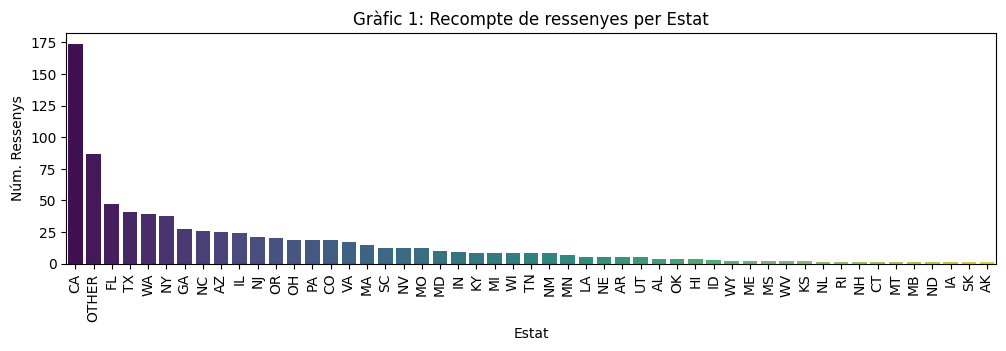

In [35]:
# Create a barplot from quantity of reviews depending of the state
state_counts = starbucks_rev.groupBy("State").count().orderBy(F.desc("count")).collect()
state_counts = pd.DataFrame(state_counts, columns=["State", "Count"])

# Plot
plt.figure(figsize=(12, 3))
sns.barplot(data=state_counts, x="State", y="Count", hue="State", palette="viridis")
plt.xlabel("Estat")
plt.ylabel("Núm. Ressenys")
plt.title("Gràfic 1: Recompte de ressenyes per Estat")
plt.xticks(rotation=90)
plt.show()

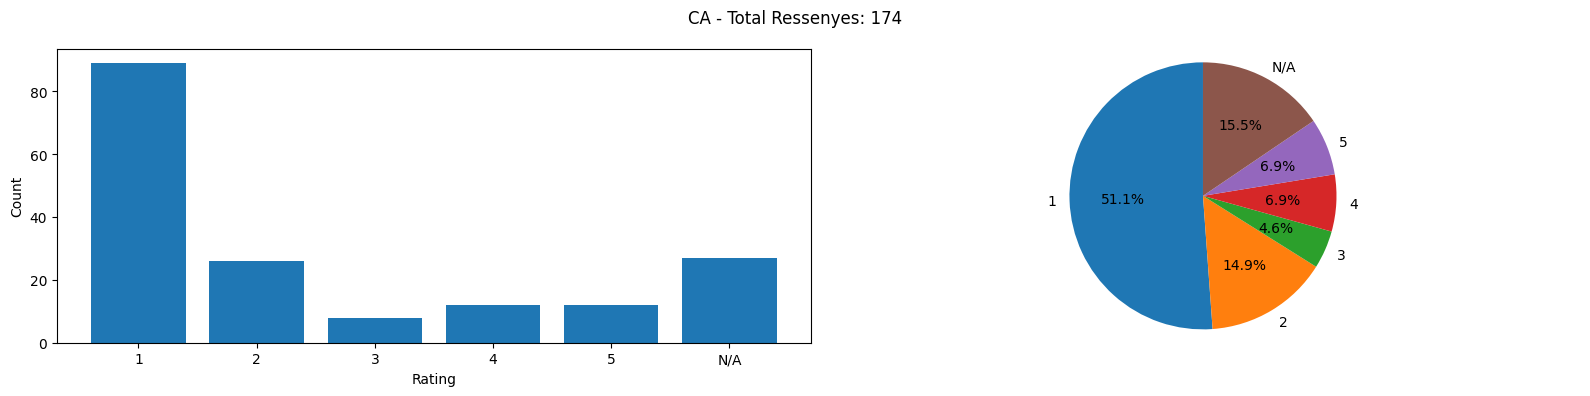

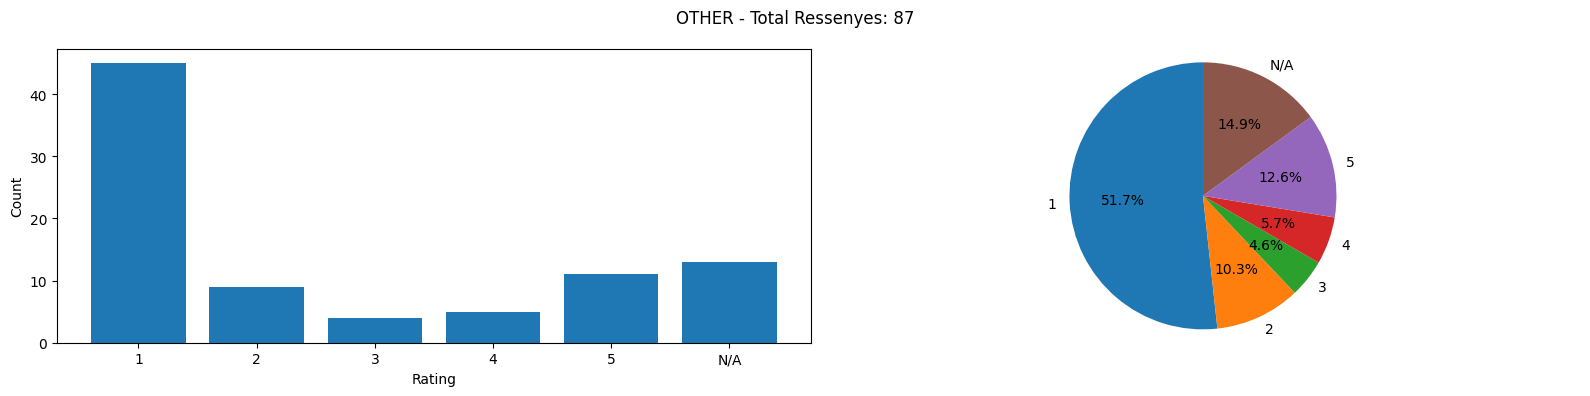

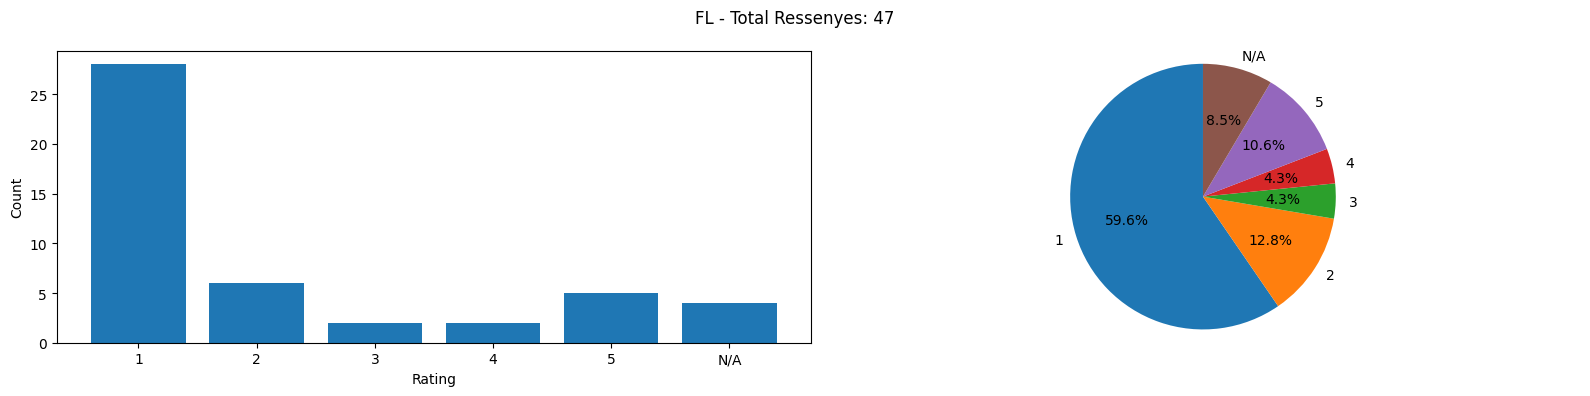

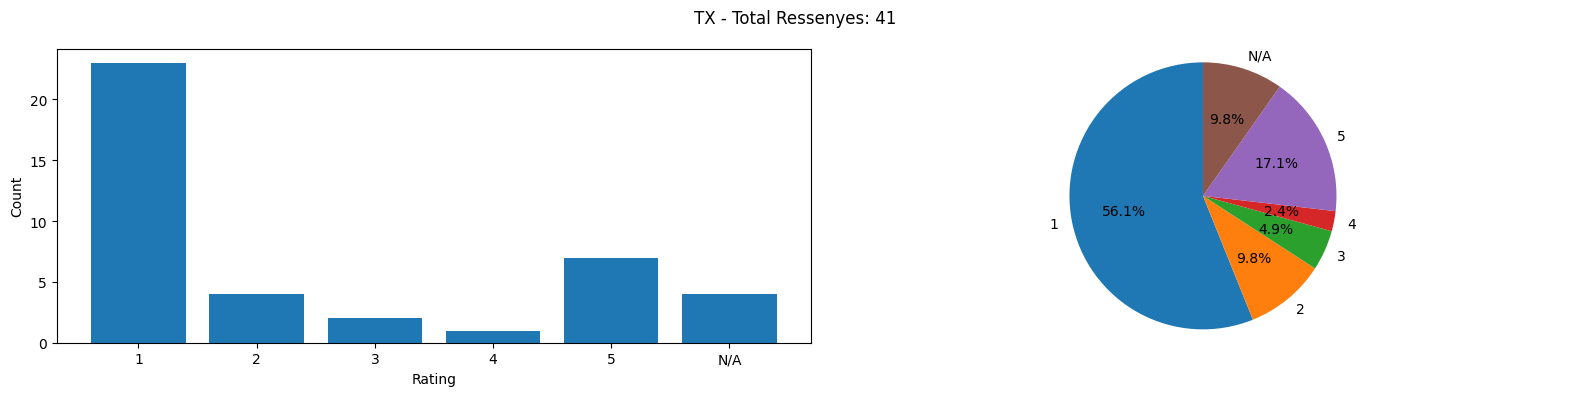

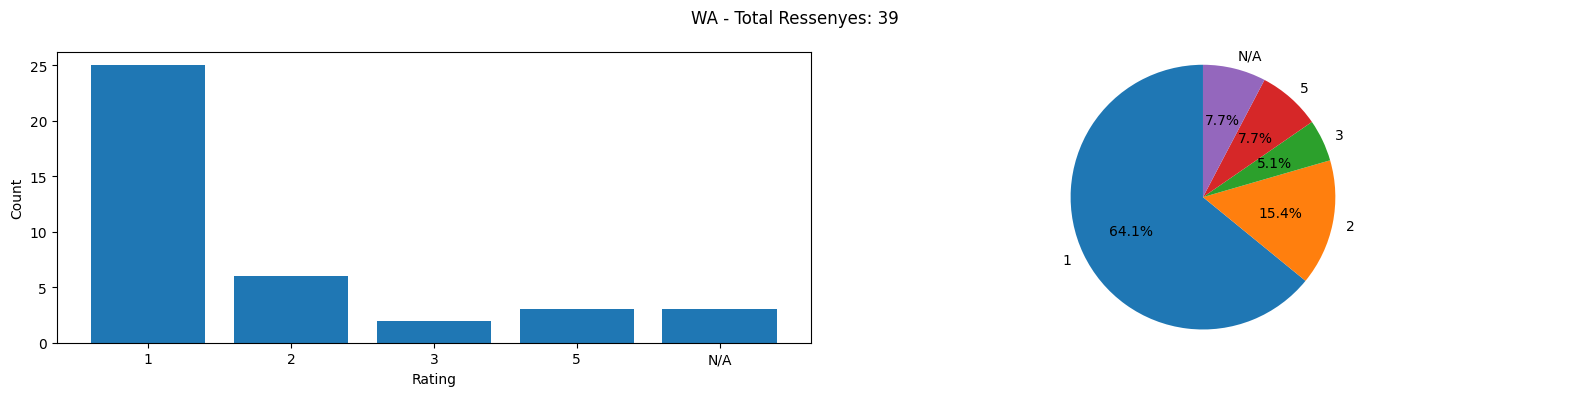

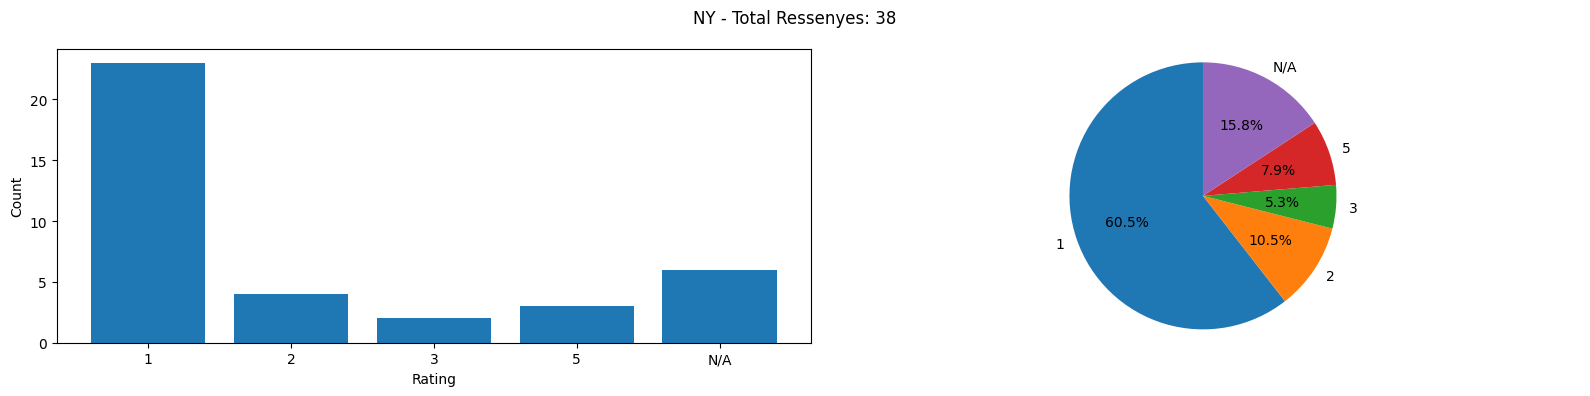

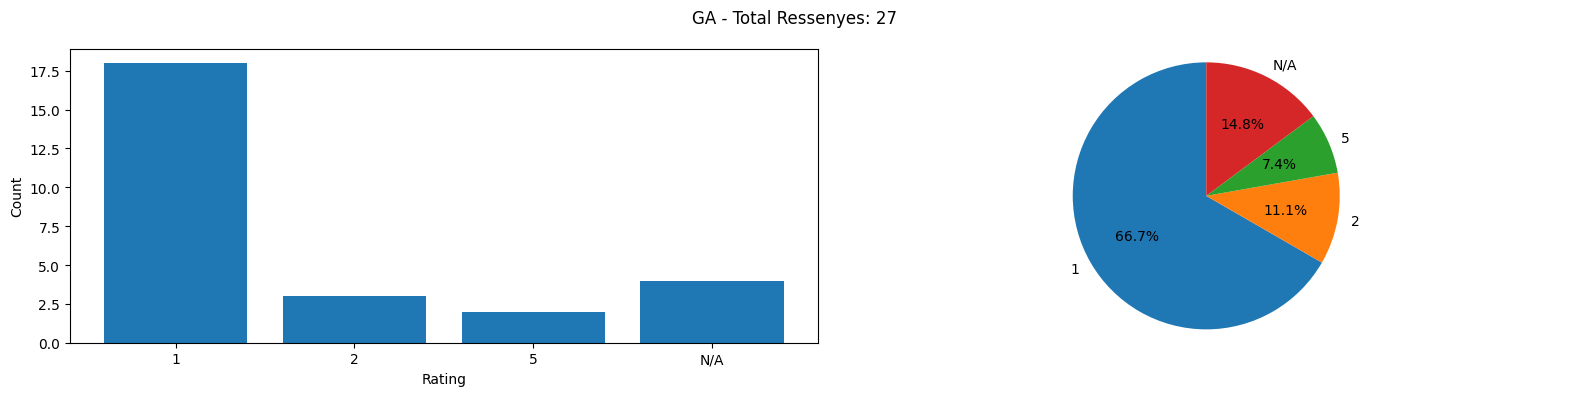

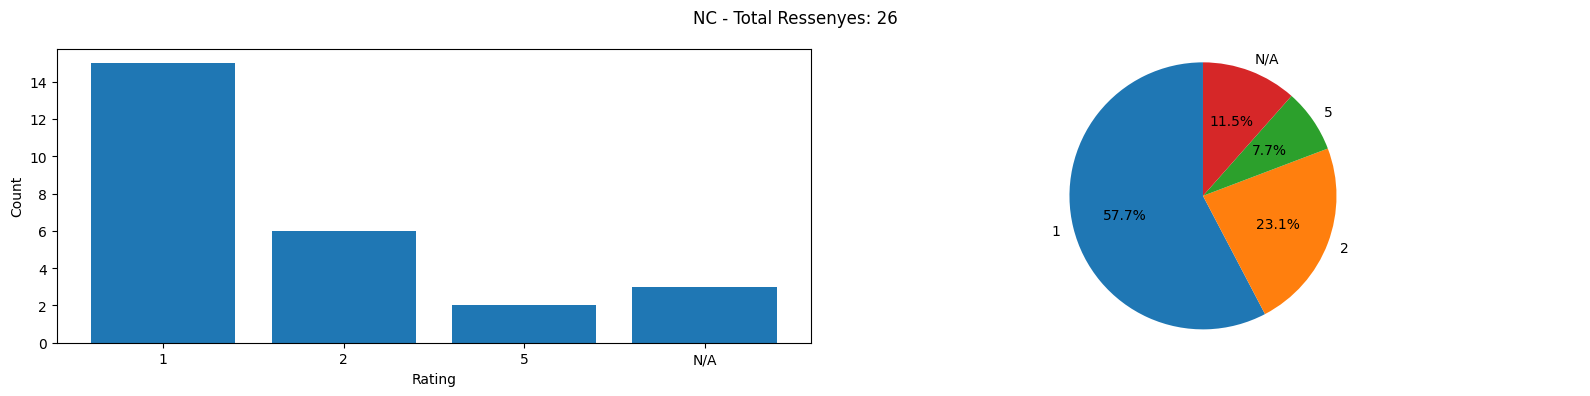

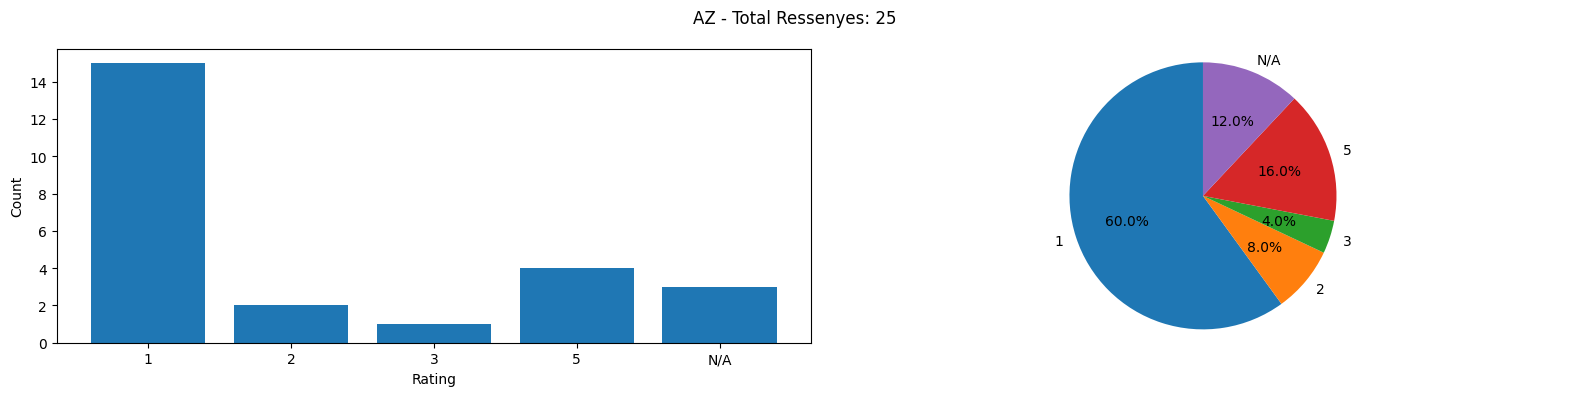

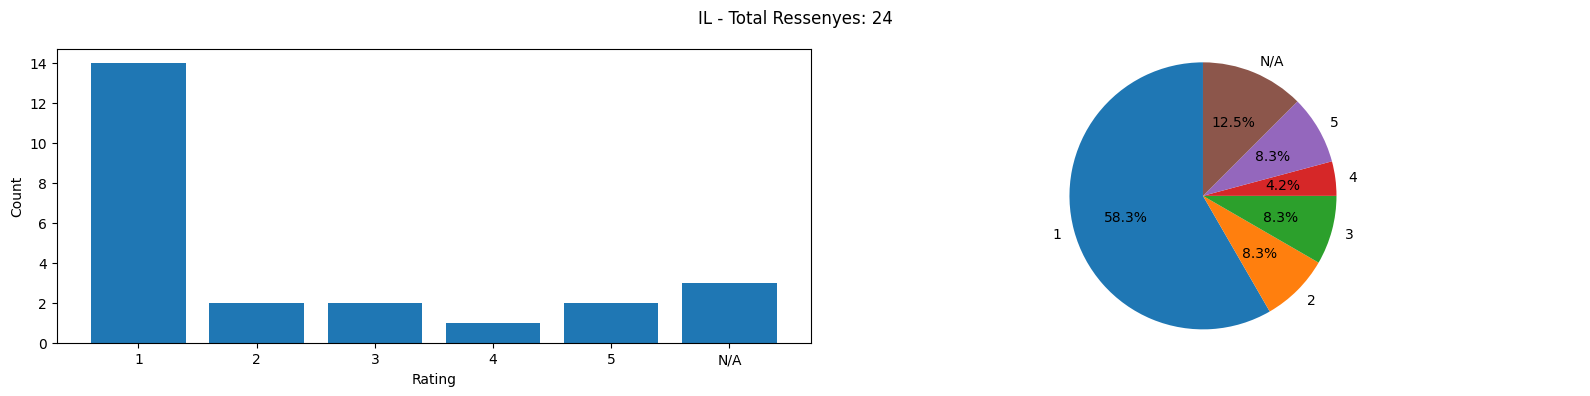

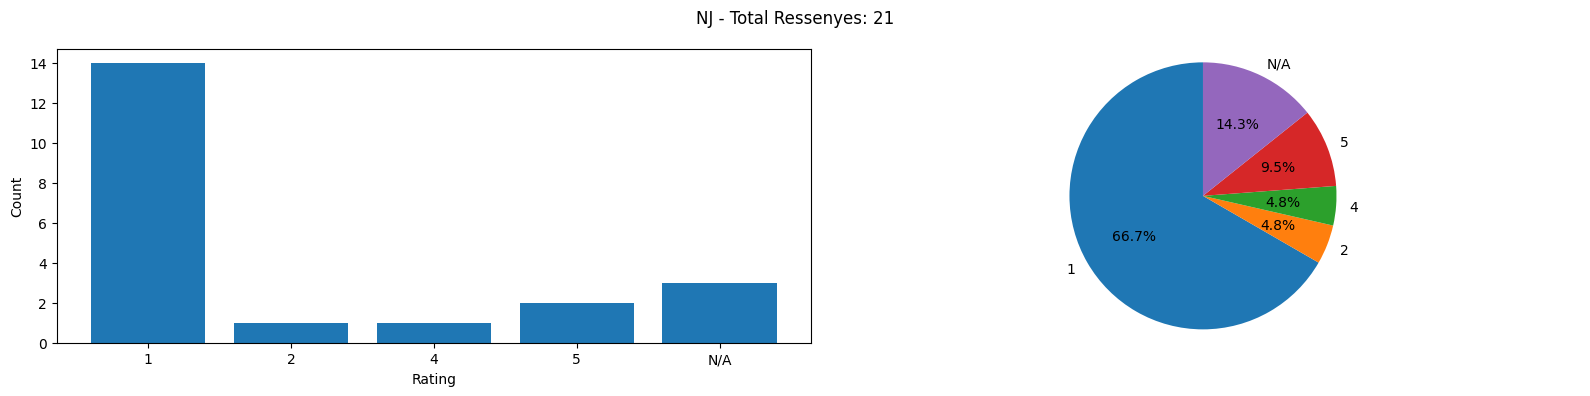

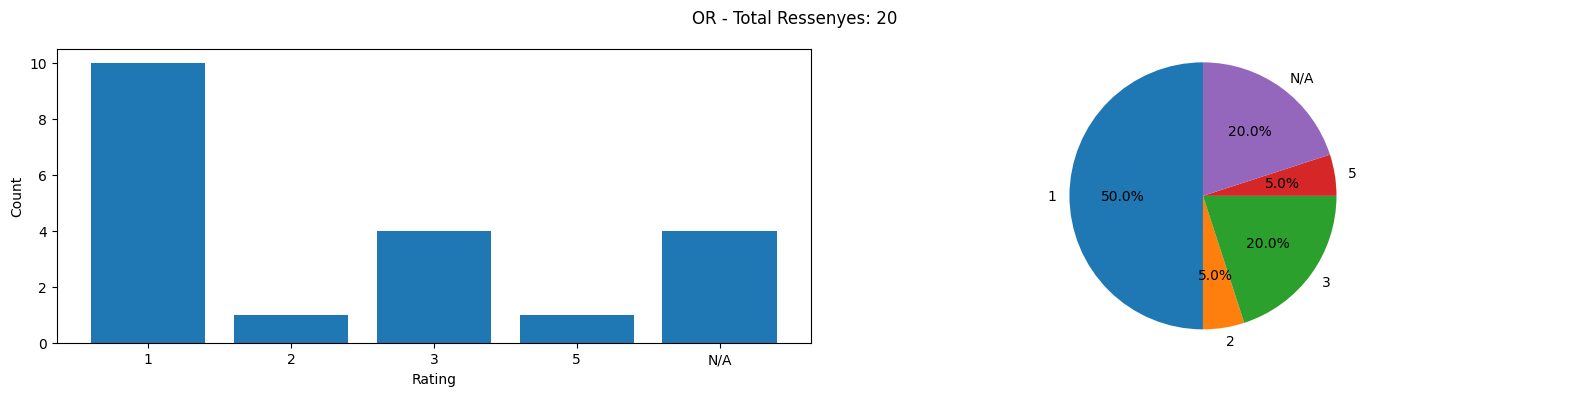

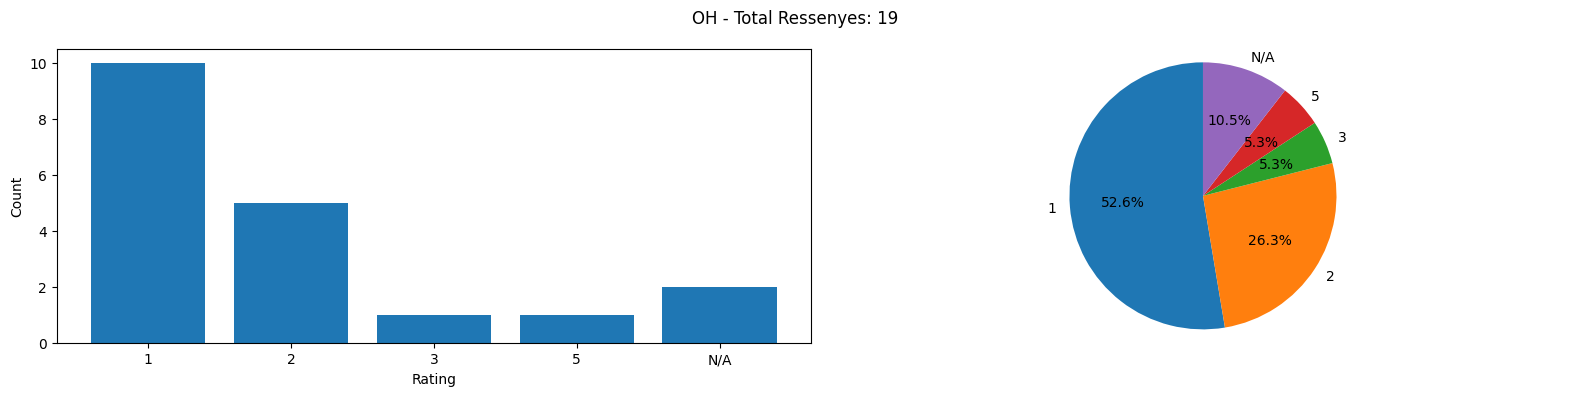

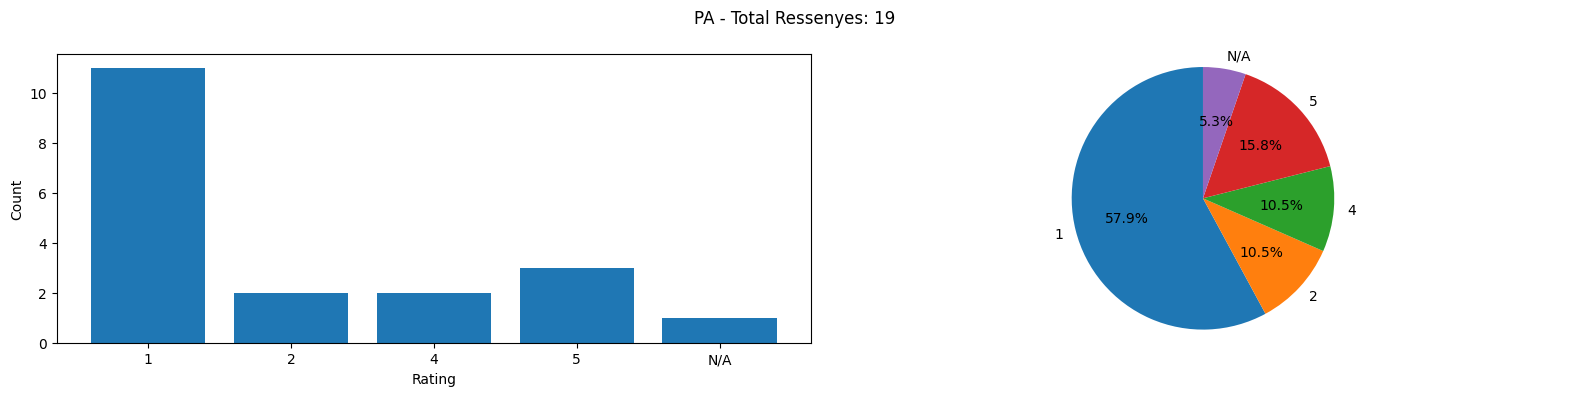

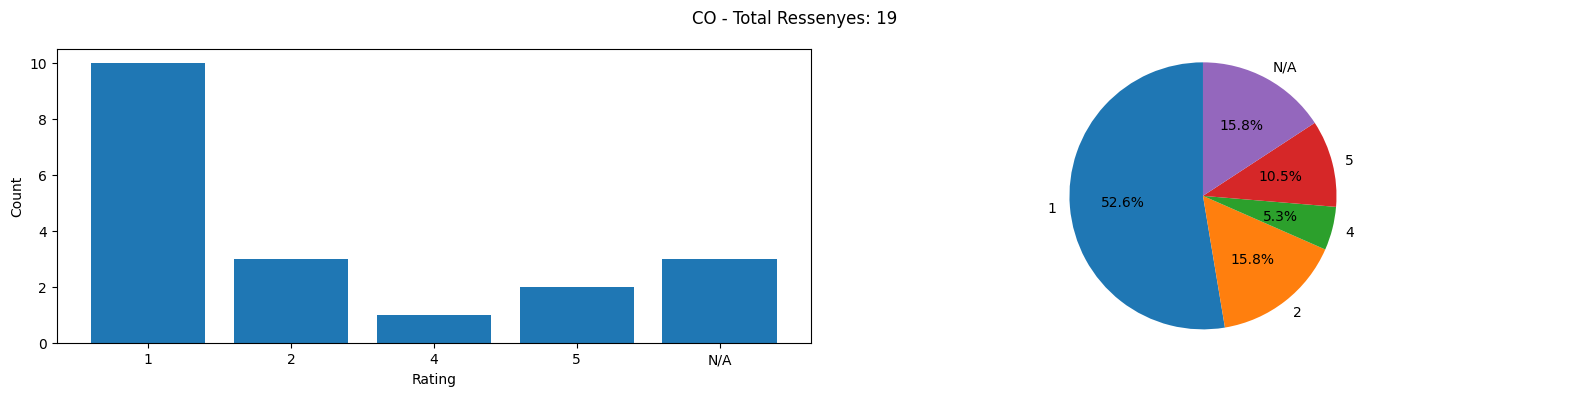

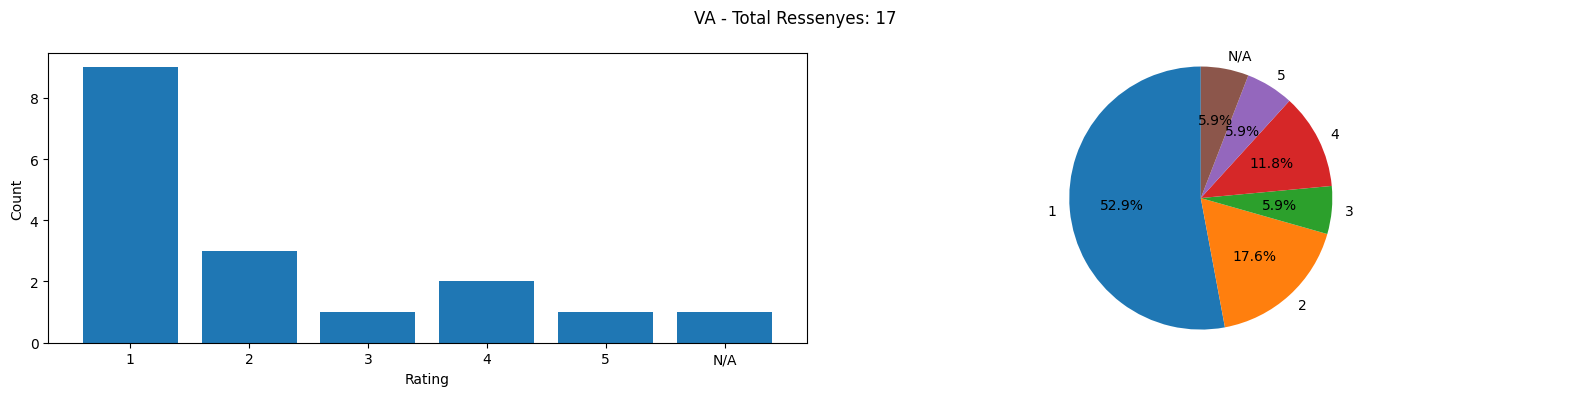

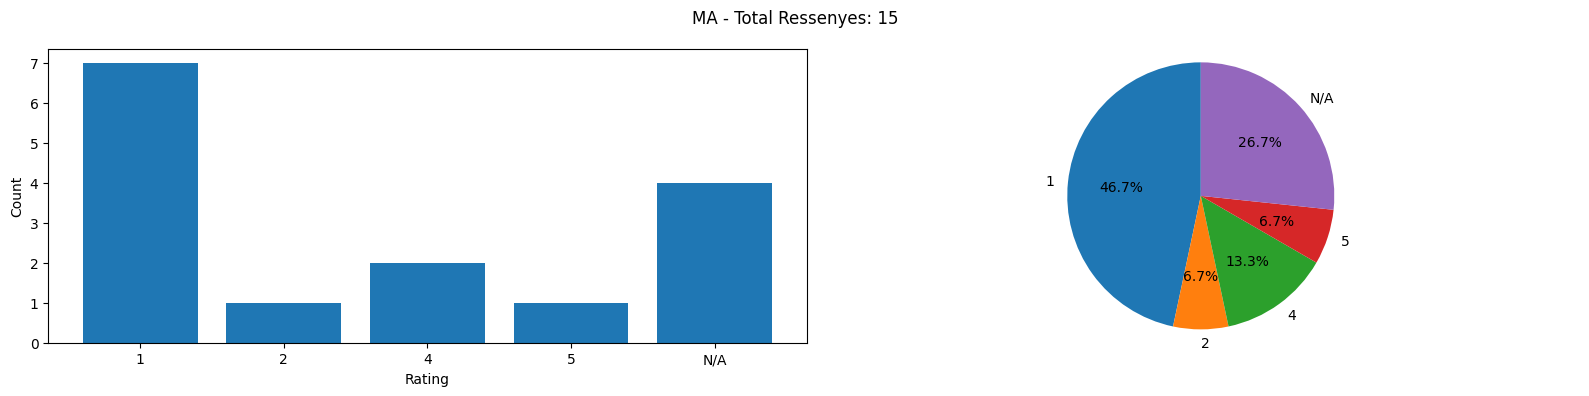

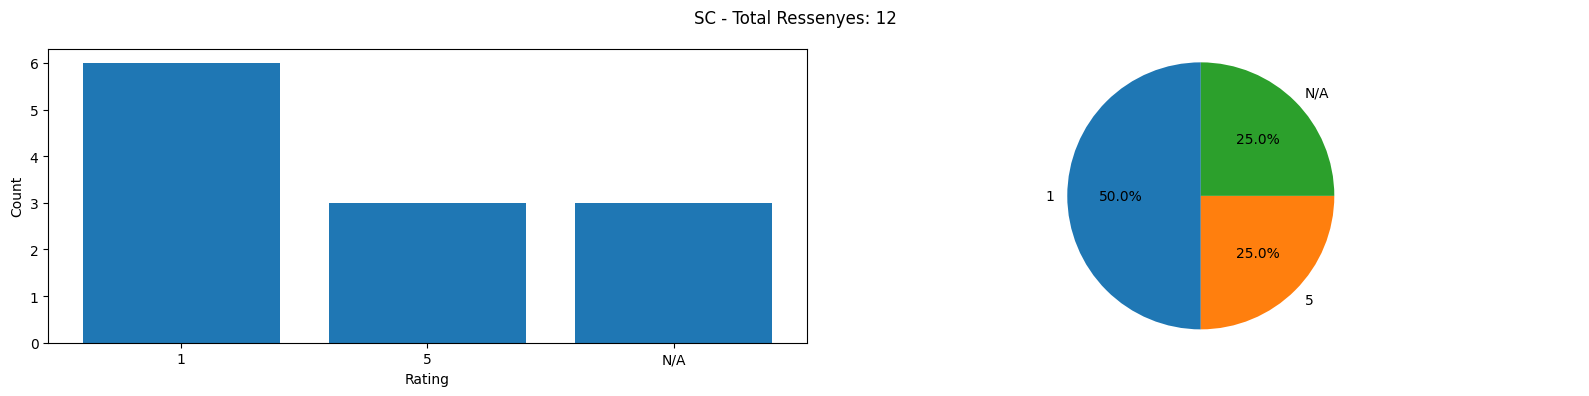

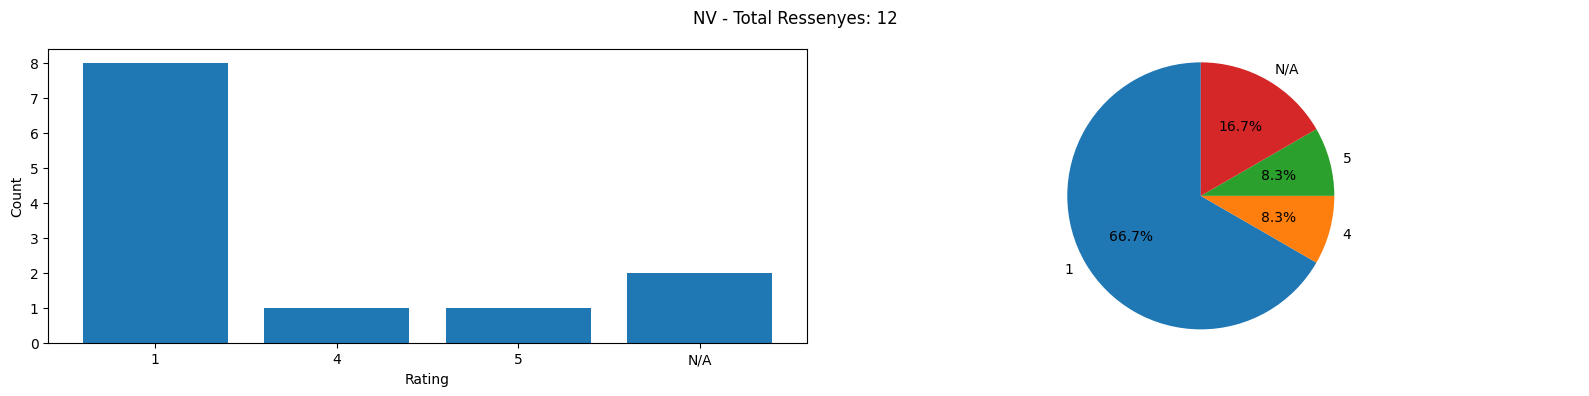

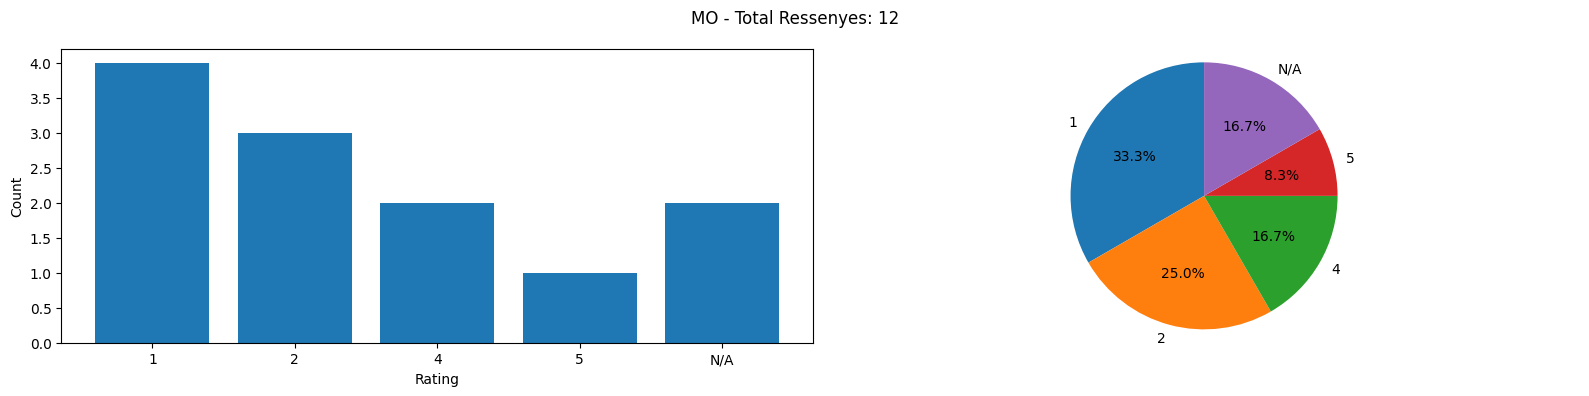

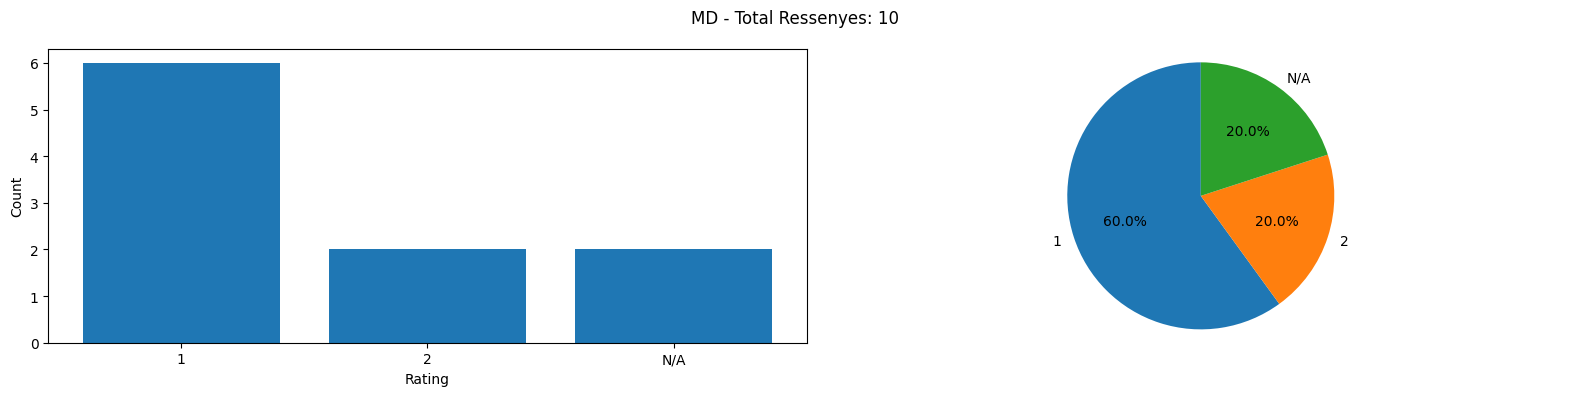

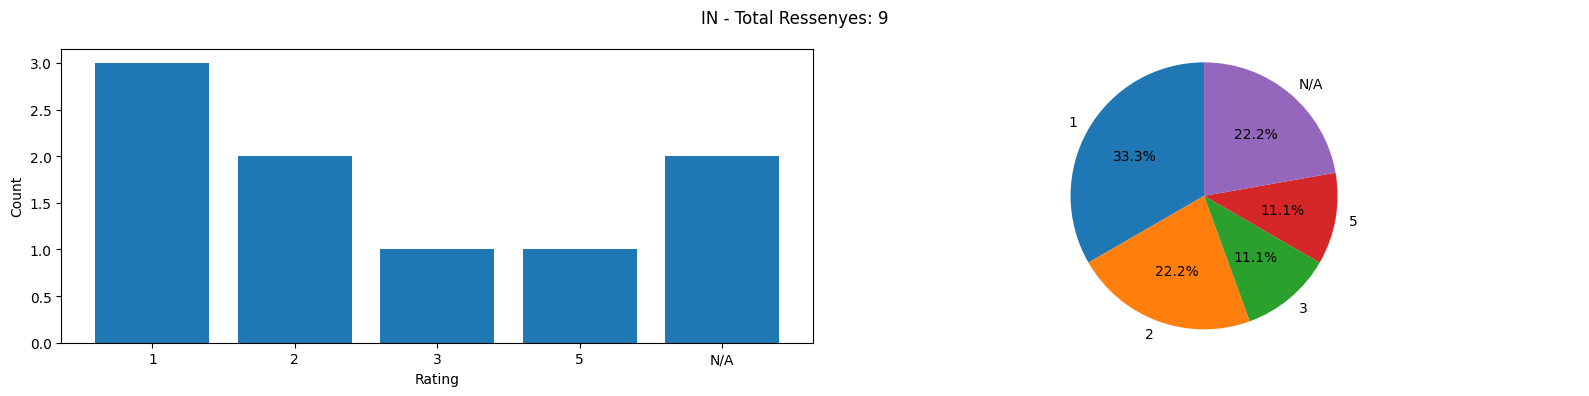

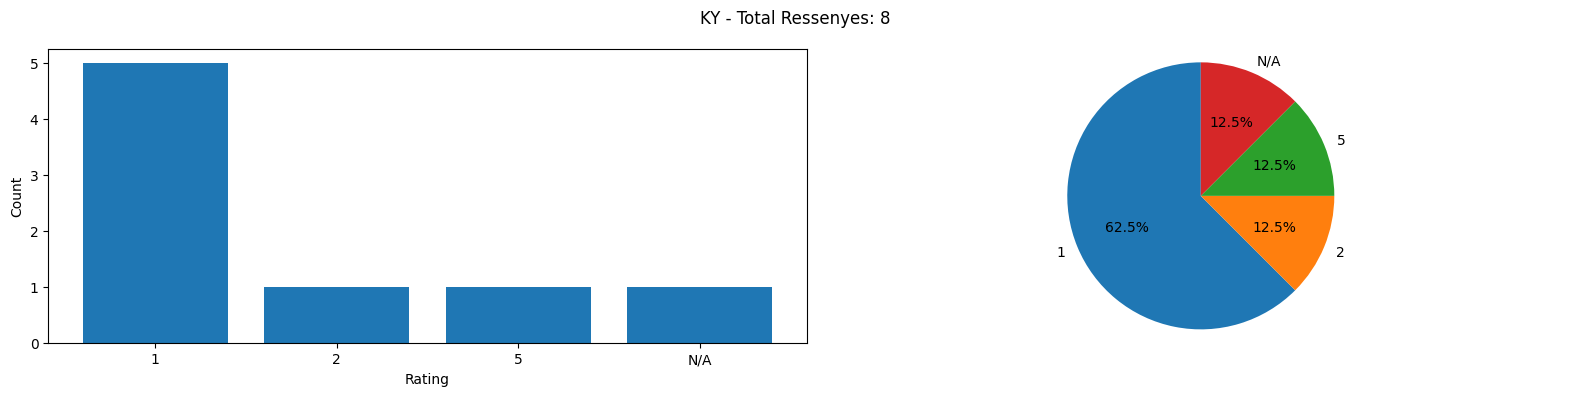

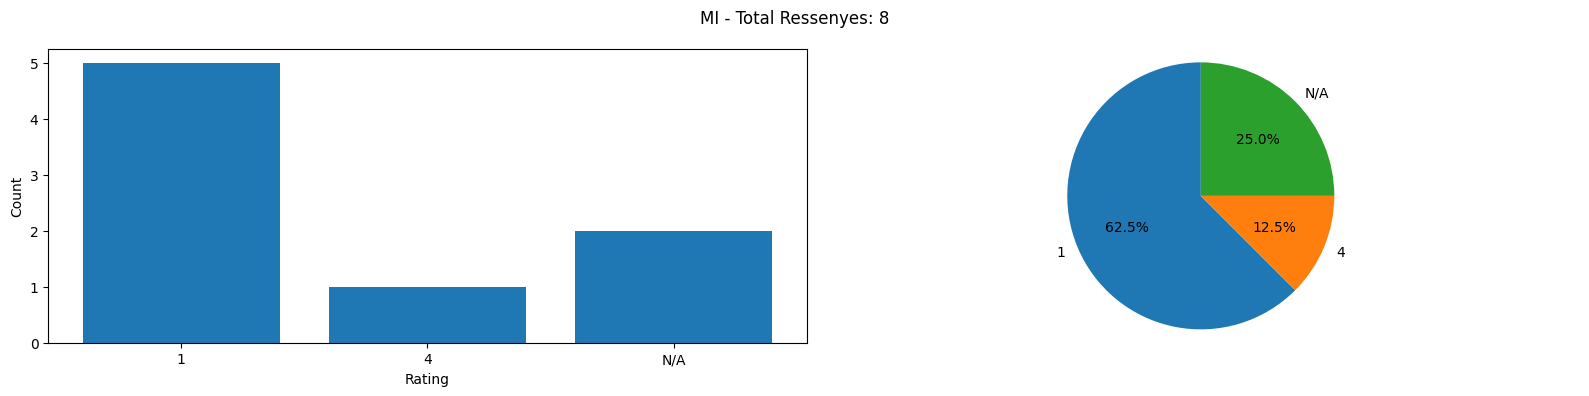

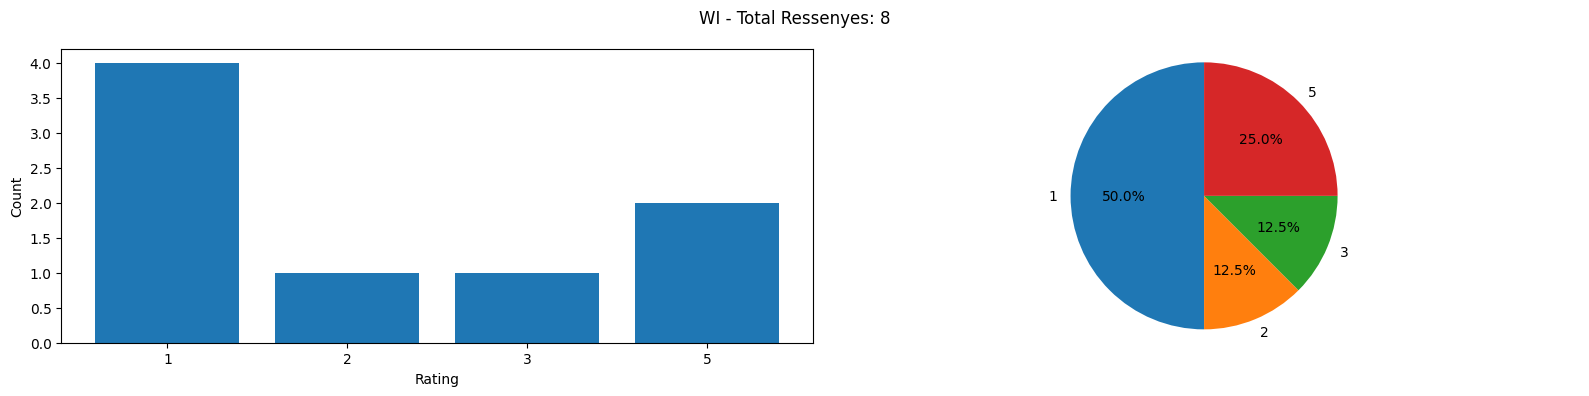

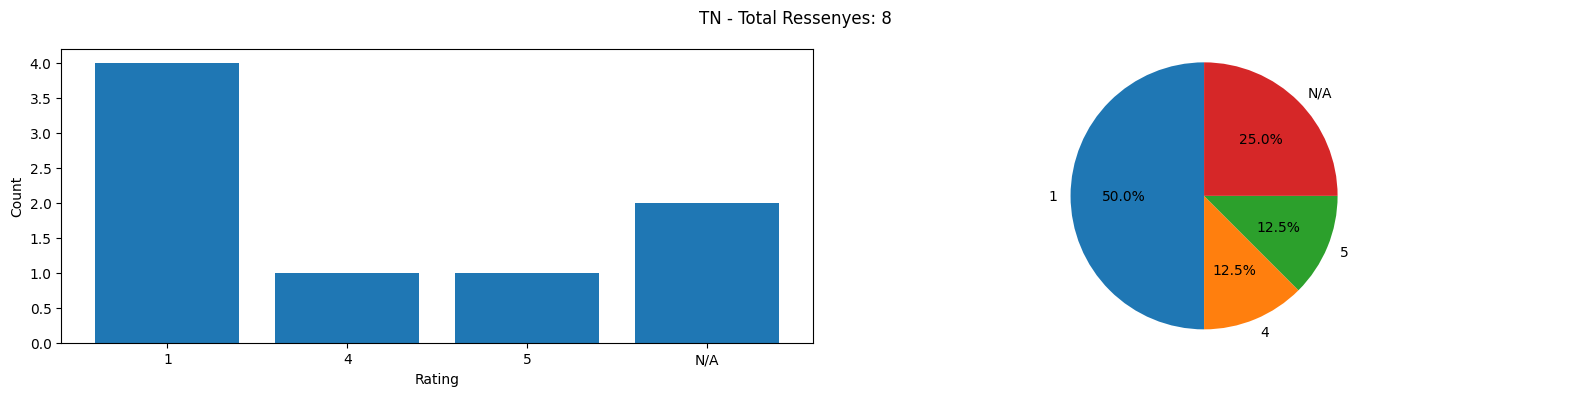

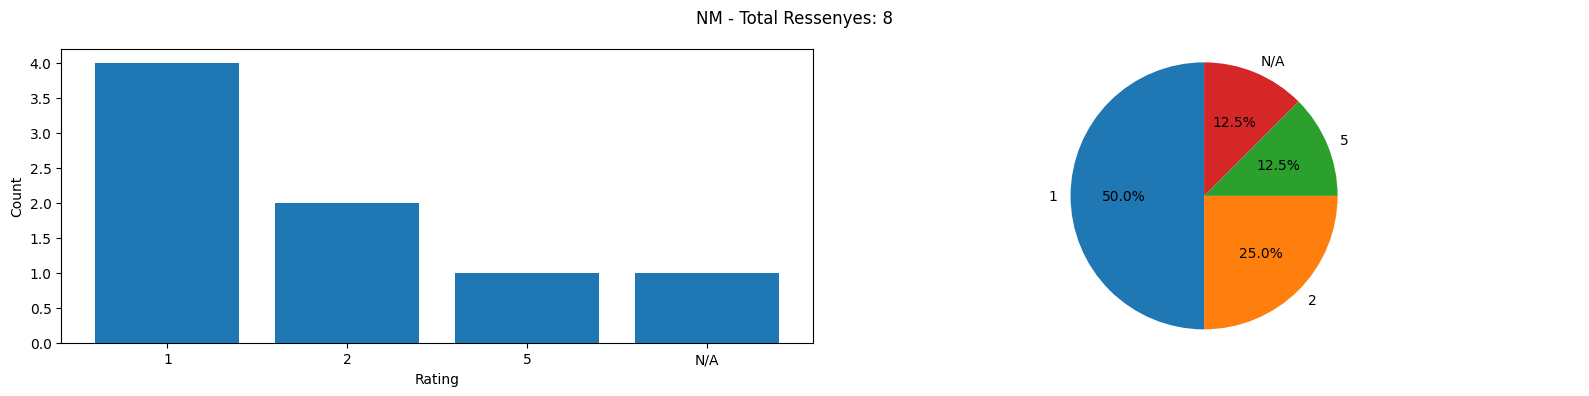

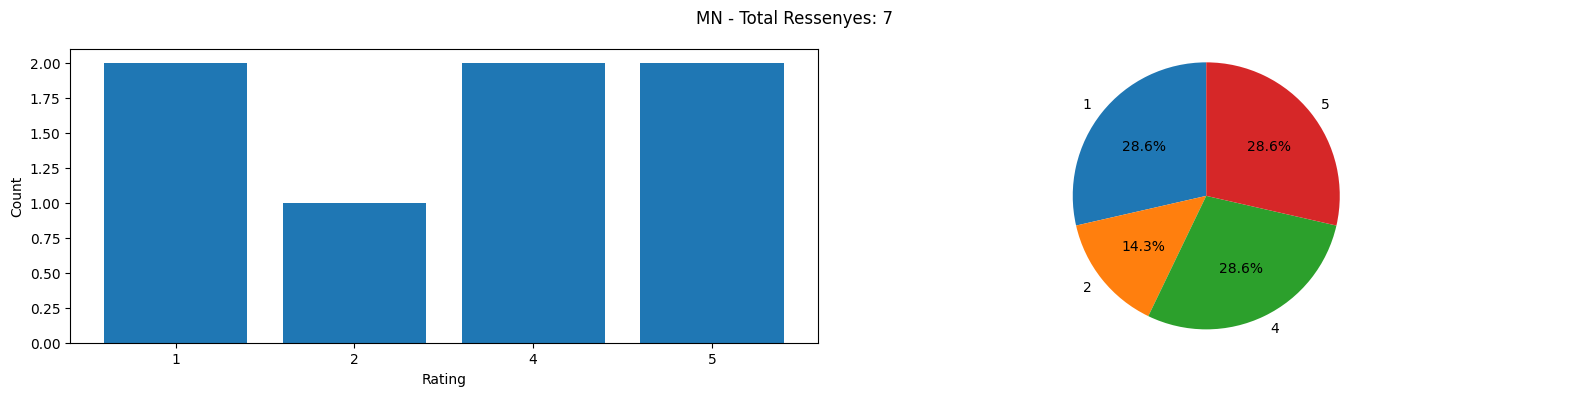

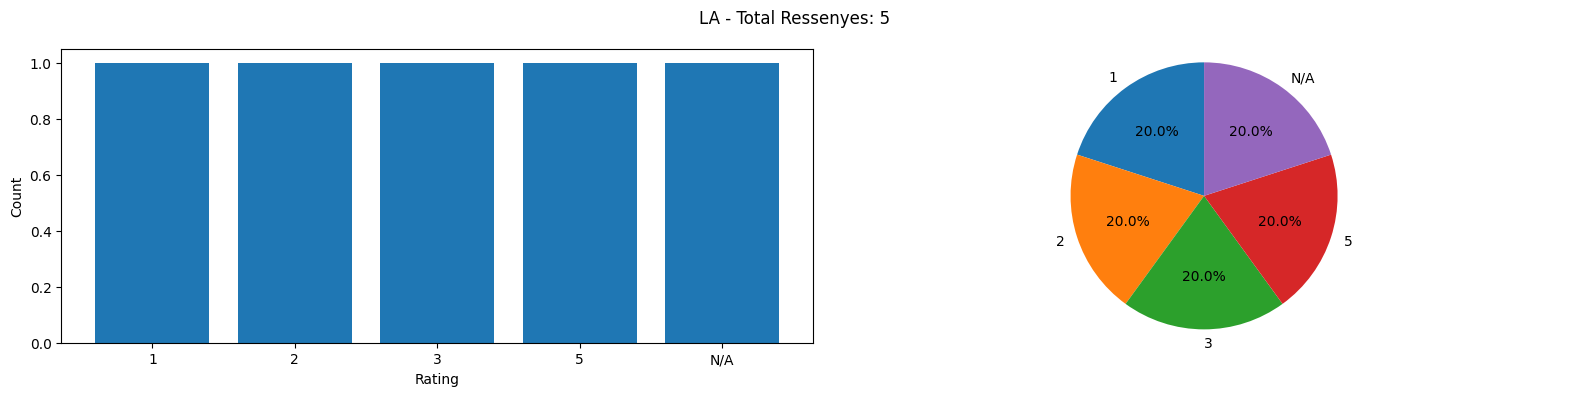

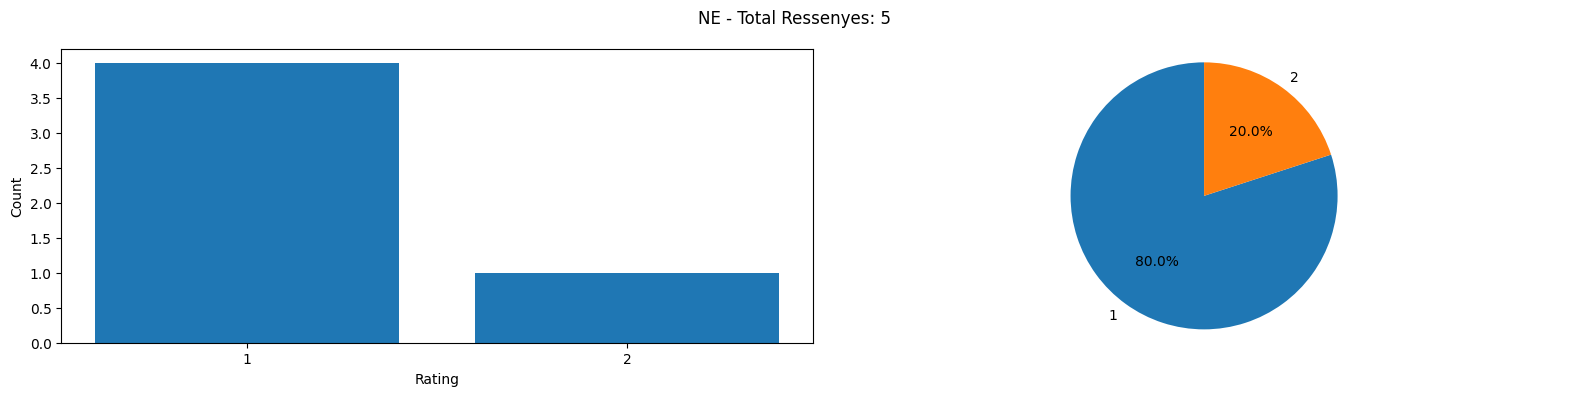

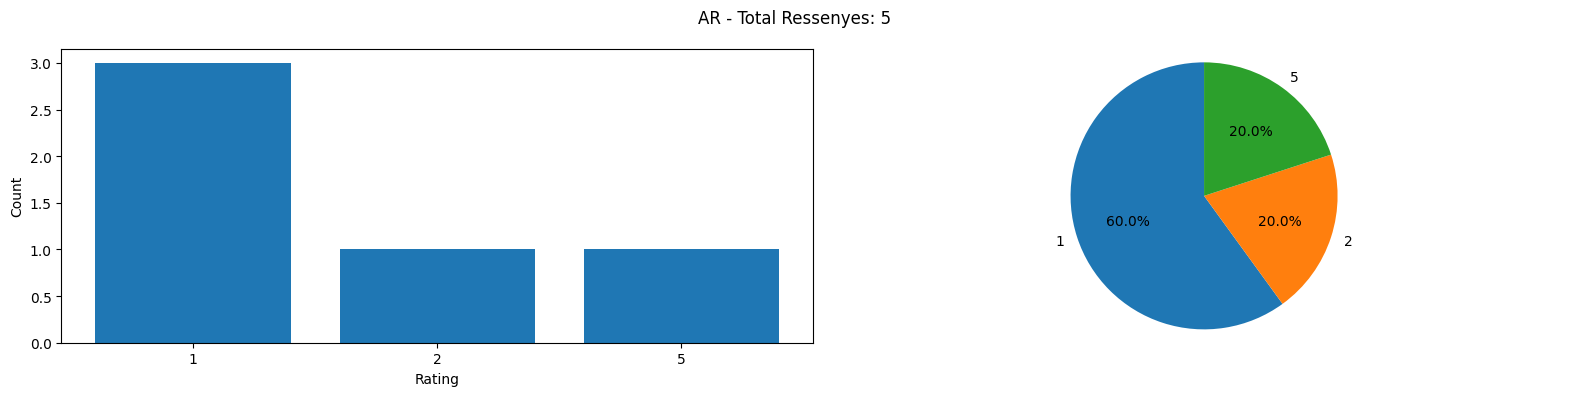

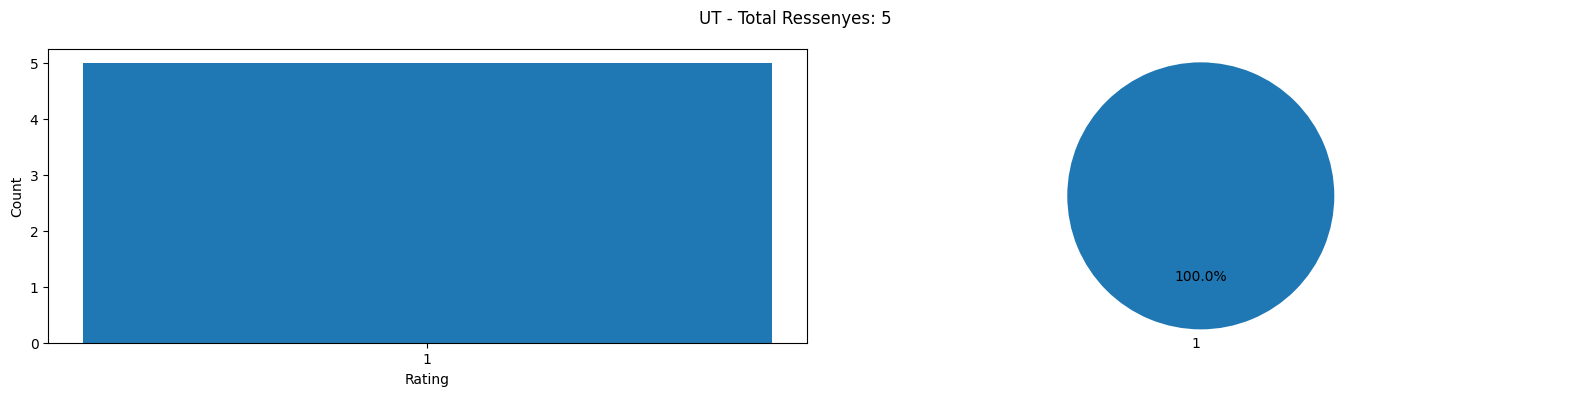

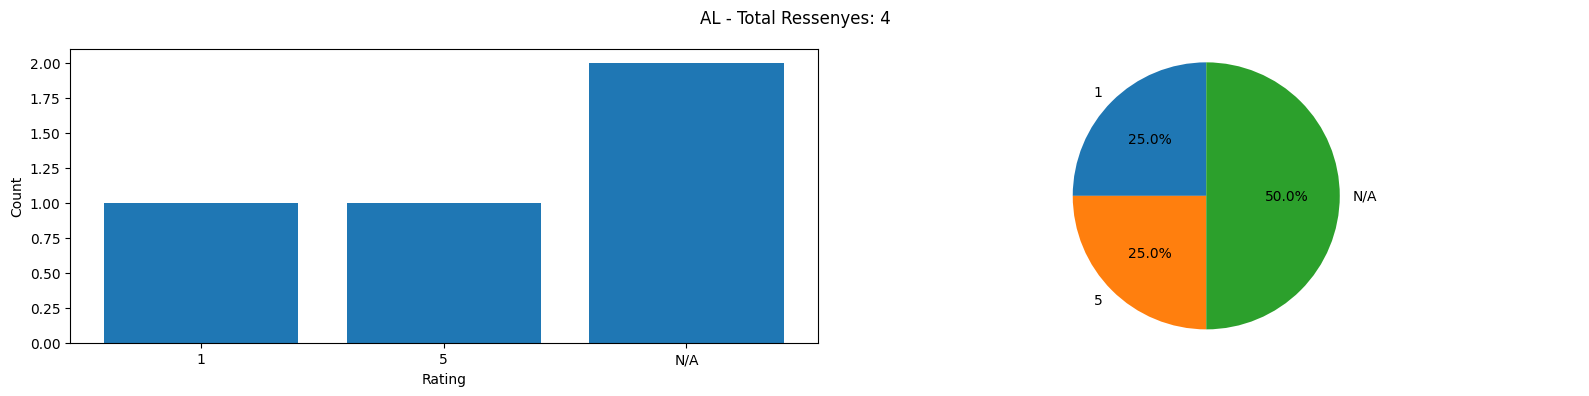

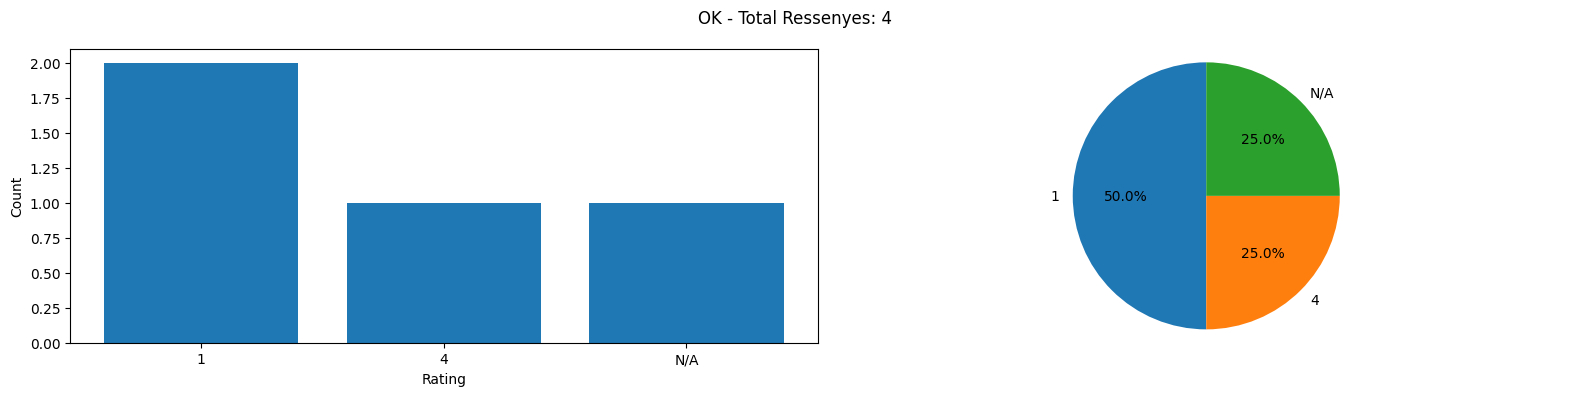

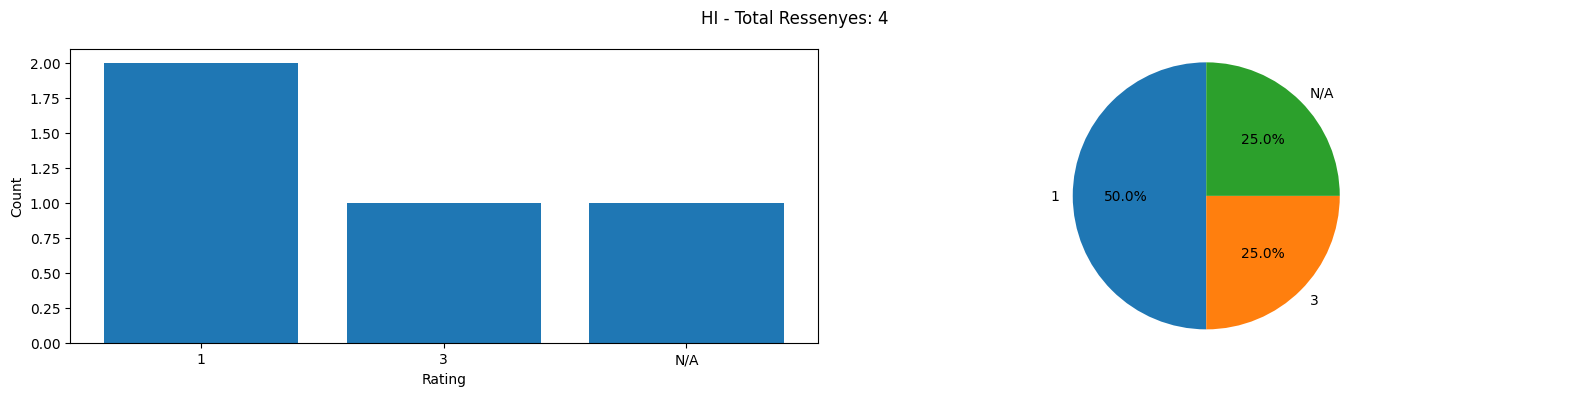

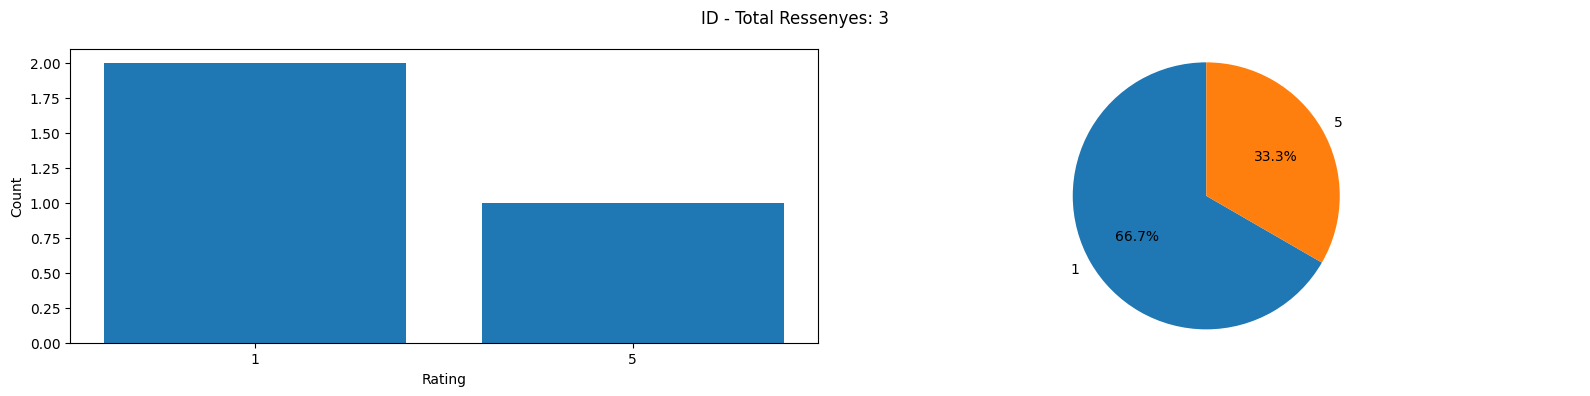

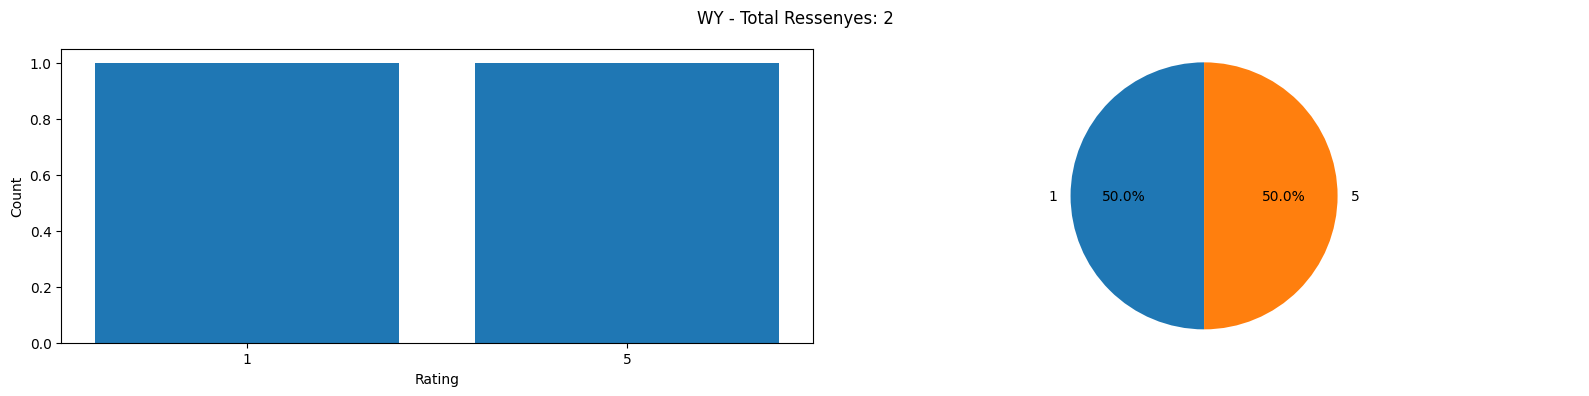

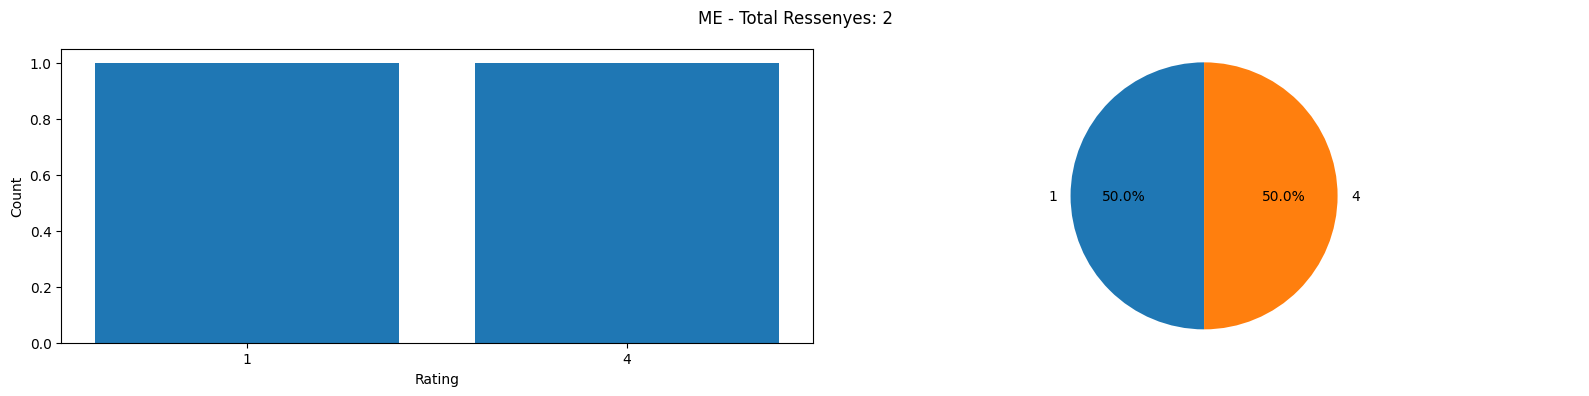

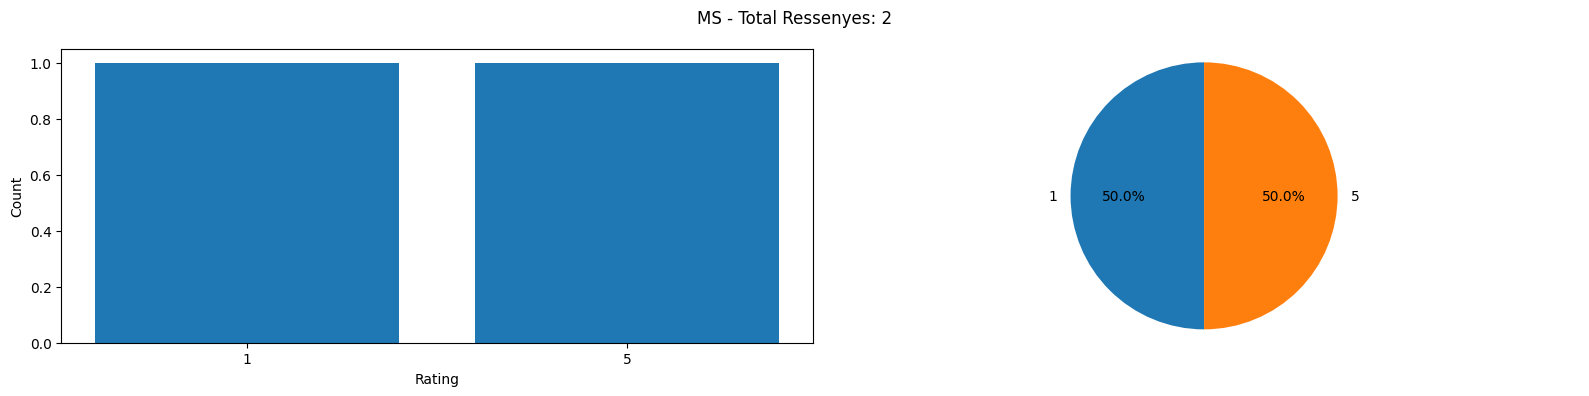

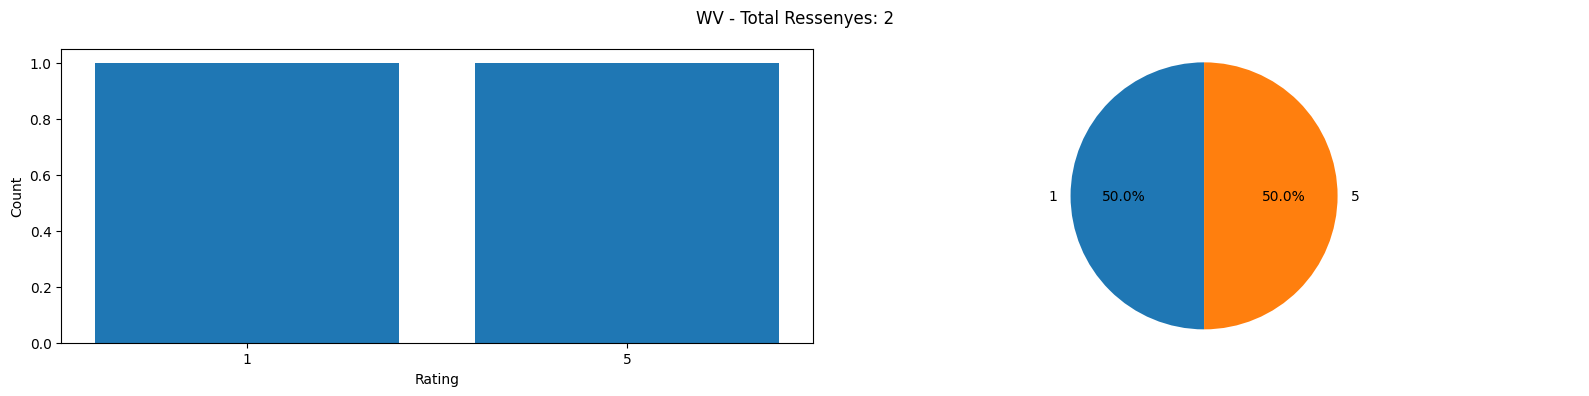

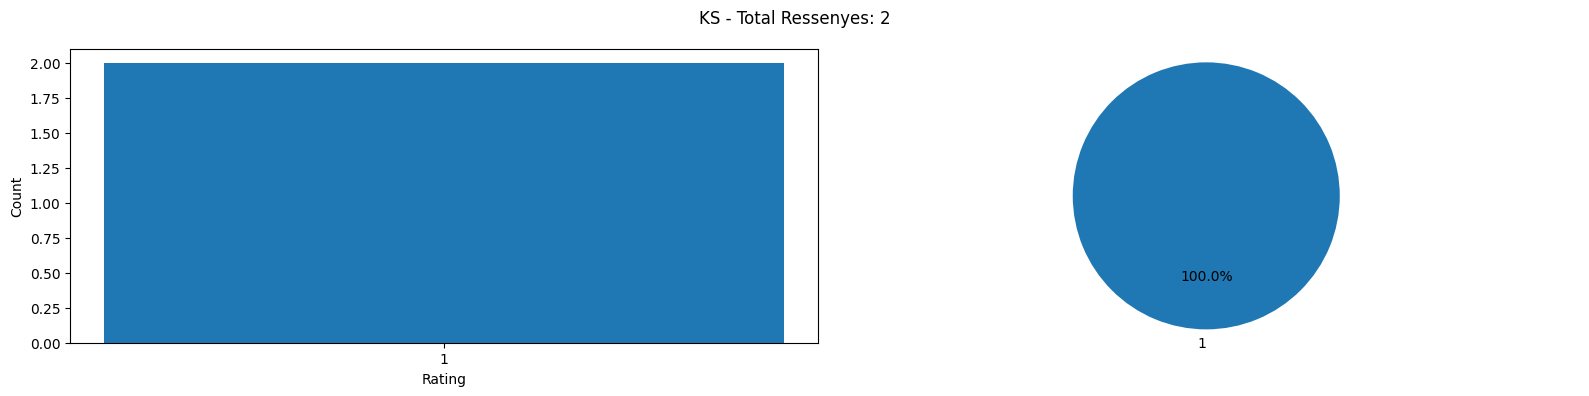

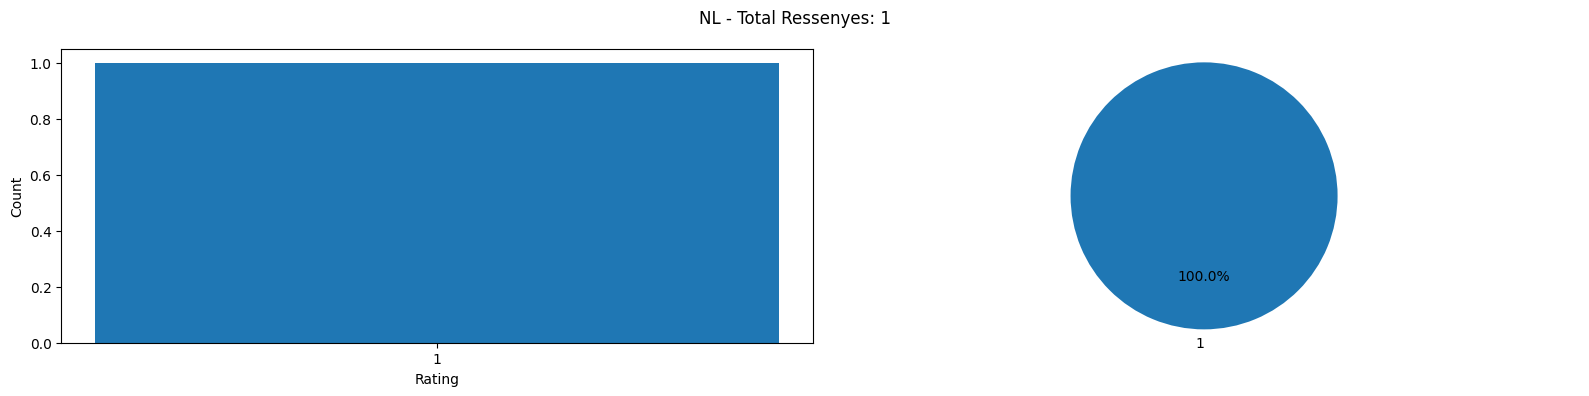

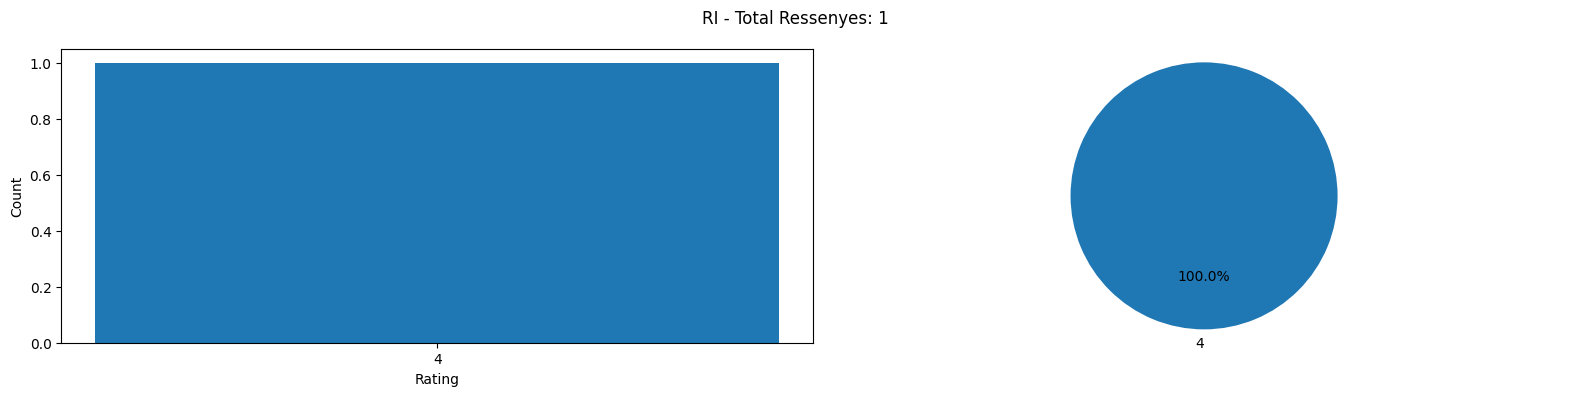

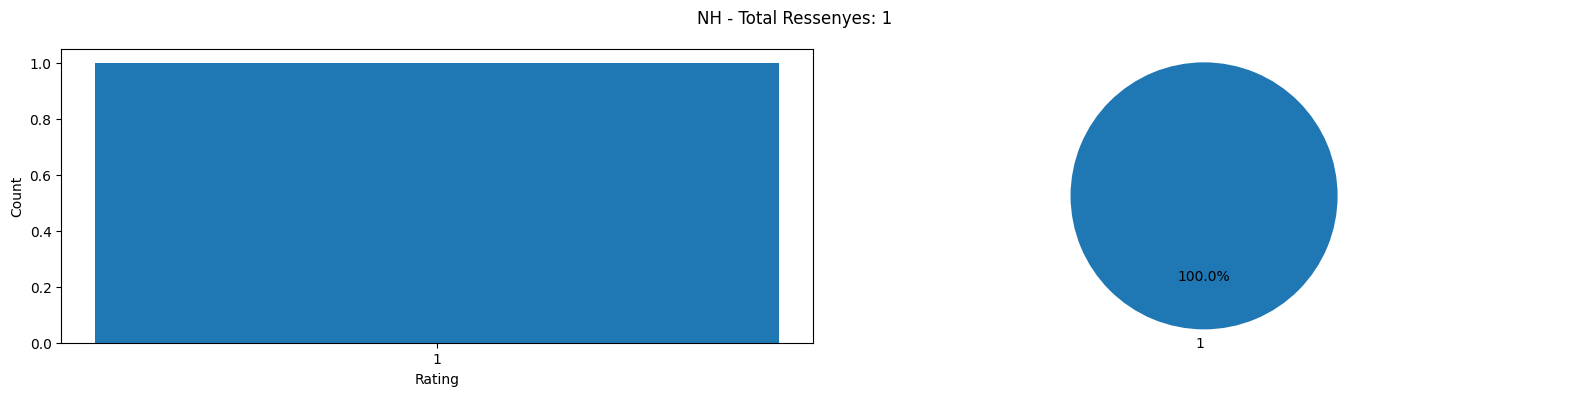

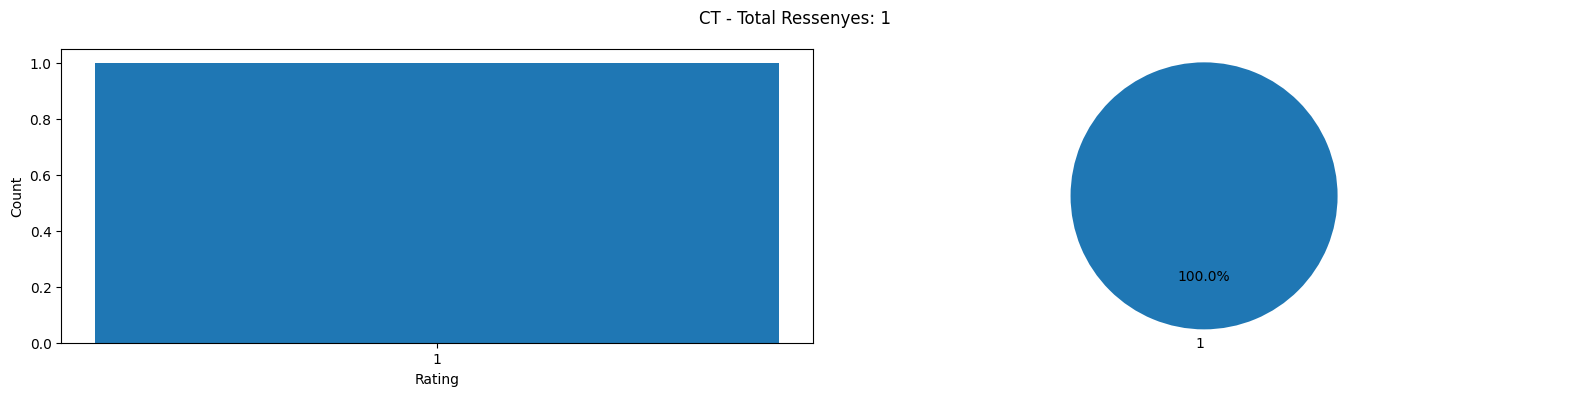

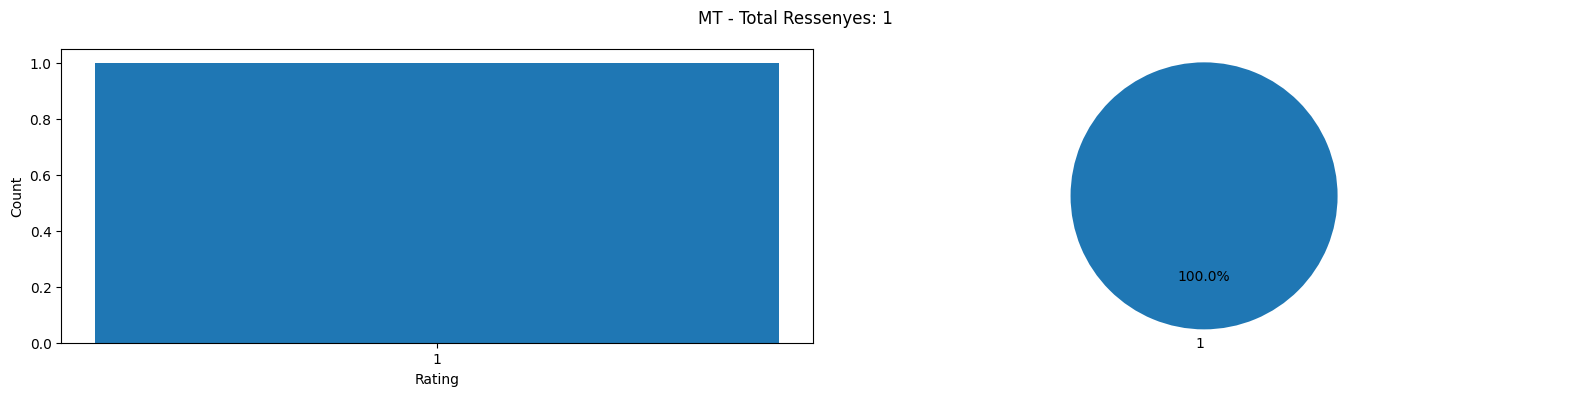

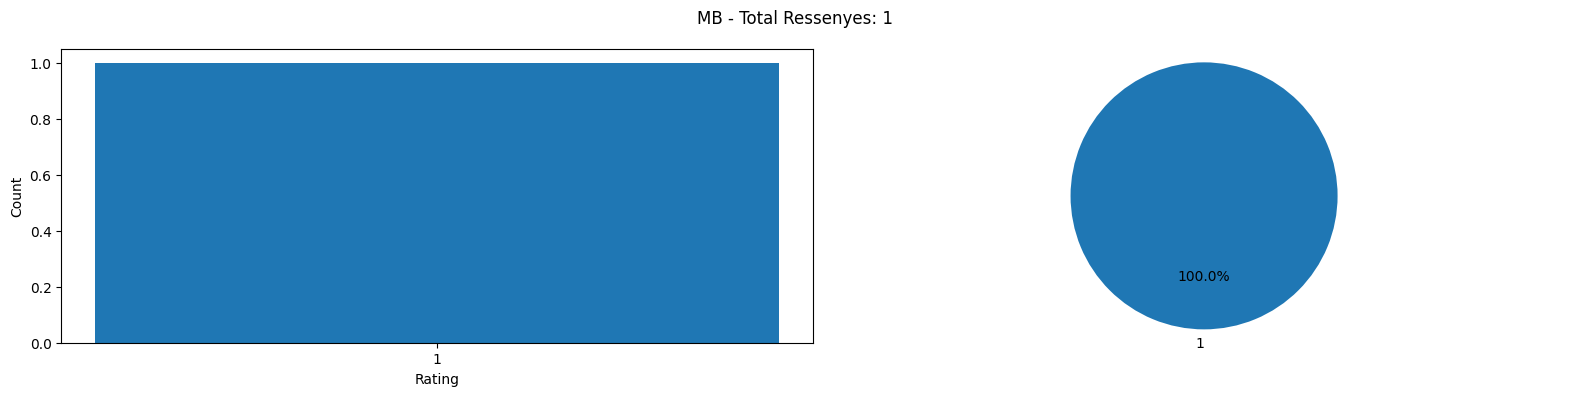

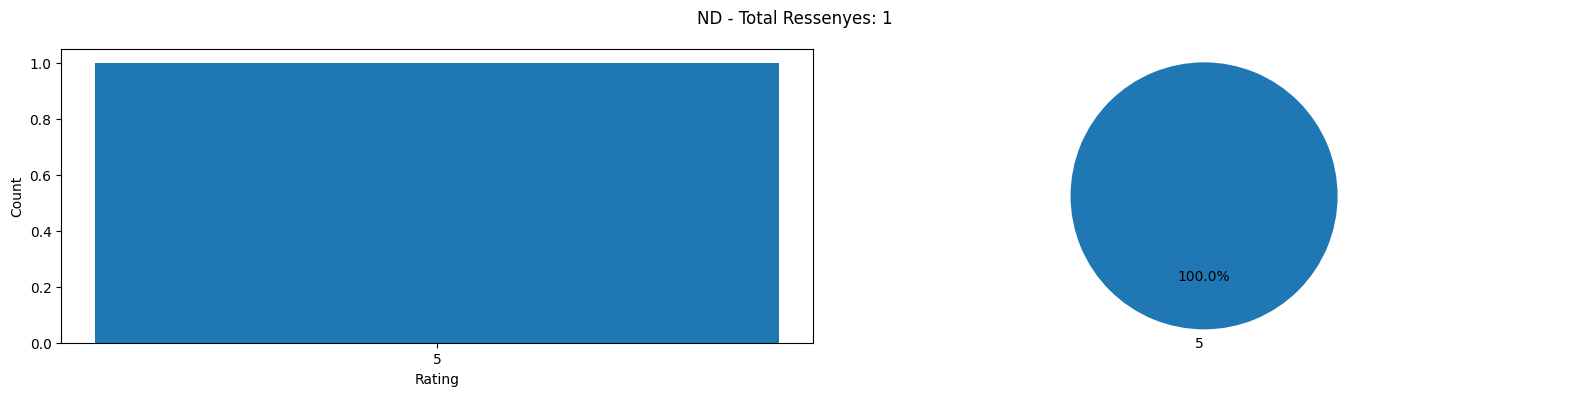

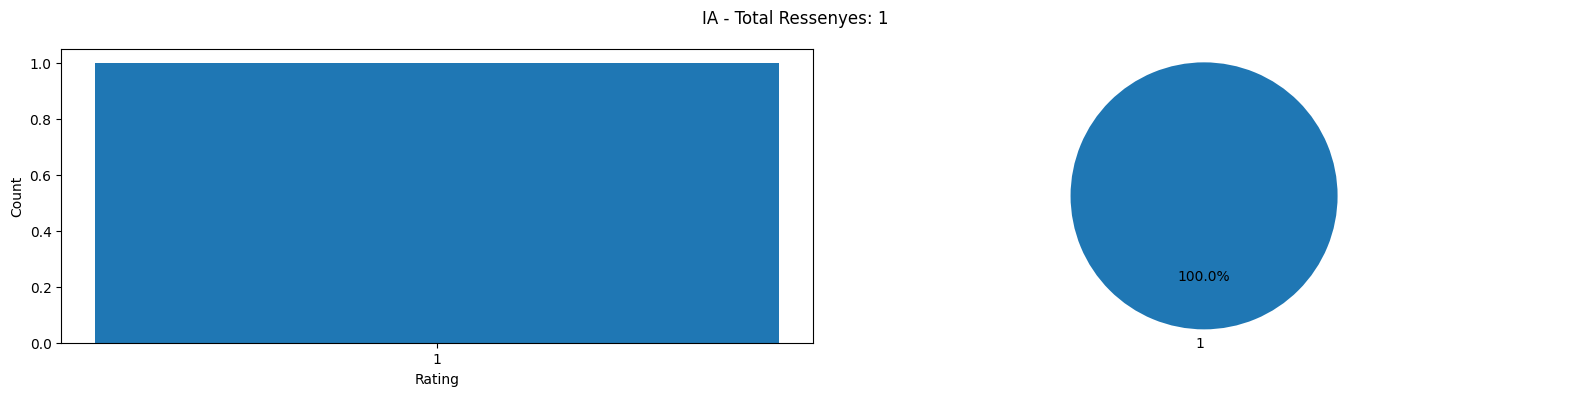

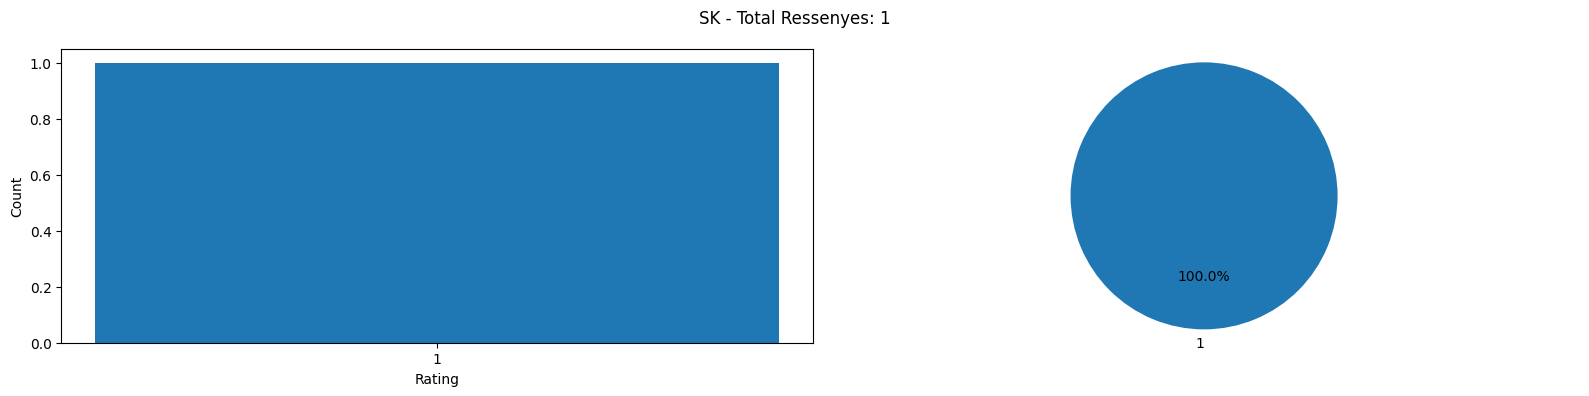

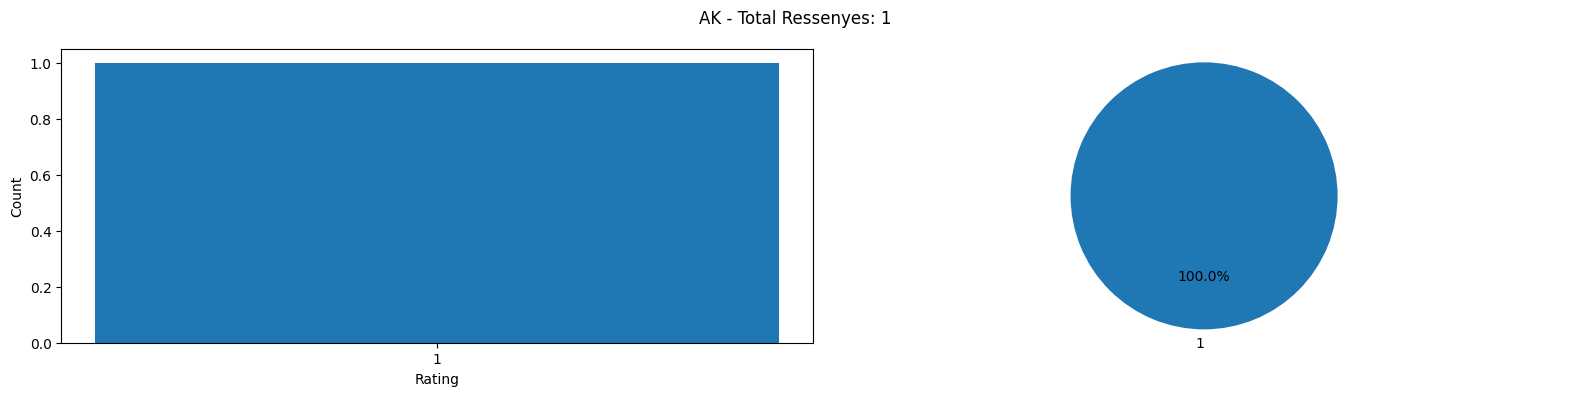

In [36]:
# Create a iterative plots by state (barplot & pieplot of reviews classification and quantity) 
# Create a iterative bucle of states
for state in state_counts["State"]:
    state_data = starbucks_rev.filter(starbucks["State"] == state)
    ratings_counts = state_data.groupBy("rating").count().orderBy("rating").toPandas()

    # Plots code
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    # Barplot
    axes[0].bar(ratings_counts["rating"], ratings_counts["count"])
    axes[0].set_xlabel("Rating")
    axes[0].set_ylabel("Count")

    # Pie plot
    labels = ratings_counts["rating"]
    sizes = ratings_counts["count"]
    axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[1].axis('equal')  
    
    plt.suptitle(f"{state} - Total Ressenyes: {state_data.count()}")
    plt.tight_layout()
    plt.show()

### Observacions
___
**Gràfic 1: Recompte de ressenyes per Estat**
> 1. Veiem que hi ha moltes més ressenyes de California que qualsevol altre estat, inclús més que la suma de ressenyes que no son de USA.
> 2. Podriem extrapolar número de starbucks per ciutat, número d'habitants per estat i fer altrers comperacions. De totes maneres aquest gràfic ens mostra una imatge base per fer-nos una primera idea.

**Gràfic 2: Distribució de la puntuació de les ressenyes per cada estat**
> 1. Podemos comprobar que la distribución de las resseñas es bastante uniforme con indiferencia del número y estado con alguna excepción.
> 2. Vemos que predemoninan las reseñas negativas en casi siempre un 50% con algúna excepción como LA, MN, IN, MO... que la distribución esta mas pareja. Así que podemos concluir que en general se hacen mas reseñas negativas que positivas.
> 3. Podriamos investigar los starbucks que tienen mejor valoración si encontramos algún patrón distinto. Ya que al ver que la mayoria tienen una distribución normal a pesar de tener pocas reseñas podemos encontrar algún factor diferencial.
> 4. El barplot me va bien para ver la cantidad de reseñas de cada una, y el pieplot para ver la distribución de ellas. 

>     b) Veure com es comporten per dies de la setmana, trimestres i anys. 

In [37]:
# Refresh unique values of Day column (to know how are they writen)
print(starbucks_rev.select("Day").distinct().rdd.map(lambda row: row[0]).collect())

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']


In [38]:
# Canges the strings to make easer to follow the week order
changes = {"Mon": "1-Mon", "Tue": "2-Tue", "Wed": "3-Wed", "Thu": "4-Thu", "Fri": "5-Fri", "Sat": "6-Sat", "Sun": "7-Sun"}

for day, replacement in changes.items():
    starbucks_rev = starbucks_rev.withColumn("Day", regexp_replace(starbucks_rev["Day"], day, replacement))

starbucks_rev.show(5)

+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+
|    Name|       Cities|State| Year|Month|Month_Day|  Day|Rating|Images|              Review|
+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+
|   Helen|Wichita Falls|   TX| 2023|   09|       13|3-Wed|     5|     0|Amber and LaDonna...|
|Courtney|       Apopka|   FL| 2023|   07|       16|7-Sun|     5|     0|** at the Starbuc...|
|Daynelle|Cranberry Twp|   PA| 2023|   07|       05|3-Wed|     5|     1|I just wanted to ...|
|  Taylor|      Seattle|   WA| 2023|   05|       26|5-Fri|     5|     0|Me and my friend ...|
| Tenessa|      Gresham|   OR| 2023|   01|       22|7-Sun|     5|     1|I’m on this kick ...|
+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+
only showing top 5 rows



In [39]:
# Add a new column to classify months in quarters
starbucks_rev = starbucks_rev.withColumn("Trim", F.when((starbucks_rev["Month"] == "01") | (starbucks_rev["Month"] == "02") | (starbucks_rev["Month"] == "03"), "1T") \
                                               .when((starbucks_rev["Month"] == "04") | (starbucks_rev["Month"] == "05") | (starbucks_rev["Month"] == "06"), "2T") \
                                               .when((starbucks_rev["Month"] == "07") | (starbucks_rev["Month"] == "08") | (starbucks_rev["Month"] == "09"), "3T") \
                                               .otherwise("4T"))
starbucks_rev.show(5)

+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+
|    Name|       Cities|State| Year|Month|Month_Day|  Day|Rating|Images|              Review|Trim|
+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+
|   Helen|Wichita Falls|   TX| 2023|   09|       13|3-Wed|     5|     0|Amber and LaDonna...|  3T|
|Courtney|       Apopka|   FL| 2023|   07|       16|7-Sun|     5|     0|** at the Starbuc...|  3T|
|Daynelle|Cranberry Twp|   PA| 2023|   07|       05|3-Wed|     5|     1|I just wanted to ...|  3T|
|  Taylor|      Seattle|   WA| 2023|   05|       26|5-Fri|     5|     0|Me and my friend ...|  2T|
| Tenessa|      Gresham|   OR| 2023|   01|       22|7-Sun|     5|     1|I’m on this kick ...|  1T|
+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+
only showing top 5 rows



In [40]:
# Count and classify the reviews for week day
starbucks_rev.groupBy("Day").count().orderBy(F.asc("Day")).show()

+-----+-----+
|  Day|count|
+-----+-----+
|1-Mon|  110|
|2-Tue|  108|
|3-Wed|  138|
|4-Thu|  122|
|5-Fri|  119|
|6-Sat|  104|
|7-Sun|  114|
+-----+-----+



_A priori no hia ha una gran diferència entre els dies de la setmana. Només sobresurt una mica el Dimecres, m'esperava una diferència més gran en favor els caps de setmana. M'agradia mira si es pot extreure si la ressenya son del mateix dia o han passat uns dies, com a ampliació del projecte_

+----+-----+
|Trim|count|
+----+-----+
|  4T|  211|
|  3T|  262|
|  2T|  176|
|  1T|  166|
+----+-----+

None


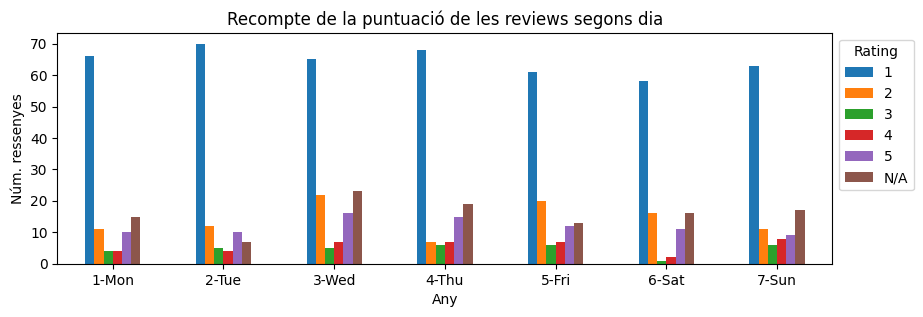

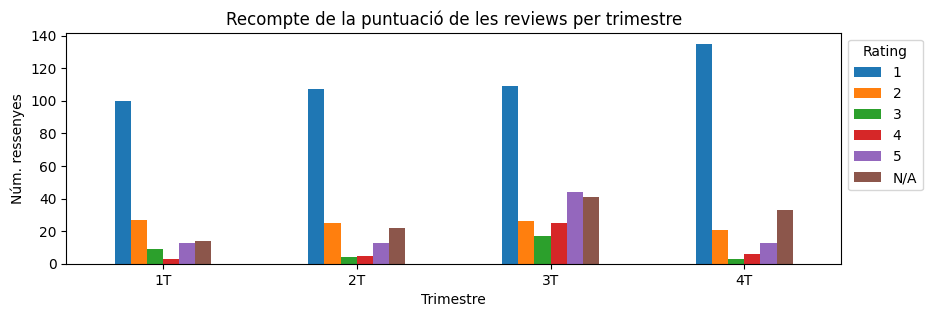

In [41]:
# Create two multibarplots to compare ratings for day and quarters
data = starbucks_rev.groupBy("Day", "Rating").count().orderBy(F.desc("Day")).toPandas()
data_pivot = data.pivot(index='Day', columns='Rating', values='count') # this make possible plots be side by side
print(starbucks_rev.groupBy("Trim").count().orderBy(F.desc("Trim")).show())

# Plot reviews x day
data_pivot.plot(kind='bar', figsize=(10, 3))
plt.title("Recompte de la puntuació de les reviews segons dia")
plt.xlabel("Any")
plt.ylabel("Núm. ressenyes")
plt.xticks(rotation=0)
plt.legend(title="Rating", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

data = starbucks_rev.groupBy("Trim", "Rating").count().orderBy(F.desc("Trim")).toPandas()
data_pivot = data.pivot(index='Trim', columns='Rating', values='count')

# Plot reviews x quarters
data_pivot.plot(kind='bar', figsize=(10, 3))
plt.title("Recompte de la puntuació de les reviews per trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Núm. ressenyes")
plt.xticks(rotation=0)
plt.legend(title="Rating", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [42]:
# Check reviews x year
starbucks_rev.groupBy("Year").count().orderBy(F.desc("Year")).show()

+-----+-----+
| Year|count|
+-----+-----+
| 2023|   39|
| 2022|   54|
| 2021|   34|
| 2020|   32|
| 2019|   55|
| 2018|   55|
| 2017|  124|
| 2016|   60|
| 2015|   90|
| 2014|   64|
| 2013|   24|
| 2012|   52|
| 2011|   26|
| 2010|   48|
| 2009|   38|
| 2008|   15|
| 2007|    2|
| 2006|    2|
| 2004|    1|
+-----+-----+



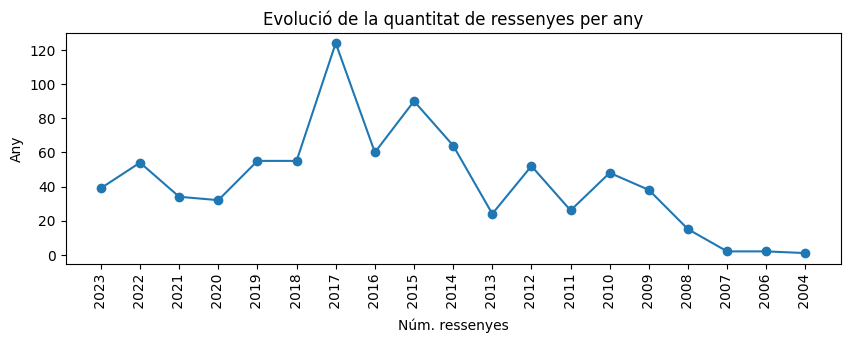

In [43]:
# Create a line plot to see the evolution in years
data = starbucks_rev.groupBy("Year").count().orderBy(F.desc("year")).toPandas()

# Line plot
plt.figure(figsize=(10, 3))
plt.plot(data['Year'], data['count'], marker='o', linestyle='-')
plt.title("Evolució de la quantitat de ressenyes per any")
plt.xlabel("Núm. ressenyes")
plt.ylabel("Any")
plt.xticks(rotation=90)

plt.show()

### Observacions
___
**Gràfic 3: Recompte de ressenyes per dia de la setmana**
> 1. Contrariament el que podia creure veiem que el dia de la setmana no influeix en les ressenyes. Especialment tenint en compte el cap de setmana
> 2. El número de reviews i puntuació d'! es mante inalterable pràcticament. Veiem que el dilluns i dimarts potser és on hi ha més diferencies respecte la resta de les puntuacions.
> 3. També podriem destacar que el dissabte és el dia que menys neutral és segurament. 
> 4. Com deiem anteriorment, estaria bé si el dia que es fa la ressenya és el mateix que s'ha anat a l'establiment.


**Gràfic 4 i taula 1: Recompte de ressenyes per trimestre**
> 1. Veiem que si hi ha una diferència del nombre de ressenyes del primer semestre i el segon. 
> 2. Veiem que el 4T trimestre (tardor) les puntuacions negatives son més altres. Podria estar relacionat amb l'estacionalitat.
> 3. El 3T trimestre, el pèriode amb més ressenyes veiem que son les més positives (coincideix amb l'estiu).

**Gràfic 5 i taula 2: Recompte de ressenyes per any**
> 1. Podem veure que les ressenyess al principi eren escasses, a partir del 2008 comencen a créixer arribant al seu punt més algid el 2017. Després torna a baixar, però més enllà de la crisi del Covid. Per tant no podem veure que afectés, ja que el 2018 ja vam baixar.
> 2. Crec que las classificació segmentada per Trimestres i dies ja és suficient i em sembla més interessant veure aquesta evolució.  

>     c) Hi ha correlació entre les puntuacions i si s'aporta imatges

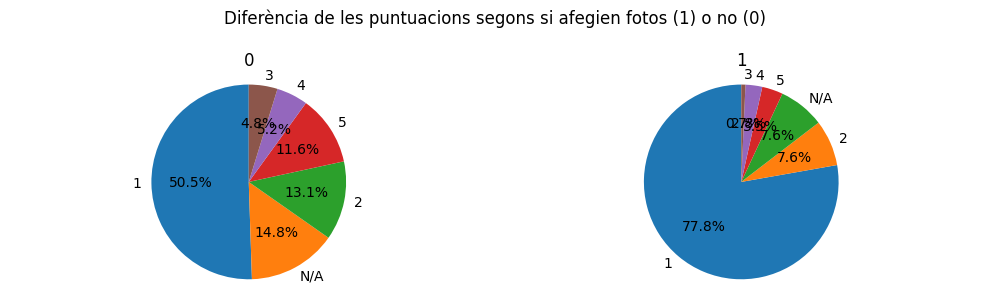

In [44]:
# Pie plot to compare if images have correlation with the reviews
data = starbucks_rev.select("images", "rating").toPandas()
unique_images = data["images"].unique()

# Plots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for i, image in enumerate(unique_images):
    image_data = data[data["images"] == image]
    rating_counts = image_data["rating"].value_counts()
    axes[i].pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].axis('equal')
    axes[i].set_title(f"{image}")

plt.suptitle("Diferència de les puntuacions segons si afegien fotos (1) o no (0)")
plt.tight_layout()
plt.show()

### Observacions
___
**Gràfic 6: Hi ha diferència entre les puntuacions de ressenyes amb fotos i sense**
> 1. Pues podem veure que les ressenyes que amb fotos les puntuacions negatives (1) es disperan. Més enllà del que hem vist abans per estat. La resta de valors si que es mantenen, cosa que pot sorprendre perquè també m'esperava més diferència amb les fotos de 5. 

In [45]:
# Remove objectes created we will not use anymore
del state_counts, changes, data, data_pivot, unique_images

## ANALISI DE SENTIMENT i ML

#### 1. Preprocessat i exploració de text

In [46]:
# Remove punctuation from Reviews
def removePunctuation(text):
    return re.sub(r"[^A-Za-z\s]","",text).lower().strip()
removePunctuation_udf = F.udf(removePunctuation, StringType())
starbucks_rev = starbucks_rev.withColumn("Review", removePunctuation_udf(starbucks_rev["Review"]))

starbucks_rev.show()

+---------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+
|     Name|       Cities|State| Year|Month|Month_Day|  Day|Rating|Images|              Review|Trim|
+---------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+
|    Helen|Wichita Falls|   TX| 2023|   09|       13|3-Wed|     5|     0|amber and ladonna...|  3T|
| Courtney|       Apopka|   FL| 2023|   07|       16|7-Sun|     5|     0|at the starbucks ...|  3T|
| Daynelle|Cranberry Twp|   PA| 2023|   07|       05|3-Wed|     5|     1|i just wanted to ...|  3T|
|   Taylor|      Seattle|   WA| 2023|   05|       26|5-Fri|     5|     0|me and my friend ...|  2T|
|  Tenessa|      Gresham|   OR| 2023|   01|       22|7-Sun|     5|     1|im on this kick o...|  1T|
|   Alyssa|    Sunnyvale|   TX| 2023|   09|       14|4-Thu|     1|     0|we had to correct...|  3T|
|      Ken|  Spring Hill|   FL| 2023|   09|       08|5-Fri|     1|     0|i have tried star...|  3T|


In [47]:
# Check if still exist more than one space consecutives
def Double_spaces(text):
    pattern = r'\s{2,}'
    return bool(re.search(pattern, text))

# Register function as UDF (User-Defined Function) and apply
Double_spaces_udf = F.udf(Double_spaces, BooleanType())
starbucks_rev = starbucks_rev.withColumn("Double_spaces", Double_spaces_udf(starbucks_rev["Review"]))

starbucks_rev.show()

+---------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+-------------+
|     Name|       Cities|State| Year|Month|Month_Day|  Day|Rating|Images|              Review|Trim|Double_spaces|
+---------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+-------------+
|    Helen|Wichita Falls|   TX| 2023|   09|       13|3-Wed|     5|     0|amber and ladonna...|  3T|         true|
| Courtney|       Apopka|   FL| 2023|   07|       16|7-Sun|     5|     0|at the starbucks ...|  3T|         true|
| Daynelle|Cranberry Twp|   PA| 2023|   07|       05|3-Wed|     5|     1|i just wanted to ...|  3T|         true|
|   Taylor|      Seattle|   WA| 2023|   05|       26|5-Fri|     5|     0|me and my friend ...|  2T|         true|
|  Tenessa|      Gresham|   OR| 2023|   01|       22|7-Sun|     5|     1|im on this kick o...|  1T|         true|
|   Alyssa|    Sunnyvale|   TX| 2023|   09|       14|4-Thu|     1|     0|we had to corre

In [48]:
# Drop multiple spaces that we have and check again
starbucks_rev = starbucks_rev.withColumn("Review", F.regexp_replace(starbucks_rev["Review"], r'\s+', ' '))
starbucks_rev = starbucks_rev.withColumn("Double_spaces", Double_spaces_udf(starbucks_rev["Review"]))

starbucks_rev.show()

+---------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+-------------+
|     Name|       Cities|State| Year|Month|Month_Day|  Day|Rating|Images|              Review|Trim|Double_spaces|
+---------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+-------------+
|    Helen|Wichita Falls|   TX| 2023|   09|       13|3-Wed|     5|     0|amber and ladonna...|  3T|        false|
| Courtney|       Apopka|   FL| 2023|   07|       16|7-Sun|     5|     0|at the starbucks ...|  3T|        false|
| Daynelle|Cranberry Twp|   PA| 2023|   07|       05|3-Wed|     5|     1|i just wanted to ...|  3T|        false|
|   Taylor|      Seattle|   WA| 2023|   05|       26|5-Fri|     5|     0|me and my friend ...|  2T|        false|
|  Tenessa|      Gresham|   OR| 2023|   01|       22|7-Sun|     5|     1|im on this kick o...|  1T|        false|
|   Alyssa|    Sunnyvale|   TX| 2023|   09|       14|4-Thu|     1|     0|we had to corre

In [49]:
# Check unique values of Rating column
starbucks_rev.select("Double_spaces").distinct().rdd.map(lambda row: row[0]).collect()

[False]

In [50]:
# Drop Double_spaces column
starbucks_rev = starbucks_rev.drop("Double_spaces")
starbucks_rev.show(5)

+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+
|    Name|       Cities|State| Year|Month|Month_Day|  Day|Rating|Images|              Review|Trim|
+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+
|   Helen|Wichita Falls|   TX| 2023|   09|       13|3-Wed|     5|     0|amber and ladonna...|  3T|
|Courtney|       Apopka|   FL| 2023|   07|       16|7-Sun|     5|     0|at the starbucks ...|  3T|
|Daynelle|Cranberry Twp|   PA| 2023|   07|       05|3-Wed|     5|     1|i just wanted to ...|  3T|
|  Taylor|      Seattle|   WA| 2023|   05|       26|5-Fri|     5|     0|me and my friend ...|  2T|
| Tenessa|      Gresham|   OR| 2023|   01|       22|7-Sun|     5|     1|im on this kick o...|  1T|
+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+
only showing top 5 rows



In [51]:
# Tokenizaction
starbucks_rev = starbucks_rev.withColumn("Tokens", F.split(starbucks_rev["Review"], " "))

In [52]:
# Stopwords
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol="Tokens", outputCol="FilteredTokens")
starbucks_rev = remover.transform(starbucks_rev)

In [53]:
# Lemmatization
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
lemmatize_udf = F.udf(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens], ArrayType(StringType()))
starbucks_rev = starbucks_rev.withColumn("LemmatizedTokens", lemmatize_udf(starbucks_rev["FilteredTokens"]))

In [54]:
# Stemming
stemmer = PorterStemmer()
stem_udf = F.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
starbucks_rev = starbucks_rev.withColumn("StemmedTokens", stem_udf(starbucks_rev["FilteredTokens"]))

starbucks_rev.show(5)

+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|    Name|       Cities|State| Year|Month|Month_Day|  Day|Rating|Images|              Review|Trim|              Tokens|      FilteredTokens|    LemmatizedTokens|       StemmedTokens|
+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|   Helen|Wichita Falls|   TX| 2023|   09|       13|3-Wed|     5|     0|amber and ladonna...|  3T|[amber, and, lado...|[amber, ladonna, ...|[amber, ladonna, ...|[amber, ladonna, ...|
|Courtney|       Apopka|   FL| 2023|   07|       16|7-Sun|     5|     0|at the starbucks ...|  3T|[at, the, starbuc...|[starbucks, fire,...|[starbucks, fire,...|[starbuck, fire, ...|
|Daynelle|Cranberry Twp|   PA| 2023|   07|       05|3-Wed|     5|     1|i just wanted

**Exploració del text de les ressenyes**

In [55]:
# Create an rdd object so we will be able to operate with words
reviews_rdd = starbucks_rev.select("FilteredTokens").rdd

In [56]:
# Get a words list
words_rdd = reviews_rdd.flatMap(lambda row: row[0])

# Use reducebykey to count words frequency & show results
words_counts = words_rdd.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a +b)

# Sort words with descendet order and show top 15
sort_words_counts = words_counts.map(lambda x: (x[1], x[0])).sortByKey(ascending=False)

print(f"Hi ha un total de \033[1m{words_rdd.count()}\033[0m paraules. D'aquestes \033[1m{words_rdd.distinct().count()} són uniques\033[0m, i les 15 més repetides son: \n")

for word, count in sort_words_counts.take(15):
    print(f"{word}: {count}")

sorta_words_counts = words_counts.map(lambda x: (x[1], x[0])).sortByKey()
print("\n i les 15 menys repetides son: \n")

for word, count in sorta_words_counts.take(15):
    print(f"{word}: {count}")

Hi ha un total de 33234 paraules. D'aquestes 5495 són uniques, i les 15 més repetides son: 

1010: starbucks
544: coffee
259: get
256: customer
252: one
251: drink
240: service
237: store
222: time
203: like
201: go
195: order
189: said
177: card
169: went

 i les 15 menys repetides son: 

1: amber
1: ladonna
1: southwest
1: parkway
1: spoton
1: altamonte
1: niko
1: recognize
1: billy
1: soo
1: shoreline
1: kick
1: instacart
1: stepmom
1: chinese


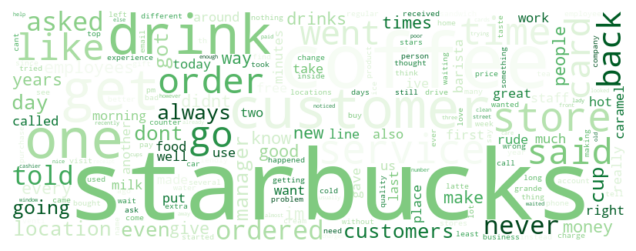

In [57]:
# Show the result of frequency with a wordcloud
from wordcloud import WordCloud
import matplotlib.cm as cm

word_freq = dict(words_counts.collect())
wordcloud = WordCloud(width=800, height=300, background_color="white", colormap=cm.Greens).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 3))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [58]:
# Delete objects we will not use anymore
del reviews_rdd, words_rdd, sort_words_counts, sorta_words_counts, word_freq,  wordcloud 

# Drop columns are not usefull anymore
starbucks_rev = starbucks_rev.drop("Tokens").drop("LemmatizedTokens")
starbucks_rev.show(5)

+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+--------------------+--------------------+
|    Name|       Cities|State| Year|Month|Month_Day|  Day|Rating|Images|              Review|Trim|      FilteredTokens|       StemmedTokens|
+--------+-------------+-----+-----+-----+---------+-----+------+------+--------------------+----+--------------------+--------------------+
|   Helen|Wichita Falls|   TX| 2023|   09|       13|3-Wed|     5|     0|amber and ladonna...|  3T|[amber, ladonna, ...|[amber, ladonna, ...|
|Courtney|       Apopka|   FL| 2023|   07|       16|7-Sun|     5|     0|at the starbucks ...|  3T|[starbucks, fire,...|[starbuck, fire, ...|
|Daynelle|Cranberry Twp|   PA| 2023|   07|       05|3-Wed|     5|     1|i just wanted to ...|  3T|[wanted, go, way,...|[want, go, way, r...|
|  Taylor|      Seattle|   WA| 2023|   05|       26|5-Fri|     5|     0|me and my friend ...|  2T|[friend, starbuck...|[friend, starbuck...|
| Tenessa|   

#### 2. Etiquetar sentiment del text amb els metodes VADER i TextBlob

**VADER**

In [59]:
# Import libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Create a VADER Sentiment Analyser function and return puntuation
def analyze_sentiment(tokens):
    text = " ".join(tokens)
    sentiment_scores = sia.polarity_scores(text)
    return (sentiment_scores['pos'], sentiment_scores['neg'], sentiment_scores['neu'], sentiment_scores['compound'])

# Define structure of UDF and apply the function created before to our column of our df
sentiment_struct = StructType([StructField("PositiveScore", DoubleType(), True),
                               StructField("NegativeScore", DoubleType(), True),
                               StructField("NeutralScore", DoubleType(), True),
                               StructField("CompoundScore", DoubleType(), True)])

sentiment_udf = F.udf(analyze_sentiment, sentiment_struct)
starbucks_rev = starbucks_rev.withColumn("SentimentScores", sentiment_udf(starbucks_rev["StemmedTokens"]))

# Divide the column SentimentScores into differents columns
starbucks_rev = starbucks_rev.withColumn("PositiveScore", starbucks_rev["SentimentScores"].getField("PositiveScore"))
starbucks_rev = starbucks_rev.withColumn("NegativeScore", starbucks_rev["SentimentScores"].getField("NegativeScore"))
starbucks_rev = starbucks_rev.withColumn("NeutralScore", starbucks_rev["SentimentScores"].getField("NeutralScore"))
starbucks_rev = starbucks_rev.withColumn("CompoundScore", starbucks_rev["SentimentScores"].getField("CompoundScore"))

# Drop column we will not use anymore
starbucks_rev = starbucks_rev.drop("SentimentScores")

In [60]:
# Create a new df to analyze VADER results
starbucks_rev_VAD = starbucks_rev.select("Rating", "Images", "Review", "StemmedTokens","CompoundScore", "PositiveScore", "NegativeScore", "NeutralScore")

In [61]:
# Create a column with sentiment tags
starbucks_rev_VAD = starbucks_rev_VAD.withColumn("Sentimiento_VAD", F.when(starbucks_rev_VAD["CompoundScore"] >= 0.05, "Positivo").when(starbucks_rev_VAD["CompoundScore"] <= -0.05, "Negativo")
    .otherwise("Neutral"))

starbucks_rev_VAD.show(10)

+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+
|Rating|Images|              Review|       StemmedTokens|CompoundScore|PositiveScore|NegativeScore|NeutralScore|Sentimiento_VAD|
+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+
|     5|     0|amber and ladonna...|[amber, ladonna, ...|        0.802|        0.295|          0.0|       0.705|       Positivo|
|     5|     0|at the starbucks ...|[starbuck, fire, ...|       0.9643|        0.338|         0.08|       0.582|       Positivo|
|     5|     1|i just wanted to ...|[want, go, way, r...|       0.4767|        0.258|        0.146|       0.596|       Positivo|
|     5|     0|me and my friend ...|[friend, starbuck...|       0.8781|        0.361|        0.172|       0.467|       Positivo|
|     5|     1|im on this kick o...|[im, kick, drink,...|       0.9565|        0.362|          0.

In [62]:
# Total reviews
print(f"\033[1mRessenyes totals: {starbucks_rev_VAD.count()}\033[0m \n")

# Reviews of 5
print(f"\033[1mRessenyes totals de valoració 5: {starbucks_rev_VAD.filter((F.col('Rating') == '5')).count()}\033[0m")
print("Ressenyes totals de valoració 5 i sentimient positiu:", starbucks_rev_VAD.filter((F.col("Rating") == "5") & (F.col("Sentimiento_VAD") == "Positivo")).count())
print("Ressenyes totals de valoració 5 i sentimient neutre:", starbucks_rev_VAD.filter((F.col("Rating") == "5") & (F.col("Sentimiento_VAD") == "Neutral")).count())
print("Ressenyes totals de valoració 5 i sentimient negativo:", starbucks_rev_VAD.filter((F.col("Rating") == "5") & (F.col("Sentimiento_VAD") == "Negativo")).count(), "\n")

# Reviews of 4
print(f"\033[1mRessenyes totals de valoració 4: {starbucks_rev_VAD.filter((F.col('Rating') == '4')).count()}\033[0m")
print("Ressenyes totals de valoració 4 i sentimient positiu:", starbucks_rev_VAD.filter((F.col("Rating") == "4") & (F.col("Sentimiento_VAD") == "Positivo")).count())
print("Ressenyes totals de valoració 4 i sentimient neutre:", starbucks_rev_VAD.filter((F.col("Rating") == "4") & (F.col("Sentimiento_VAD") == "Neutral")).count())
print("Ressenyes totals de valoració 4 i sentimient negativo:", starbucks_rev_VAD.filter((F.col("Rating") == "4") & (F.col("Sentimiento_VAD") == "Negativo")).count(), "\n")

# Reviews of 3
print(f"\033[1mRessenyes totals de valoració 3: {starbucks_rev_VAD.filter((F.col('Rating') == '3')).count()}\033[0m")
print("Ressenyes totals de valoració 3 i sentimient positiu:", starbucks_rev_VAD.filter((F.col("Rating") == "3") & (F.col("Sentimiento_VAD") == "Positivo")).count())
print("Ressenyes totals de valoració 3 i sentimient neutre:", starbucks_rev_VAD.filter((F.col("Rating") == "3") & (F.col("Sentimiento_VAD") == "Neutral")).count())
print("Ressenyes totals de valoració 3 i sentimient negativo:", starbucks_rev_VAD.filter((F.col("Rating") == "3") & (F.col("Sentimiento_VAD") == "Negativo")).count(), "\n")

# Reviews of 2
print(f"\033[1mRessenyes totals de valoració 2: {starbucks_rev_VAD.filter((F.col('Rating') == '2')).count()}\033[0m")
print("Ressenyes totals de valoració 2 i sentimient positiu:", starbucks_rev_VAD.filter((F.col("Rating") == "2") & (F.col("Sentimiento_VAD") == "Positivo")).count())
print("Ressenyes totals de valoració 2 i sentimient neutre:", starbucks_rev_VAD.filter((F.col("Rating") == "2") & (F.col("Sentimiento_VAD") == "Neutral")).count())
print("Ressenyes totals de valoració 2 i sentimient negativo:", starbucks_rev_VAD.filter((F.col("Rating") == "2") & (F.col("Sentimiento_VAD") == "Negativo")).count(), "\n")

# Reviews of 1
print(f"\033[1mRessenyes totals de valoració 1: {starbucks_rev_VAD.filter((F.col('Rating') == '1')).count()}\033[0m")
print("Ressenyes totals de valoració 1 i sentimient positiu:", starbucks_rev_VAD.filter((F.col("Rating") == "1") & (F.col("Sentimiento_VAD") == "Positivo")).count())
print("Ressenyes totals de valoració 1 i sentimient neutre:", starbucks_rev_VAD.filter((F.col("Rating") == "1") & (F.col("Sentimiento_VAD") == "Neutral")).count())
print("Ressenyes totals de valoració 1 i sentimient negativo:", starbucks_rev_VAD.filter((F.col("Rating") == "1") & (F.col("Sentimiento_VAD") == "Negativo")).count(), "\n")

# Reviews of N/A
print(f"\033[1mRessenyes totals de valoració N/A: {starbucks_rev_VAD.filter((F.col('Rating') == 'N/A')).count()}\033[0m")
print("Ressenyes totals de valoració N/A i sentimient positiu:", starbucks_rev_VAD.filter((F.col("Rating") == "N/A") & (F.col("Sentimiento_VAD") == "Positivo")).count())
print("Ressenyes totals de valoració N/A i sentimient neutre:", starbucks_rev_VAD.filter((F.col("Rating") == "N/A") & (F.col("Sentimiento_VAD") == "Neutral")).count())
print("Ressenyes totals de valoració N/A i sentimient negativo:", starbucks_rev_VAD.filter((F.col("Rating") == "N/A") & (F.col("Sentimiento_VAD") == "Negativo")).count())

Ressenyes totals: 815 

Ressenyes totals de valoració 5: 83
Ressenyes totals de valoració 5 i sentimient positiu: 75
Ressenyes totals de valoració 5 i sentimient neutre: 4
Ressenyes totals de valoració 5 i sentimient negativo: 4 

Ressenyes totals de valoració 4: 39
Ressenyes totals de valoració 4 i sentimient positiu: 34
Ressenyes totals de valoració 4 i sentimient neutre: 1
Ressenyes totals de valoració 4 i sentimient negativo: 4 

Ressenyes totals de valoració 3: 33
Ressenyes totals de valoració 3 i sentimient positiu: 24
Ressenyes totals de valoració 3 i sentimient neutre: 2
Ressenyes totals de valoració 3 i sentimient negativo: 7 

Ressenyes totals de valoració 2: 99
Ressenyes totals de valoració 2 i sentimient positiu: 59
Ressenyes totals de valoració 2 i sentimient neutre: 10
Ressenyes totals de valoració 2 i sentimient negativo: 30 

Ressenyes totals de valoració 1: 451
Ressenyes totals de valoració 1 i sentimient positiu: 223
Ressenyes totals de valoració 1 i sentimient neutre

In [63]:
# Check low values of rating 5 to see if i can adjust the sentiment tags to be more accurate
starbucks_rev_VAD.filter(F.col("Rating") == "5").orderBy(F.col("CompoundScore").asc()).show(10)

+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+
|Rating|Images|              Review|       StemmedTokens|CompoundScore|PositiveScore|NegativeScore|NeutralScore|Sentimiento_VAD|
+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+
|     5|     0|after my starbuck...|[starbuck, card, ...|      -0.9153|          0.0|        0.183|       0.817|       Negativo|
|     5|     0|i traveled from a...|[travel, aberdeen...|      -0.5267|        0.093|        0.181|       0.726|       Negativo|
|     5|     0|the coffee is nex...|[coffe, next, non...|       -0.521|        0.065|        0.234|       0.701|       Negativo|
|     5|     0|it was a good int...|[good, introduct,...|       -0.128|         0.11|        0.167|       0.722|       Negativo|
|     5|     0|i work in the jer...|[work, jersey, ga...|          0.0|          0.0|          0.

In [64]:
# Check low values of rating 3 to see if i can adjust the sentiment tags to be more accurate
starbucks_rev_VAD.filter(F.col("Rating") == "3").orderBy(F.col("CompoundScore").asc()).show(20)

+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+
|Rating|Images|              Review|       StemmedTokens|CompoundScore|PositiveScore|NegativeScore|NeutralScore|Sentimiento_VAD|
+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+
|     3|     0|i go to starbucks...|[go, starbuck, al...|      -0.7351|        0.109|        0.188|       0.703|       Negativo|
|     3|     0|i received an ema...|[receiv, email, c...|      -0.4767|        0.053|        0.075|       0.872|       Negativo|
|     3|     0|my favorite starb...|[favorit, starbuc...|      -0.4215|        0.106|        0.149|       0.745|       Negativo|
|     3|     0|ice coffee very b...|[ice, coffe, bitt...|      -0.4215|          0.0|        0.118|       0.882|       Negativo|
|     3|     0|every time i go t...|[everi, time, go,...|      -0.3612|        0.109|         0.1

In [65]:
# Check low values of rating 1 to see if i can adjust the sentiment tags to be more accurate
starbucks_rev1_VAD = starbucks_rev_VAD.filter(F.col("Rating") == "1").orderBy(F.col("CompoundScore").desc())
starbucks_rev1_VAD.limit(230).subtract(starbucks_rev1_VAD.limit(220)).show()

+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+
|Rating|Images|              Review|       StemmedTokens|CompoundScore|PositiveScore|NegativeScore|NeutralScore|Sentimiento_VAD|
+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+
|     1|     1|i filed a bbb com...|[file, bbb, compl...|       0.0516|        0.135|        0.119|       0.746|       Positivo|
|     1|     0|i got a starbucks...|[got, starbuck, g...|       0.0516|        0.102|        0.076|       0.823|       Positivo|
|     1|     1|starbucks biscayn...|[starbuck, biscay...|       0.0516|        0.075|        0.069|       0.856|       Positivo|
|     1|     1|starbucks retail ...|[starbuck, retail...|       0.0258|        0.102|        0.101|       0.797|        Neutral|
|     1|     1|again after weeks...|[week, went, star...|       0.0258|        0.098|        0.09

**Observacions:**
1. Em sorpren que una ressenya que comença per "It was a good int..." tingui un sentiment negatiu
2. No te gaire sentit modificar gaire aquí els valors. Tot i això he detectat que puc baixar el valor del spositius fins a 0.01 per intentar agafar més reviews en els positius i en els negatius fins a -0.02. Això afectarà a les neutrals que de totes maneres no n'havia detectat gaires. 
3. M'agradaria poder aprofundir més en les reviews.

In [66]:
# Crate a new column to compare the adjust we try to imporve the correct tags
starbucks_rev_VAD = starbucks_rev_VAD.withColumn("Sentimiento_VAD_adj", F.when(starbucks_rev_VAD["CompoundScore"] >= 0.01, "Positivo").when(starbucks_rev_VAD["CompoundScore"] <= -0.02, "Negativo")
    .otherwise("Neutral"))

# Print comparision
print("\033[1mTOTAL\033[0m \n", "POS:", starbucks_rev_VAD.filter(F.col("Rating").isin("5", "4")).count(),
"NEU:", starbucks_rev_VAD.filter(F.col("Rating") == "3").count(),
"NEG:", starbucks_rev_VAD.filter(F.col("Rating").isin("1", "2")).count())

print("\n\033[1mBefore Adj\033[0m \n", "POS:", starbucks_rev_VAD.filter(F.col("Rating").isin("5","4") & (F.col("Sentimiento_VAD") == "Positivo")).count(), 
"NEU:", starbucks_rev_VAD.filter((F.col("Rating") == "3") & (F.col("Sentimiento_VAD") == "Neutral")).count(), 
"NEG:", starbucks_rev_VAD.filter(F.col("Rating").isin("2", "1") & (F.col("Sentimiento_VAD") == "Negativo")).count()) 

print("\n\033[1mAfter Adj\033[0m \n", "POS:", starbucks_rev_VAD.filter(F.col("Rating").isin("5", "4") & (F.col("Sentimiento_VAD_adj") == "Positivo")).count(), 
"NEU:", starbucks_rev_VAD.filter((F.col("Rating") == "3") & (F.col("Sentimiento_VAD_adj") == "Neutral")).count(), 
"NEG:", starbucks_rev_VAD.filter(F.col("Rating").isin("2", "1") & (F.col("Sentimiento_VAD_adj") == "Negativo")).count())

TOTAL 
 POS: 122 NEU: 33 NEG: 550

Before Adj 
 POS: 109 NEU: 2 NEG: 219

After Adj 
 POS: 111 NEU: 1 NEG: 225


**TextBlob**

In [67]:
# Import libraries
from textblob import TextBlob

# Define a function for TextBlob sentiment Analyzer
def analyze_sentiment(tokens):
    text = " ".join(tokens)
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Create an UDF, apply the function to our column of our df and add the results to a new column
sentiment_udf = F.udf(analyze_sentiment, FloatType())
starbucks_rev= starbucks_rev.withColumn("Sentimiento_Num_BLOB", sentiment_udf(starbucks_rev["StemmedTokens"]))

In [68]:
# Create a new df with the results of our analysis
starbucks_rev_BLOB = starbucks_rev.select("Rating", "Images", "Review", "Sentimiento_Num_BLOB")
starbucks_rev_BLOB = starbucks_rev_BLOB.withColumn("Sentimiento_BLOB", F.when(starbucks_rev_BLOB["Sentimiento_Num_BLOB"] > 0, "Positivo").when(starbucks_rev_BLOB["Sentimiento_Num_BLOB"] < 0, "Negativo")
    .otherwise("Neutral"))
starbucks_rev_BLOB.show(10)

+------+------+--------------------+--------------------+----------------+
|Rating|Images|              Review|Sentimiento_Num_BLOB|Sentimiento_BLOB|
+------+------+--------------------+--------------------+----------------+
|     5|     0|amber and ladonna...|          0.29714286|        Positivo|
|     5|     0|at the starbucks ...|          0.42592594|        Positivo|
|     5|     1|i just wanted to ...|         -0.11666667|        Negativo|
|     5|     0|me and my friend ...|          0.46666667|        Positivo|
|     5|     1|im on this kick o...|           0.4670068|        Positivo|
|     1|     0|we had to correct...|           0.2857143|        Positivo|
|     1|     0|i have tried star...|                 0.0|         Neutral|
|     1|     0|starbucks near me...|          0.14141414|        Positivo|
|     1|     0|i ordered online ...|         -0.16666667|        Negativo|
|     1|     0|staff at the smyt...|         -0.13611111|        Negativo|
+------+------+----------

In [69]:
# Total reviews
print(f"\033[1mRessenyes totals: {starbucks_rev_BLOB.count()}\033[0m \n")

# Reviews of 5
print(f"\033[1mRessenyes totals de valoració 5: {starbucks_rev.filter((F.col('Rating') == '5')).count()}\033[0m")
print("Ressenyes totals de valoració 5 i sentimient positiu:", starbucks_rev_BLOB.filter((F.col("Rating") == "5") & (F.col("Sentimiento_BLOB") == "Positivo")).count())
print("Ressenyes totals de valoració 5 i sentimient neutre:", starbucks_rev_BLOB.filter((F.col("Rating") == "5") & (F.col("Sentimiento_BLOB") == "Neutral")).count())
print("Ressenyes totals de valoració 5 i sentimient negativo:", starbucks_rev_BLOB.filter((F.col("Rating") == "5") & (F.col("Sentimiento_BLOB") == "Negativo")).count(), "\n")

# Reviews of 4
print(f"\033[1mRessenyes totals de valoració 4: {starbucks_rev_BLOB.filter((F.col('Rating') == '4')).count()}\033[0m")
print("Ressenyes totals de valoració 4 i sentimient positiu:", starbucks_rev_BLOB.filter((F.col("Rating") == "4") & (F.col("Sentimiento_BLOB") == "Positivo")).count())
print("Ressenyes totals de valoració 4 i sentimient neutre:", starbucks_rev_BLOB.filter((F.col("Rating") == "4") & (F.col("Sentimiento_BLOB") == "Neutral")).count())
print("Ressenyes totals de valoració 4 i sentimient negativo:", starbucks_rev_BLOB.filter((F.col("Rating") == "4") & (F.col("Sentimiento_BLOB") == "Negativo")).count(), "\n")

# Reviews of 3
print(f"\033[1mRessenyes totals de valoració 3: {starbucks_rev_BLOB.filter((F.col('Rating') == '3')).count()}\033[0m")
print("Ressenyes totals de valoració 3 i sentimient positiu:", starbucks_rev_BLOB.filter((F.col("Rating") == "3") & (F.col("Sentimiento_BLOB") == "Positivo")).count())
print("Ressenyes totals de valoració 3 i sentimient neutre:", starbucks_rev_BLOB.filter((F.col("Rating") == "3") & (F.col("Sentimiento_BLOB") == "Neutral")).count())
print("Ressenyes totals de valoració 3 i sentimient negativo:", starbucks_rev_BLOB.filter((F.col("Rating") == "3") & (F.col("Sentimiento_BLOB") == "Negativo")).count(), "\n")

# Reviews of 2
print(f"\033[1mRessenyes totals de valoració 2: {starbucks_rev_BLOB.filter((F.col('Rating') == '2')).count()}\033[0m")
print("Ressenyes totals de valoració 2 i sentimient positiu:", starbucks_rev_BLOB.filter((F.col("Rating") == "2") & (F.col("Sentimiento_BLOB") == "Positivo")).count())
print("Ressenyes totals de valoració 2 i sentimient neutre:", starbucks_rev_BLOB.filter((F.col("Rating") == "2") & (F.col("Sentimiento_BLOB") == "Neutral")).count())
print("Ressenyes totals de valoració 2 i sentimient negativo:", starbucks_rev_BLOB.filter((F.col("Rating") == "2") & (F.col("Sentimiento_BLOB") == "Negativo")).count(), "\n")

# Reviews of 1
print(f"\033[1mRessenyes totals de valoració 1: {starbucks_rev_BLOB.filter((F.col('Rating') == '1')).count()}\033[0m")
print("Ressenyes totals de valoració 1 i sentimient positiu:", starbucks_rev_BLOB.filter((F.col("Rating") == "1") & (F.col("Sentimiento_BLOB") == "Positivo")).count())
print("Ressenyes totals de valoració 1 i sentimient neutre:", starbucks_rev_BLOB.filter((F.col("Rating") == "1") & (F.col("Sentimiento_BLOB") == "Neutral")).count())
print("Ressenyes totals de valoració 1 i sentimient negativo:", starbucks_rev_BLOB.filter((F.col("Rating") == "1") & (F.col("Sentimiento_BLOB") == "Negativo")).count(), "\n")

# Reviews of N/A
print(f"\033[1mRessenyes totals de valoració N/A: {starbucks_rev_BLOB.filter((F.col('Rating') == 'N/A')).count()}\033[0m")
print("Ressenyes totals de valoració N/A i sentimient positiu:", starbucks_rev_BLOB.filter((F.col("Rating") == "N/A") & (F.col("Sentimiento_BLOB") == "Positivo")).count())
print("Ressenyes totals de valoració N/A i sentimient neutre:", starbucks_rev_BLOB.filter((F.col("Rating") == "N/A") & (F.col("Sentimiento_BLOB") == "Neutral")).count())
print("Ressenyes totals de valoració N/A i sentimient negativo:", starbucks_rev_BLOB.filter((F.col("Rating") == "N/A") & (F.col("Sentimiento_BLOB") == "Negativo")).count())

Ressenyes totals: 815 

Ressenyes totals de valoració 5: 83
Ressenyes totals de valoració 5 i sentimient positiu: 75
Ressenyes totals de valoració 5 i sentimient neutre: 1
Ressenyes totals de valoració 5 i sentimient negativo: 7 

Ressenyes totals de valoració 4: 39
Ressenyes totals de valoració 4 i sentimient positiu: 31
Ressenyes totals de valoració 4 i sentimient neutre: 2
Ressenyes totals de valoració 4 i sentimient negativo: 6 

Ressenyes totals de valoració 3: 33
Ressenyes totals de valoració 3 i sentimient positiu: 26
Ressenyes totals de valoració 3 i sentimient neutre: 1
Ressenyes totals de valoració 3 i sentimient negativo: 6 

Ressenyes totals de valoració 2: 99
Ressenyes totals de valoració 2 i sentimient positiu: 51
Ressenyes totals de valoració 2 i sentimient neutre: 13
Ressenyes totals de valoració 2 i sentimient negativo: 35 

Ressenyes totals de valoració 1: 451
Ressenyes totals de valoració 1 i sentimient positiu: 212
Ressenyes totals de valoració 1 i sentimient neutre

In [70]:
# Check low values of rating 5 to see if i can adjust the sentiment tags to be more accurate
starbucks_rev_BLOB.filter(F.col("Rating") == "5").orderBy(F.col("Sentimiento_Num_BLOB").asc()).show(20)

+------+------+--------------------+--------------------+----------------+
|Rating|Images|              Review|Sentimiento_Num_BLOB|Sentimiento_BLOB|
+------+------+--------------------+--------------------+----------------+
|     5|     0|after my starbuck...|               -0.35|        Negativo|
|     5|     0|quality is excell...|         -0.29166666|        Negativo|
|     5|     0|starbucks coffee ...|         -0.16666667|        Negativo|
|     5|     1|i just wanted to ...|         -0.11666667|        Negativo|
|     5|     0|i have been a sta...|        -0.016666668|        Negativo|
|     5|     0|every sunday morn...|             -0.0125|        Negativo|
|     5|     0|i work in the jer...|        -0.008333334|        Negativo|
|     5|     0|i have been to ma...|                 0.0|         Neutral|
|     5|     0|even with a limit...|         0.016666668|        Positivo|
|     5|     0|i shop at starbuc...|               0.025|        Positivo|
|     5|     0|this tuesd

In [71]:
# Check low values of rating 5 to see if i can adjust the sentiment tags to be more accurate
starbucks_rev_BLOB.filter(F.col("Rating") == "3").orderBy(F.col("Sentimiento_Num_BLOB")).show(20)

+------+------+--------------------+--------------------+----------------+
|Rating|Images|              Review|Sentimiento_Num_BLOB|Sentimiento_BLOB|
+------+------+--------------------+--------------------+----------------+
|     3|     0|starbucks at an a...|                -0.8|        Negativo|
|     3|     0|i received an ema...|               -0.16|        Negativo|
|     3|     0|my name is ric i ...|               -0.15|        Negativo|
|     3|     0|my favorite starb...|         -0.13428572|        Negativo|
|     3|     0|i go to starbucks...|            -0.11875|        Negativo|
|     3|     0|just to comment t...|         -0.06458333|        Negativo|
|     3|     0|i have not been t...|                 0.0|         Neutral|
|     3|     0|ive been going to...|             0.03125|        Positivo|
|     3|     0|ice coffee very b...|         0.033333335|        Positivo|
|     3|     0|their coffee is s...|         0.041666668|        Positivo|
|     3|     0|the locati

In [72]:
# Check low values of rating 1 to see if i can adjust the sentiment tags to be more accurate
starbucks_rev1_BLOB = starbucks_rev_BLOB.filter(F.col("Rating") == "1").orderBy(F.col("Sentimiento_Num_BLOB").desc())
starbucks_rev1_BLOB.limit(280).subtract(starbucks_rev1_BLOB.limit(260)).show()

+------+------+--------------------+--------------------+----------------+
|Rating|Images|              Review|Sentimiento_Num_BLOB|Sentimiento_BLOB|
+------+------+--------------------+--------------------+----------------+
|     1|     1|warning i recomme...|                 0.0|         Neutral|
|     1|     1|i go to starbucks...|                 0.0|         Neutral|
|     1|     1|this was the last...|                 0.0|         Neutral|
|     1|     1|if i could give n...|                 0.0|         Neutral|
|     1|     0|i came in and ord...|                 0.0|         Neutral|
|     1|     0|my ipad was stole...|                 0.0|         Neutral|
|     1|     1|starbucks has imp...|                 0.0|         Neutral|
|     1|     0|i ordered via sta...|                 0.0|         Neutral|
|     1|     0|the service at th...|       -0.0015873016|        Negativo|
|     1|     1|there is a new ma...|        -0.003896104|        Negativo|
|     1|     0|there was 

**Observacions:**
1. Neutrals son = 0 per tant només podem incrementar el seu número.
2. Em sorpren la classificació d'algunes ressenyes amb les poques paraules a simple vista de la columna _Review_.
3. No te gaire sentit modificar gaire aquí els valors negatius, ja que son molt baixos en les ressenyes de _Rating_ 1, així que podem intentar ajustar una mica les positives però no espero grans millores. 
4. M'agradaria poder aprofundir més en les reviews.

In [73]:
# Readjust sentiment tags
starbucks_rev_BLOB = starbucks_rev_BLOB.withColumn("Sentimiento_BLOB_adj", F.when(starbucks_rev_BLOB["Sentimiento_Num_BLOB"] > 0.05, "Positivo").when(starbucks_rev_BLOB["Sentimiento_Num_BLOB"] < 0, "Negativo")
    .otherwise("Neutral"))

# Print comparision
print("\033[1mTOTAL\033[0m \n", "POS:", starbucks_rev_BLOB.filter(F.col("Rating").isin("5", "4")).count(),
"NEU:", starbucks_rev_BLOB.filter(F.col("Rating") == "3").count(),
"NEG:", starbucks_rev_BLOB.filter(F.col("Rating").isin("1", "2")).count())

print("\n\033[1mBefore Adj\033[0m \n", "POS:", starbucks_rev_BLOB.filter(F.col("Rating").isin("5","4") & (F.col("Sentimiento_BLOB") == "Positivo")).count(), 
"NEU:", starbucks_rev_BLOB.filter((F.col("Rating") == "3") & (F.col("Sentimiento_BLOB") == "Neutral")).count(), 
"NEG:", starbucks_rev_BLOB.filter(F.col("Rating").isin("2", "1") & (F.col("Sentimiento_BLOB") == "Negativo")).count()) 

print("\n\033[1mAfter Adj\033[0m \n", "POS:", starbucks_rev_BLOB.filter(F.col("Rating").isin("5", "4") & (F.col("Sentimiento_BLOB_adj") == "Positivo")).count(), 
"NEU:", starbucks_rev_BLOB.filter((F.col("Rating") == "3") & (F.col("Sentimiento_BLOB_adj") == "Neutral")).count(), 
"NEG:", starbucks_rev_BLOB.filter(F.col("Rating").isin("2", "1") & (F.col("Sentimiento_BLOB_adj") == "Negativo")).count())

TOTAL 
 POS: 122 NEU: 33 NEG: 550

Before Adj 
 POS: 106 NEU: 1 NEG: 218

After Adj 
 POS: 104 NEU: 4 NEG: 218


#### Observacions:
___
> 1. En els dos casos ha millorat molt lleugerement les ressenyes que coincideixen el sentiment amb el Rating.
> 2. Tot i que amb el TextBlob tenim més ressenyes neutres, potser també son les que menys ens interessen per tant em puc quedar amb el mètode VADER.
> 3. Podriem optar per només tenir dos etiquetes Positives i Negatives, però potser perdriem realitat, encara que a priori una ressenya de 3 no és molt positiva (tot i que significa neutre si ens cedim a l'estricte de la puntuació).
> 4. Una altra opció per augmentar el número de neutres seria incloure les de rating 4 i rating 5. 
> 5. M'agradaria poder fer una propia funció de classificació per veure si el model és comporta millor o no. 

### Crear models de ML per l'analisi de sentiment
> 1. Ara el pròxim pas serà crear un dataframe per entrenar i testejar un model d'arpenantatge automàtic a partir de l'anàlisi de sentiment que hem fet anteriorment amb VADER i que coincideixen amb el **RATING (Traient aquesta columna per evitar overfitting)**
> 2. Seria interessant poder fer algún tipus de tècnica per augmentar les reviews neutrals, perque hi ha massa diferència i també equilibrar les positives i negatives. Faré una compartiva d'entrenar els models deixant-ho tal qual (sabent que només tinc un exemple de neutral) i també etiquetaré algunes de les etiquetes mal etiquetades per VADER (segons les puntuacions de les reviews) per augmentar i així poder equilibrar una mica. 
> 3. Podem veure altres llibreries si funcionen millor que la que hem escollit com a principal.
> 4. A través de mètriques analitzar el seu rendiment. 


In [74]:
# Check Schema of df
print(starbucks_rev_VAD.printSchema())

root
 |-- Rating: string (nullable = true)
 |-- Images: integer (nullable = false)
 |-- Review: string (nullable = true)
 |-- StemmedTokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CompoundScore: double (nullable = true)
 |-- PositiveScore: double (nullable = true)
 |-- NegativeScore: double (nullable = true)
 |-- NeutralScore: double (nullable = true)
 |-- Sentimiento_VAD: string (nullable = false)
 |-- Sentimiento_VAD_adj: string (nullable = false)

None


In [75]:
# I play with the NeutralScore number to augment the neutral tags instances
print(starbucks_rev_VAD.filter((F.col("Rating") == "3") & (F.col("NeutralScore") > 0.7)).count())
starbucks_rev_VAD.filter(F.col("Rating") == "3").show()

23
+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+-------------------+
|Rating|Images|              Review|       StemmedTokens|CompoundScore|PositiveScore|NegativeScore|NeutralScore|Sentimiento_VAD|Sentimiento_VAD_adj|
+------+------+--------------------+--------------------+-------------+-------------+-------------+------------+---------------+-------------------+
|     3|     1|in my opinion i c...|[opinion, cant, b...|       0.9246|        0.302|          0.0|       0.698|       Positivo|           Positivo|
|     3|     0|i am continually ...|[continu, disappo...|       0.5859|        0.144|        0.052|       0.805|       Positivo|           Positivo|
|     3|     0|i walk to the sta...|[walk, starbuck, ...|        0.886|         0.19|        0.023|       0.788|       Positivo|           Positivo|
|     3|     0|the location wher...|[locat, go, emplo...|       0.4215|        0.108|        0.066|    

In [76]:
# I correct some of the neutral tags that Vader labeled wrong (using the above method) to have more of this instances to train the model 
starbucks_rev_VAD_bal = starbucks_rev_VAD.withColumn("Sentimiento_VAD_adj", F.when((starbucks_rev_VAD["Rating"] == "3") & (starbucks_rev_VAD["NeutralScore"] > 0.7), "Neutral")
    .otherwise(starbucks_rev_VAD["Sentimiento_VAD_adj"]))

assert starbucks_rev_VAD_bal.filter((F.col("Rating") == "3") & (F.col("Sentimiento_VAD_adj") == "Neutral")).count() == 23, "Revisa el teu codi"

In [77]:
# Create a new DF from the correct tags depending of rating reviews
starbucks_ML = starbucks_rev_VAD.select("Rating", "Images", "Review", "StemmedTokens","Sentimiento_VAD_adj")
starbucks_ML = starbucks_ML.filter(((F.col("Rating").isin("5", "4")) & (F.col("Sentimiento_VAD_adj") == "Positivo")) | ((F.col("Rating") == "3") & (F.col("Sentimiento_VAD_adj") == "Neutral"))  | ((F.col("Rating").isin("2", "1")) & (F.col("Sentimiento_VAD_adj") == "Negativo")))

# Check that the code is correct 
assert starbucks_ML.count() == 337, "Revisa el teu codi"

print(starbucks_ML.printSchema())

root
 |-- Rating: string (nullable = true)
 |-- Images: integer (nullable = false)
 |-- Review: string (nullable = true)
 |-- StemmedTokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Sentimiento_VAD_adj: string (nullable = false)

None


In [78]:
# Create a new DF from the correct tags depending of rating reviews
starbucks_MLbal = starbucks_rev_VAD_bal.select("Rating", "Images", "Review", "StemmedTokens","Sentimiento_VAD_adj")
starbucks_MLbal = starbucks_MLbal.filter(((F.col("Rating").isin("5", "4")) & (F.col("Sentimiento_VAD_adj") == "Positivo")) | ((F.col("Rating") == "3") & (F.col("Sentimiento_VAD_adj") == "Neutral"))  | ((F.col("Rating").isin("2", "1")) & (F.col("Sentimiento_VAD_adj") == "Negativo")))

# Check that the two df are created correctly 
assert starbucks_ML.filter((F.col("Rating") == "3") & (F.col("Sentimiento_VAD_adj") == "Neutral")).count() != starbucks_MLbal.filter((F.col("Rating") == "3") & (F.col("Sentimiento_VAD_adj") == "Neutral")).count(), "Revisa el teu codi"

In [79]:
# Drop column Rating to not create overfitting and invalidate the ML from review text of two df
starbucks_ML = starbucks_ML.drop("Rating")
starbucks_MLbal = starbucks_MLbal.drop("Rating")

starbucks_ML.show(5)

+------+--------------------+--------------------+-------------------+
|Images|              Review|       StemmedTokens|Sentimiento_VAD_adj|
+------+--------------------+--------------------+-------------------+
|     0|amber and ladonna...|[amber, ladonna, ...|           Positivo|
|     0|at the starbucks ...|[starbuck, fire, ...|           Positivo|
|     1|i just wanted to ...|[want, go, way, r...|           Positivo|
|     0|me and my friend ...|[friend, starbuck...|           Positivo|
|     1|im on this kick o...|[im, kick, drink,...|           Positivo|
+------+--------------------+--------------------+-------------------+
only showing top 5 rows



#### ML amb només 1 ressenya neutral

In [80]:
# Import Libraries for classic ML classification models
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer, CountVectorizer

In [81]:
# Vectorizer the text
cvect = CountVectorizer(inputCol="StemmedTokens", outputCol="features", minDF=2, binary=True)
model = cvect.fit(starbucks_rev_VAD)
starbucks_rev_VAD = model.transform(starbucks_rev_VAD)

# Convert string labels to numerical labels
indexer = StringIndexer(inputCol="Sentimiento_VAD_adj", outputCol="label")
starbucks_rev_VAD = indexer.fit(starbucks_rev_VAD).transform(starbucks_rev_VAD)

In [82]:
# Vectorizer the df we will use to train and test our models
starbucks_ML = model.transform(starbucks_ML)

# Convert string labels to numerical labels
starbucks_ML = indexer.fit(starbucks_ML).transform(starbucks_ML)

In [83]:
starbucks_ML.show(10)

+------+--------------------+--------------------+-------------------+--------------------+-----+
|Images|              Review|       StemmedTokens|Sentimiento_VAD_adj|            features|label|
+------+--------------------+--------------------+-------------------+--------------------+-----+
|     0|amber and ladonna...|[amber, ladonna, ...|           Positivo|(2060,[0,2,3,6,10...|  1.0|
|     0|at the starbucks ...|[starbuck, fire, ...|           Positivo|(2060,[0,3,4,5,8,...|  1.0|
|     1|i just wanted to ...|[want, go, way, r...|           Positivo|(2060,[0,2,7,11,1...|  1.0|
|     0|me and my friend ...|[friend, starbuck...|           Positivo|(2060,[0,4,11,13,...|  1.0|
|     1|im on this kick o...|[im, kick, drink,...|           Positivo|(2060,[0,1,4,7,12...|  1.0|
|     0|we had to correct...|[correct, order, ...|           Negativo|(2060,[2,5,14,20,...|  0.0|
|     0|i ordered online ...|[order, onlin, re...|           Negativo|(2060,[2,4,29,76,...|  0.0|
|     0|staff at the

_Ara Sabem que:_ 
> 1.0 = Positivo  
> 0.0 = Negativo  
> 2.0 a Neutral  

In [84]:
# Check schemas
starbucks_ML.printSchema()

root
 |-- Images: integer (nullable = false)
 |-- Review: string (nullable = true)
 |-- StemmedTokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Sentimiento_VAD_adj: string (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [85]:
# Drop Sentimiento_VAD_adj as we have already convert numeric column (label)
starbucks_ML = starbucks_ML.drop("Sentimiento_VAD_adj")

In [86]:
# Split the df into train and test and save on the caché to maximize the performance
starbucks_ML_train, starbucks_ML_test = starbucks_ML.randomSplit([0.8, 0.2], seed = 42)
starbucks_ML_train.cache()
starbucks_ML_test.cache()

DataFrame[Images: int, Review: string, StemmedTokens: array<string>, features: vector, label: double]

In [87]:
# Test the performance of our ML models with some tipical metrics
classifiers = {
    "NBayes": NaiveBayes(),
    "RForest": RandomForestClassifier(),
    "LRegression": LogisticRegression()
}

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

for name, classifier in classifiers.items():
    model = classifier.fit(starbucks_ML_train)
    predictions = model.transform(starbucks_ML_test)
    
    accuracy = evaluator.evaluate(predictions)
    print(name, "- Accuracy:", accuracy)
    
    evaluator.setMetricName("weightedRecall")
    recall = evaluator.evaluate(predictions)

    evaluator.setMetricName("weightedPrecision")
    precision = evaluator.evaluate(predictions)

    evaluator.setMetricName("f1")
    f1_score = evaluator.evaluate(predictions)

    print(name, "- Recall:", recall)
    print(name, "- Precision:", precision)
    print(name, "- F1-Score:", f1_score, "\n")

NBayes - Accuracy: 0.8853298404381997
NBayes - Recall: 0.8823529411764706
NBayes - Precision: 0.8914376561435385
NBayes - F1-Score: 0.8853298404381997 

RForest - Accuracy: 0.7450343773873186
RForest - Recall: 0.8039215686274509
RForest - Precision: 0.843937575030012
RForest - F1-Score: 0.7450343773873186 

LRegression - Accuracy: 0.860629997733821
LRegression - Recall: 0.8627450980392157
LRegression - Precision: 0.8593582887700535
LRegression - F1-Score: 0.860629997733821 



_Podem veure que el model que es comporta millor es el Naive Bayes tot i que Logistic Regression el segueix de ben aprop.    
Podriem buscar millors parametres pero ja veiem que el resultat és prou bé i dubto que millori gaire el model.   
Descartem RForest._ 

In [88]:
starbucks_rev_VAD.printSchema()

root
 |-- Rating: string (nullable = true)
 |-- Images: integer (nullable = false)
 |-- Review: string (nullable = true)
 |-- StemmedTokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CompoundScore: double (nullable = true)
 |-- PositiveScore: double (nullable = true)
 |-- NegativeScore: double (nullable = true)
 |-- NeutralScore: double (nullable = true)
 |-- Sentimiento_VAD: string (nullable = false)
 |-- Sentimiento_VAD_adj: string (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [89]:
# Select only columns we considere can affect to df and confirm their coincidence with training df
starbucks_rev_final = starbucks_rev_VAD.select("Images", "Review", "StemmedTokens", "features", "label")
assert starbucks_rev_final.columns == starbucks_ML_train.columns, "Revisa el codi"

In [90]:
# Train & predict
# Después del bucle for
# Acceder al modelo de Regresión Logística una vez que ha sido entrenado
LRegression = LogisticRegression()
model = LRegression.fit(starbucks_ML_train)
predictions_LR = model.transform(starbucks_rev_final)

In [91]:
predictions_LR.show(10)

+------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|Images|              Review|       StemmedTokens|            features|label|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|     0|amber and ladonna...|[amber, ladonna, ...|(2060,[0,2,3,6,10...|  0.0|[0.78390859782731...|[0.03492784208597...|       1.0|
|     0|at the starbucks ...|[starbuck, fire, ...|(2060,[0,3,4,5,8,...|  0.0|[-8.4534692066188...|[1.00564909418914...|       1.0|
|     1|i just wanted to ...|[want, go, way, r...|(2060,[0,2,7,11,1...|  0.0|[-10.189128182003...|[8.20843963804294...|       1.0|
|     0|me and my friend ...|[friend, starbuck...|(2060,[0,4,11,13,...|  0.0|[-9.9160638672929...|[1.18089912037756...|       1.0|
|     1|im on this kick o...|[im, kick, drink,...|(2060,[0,1,4,7,12...|  0.0|[-9.58

In [92]:
# Add rating column so we can compare the results
predictions_LR = predictions_LR.join(starbucks_rev_BLOB.select("Review", "Rating"), "Review", "right")
predictions_LR.show(10)

+--------------------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+------+
|              Review|Images|       StemmedTokens|            features|label|       rawPrediction|         probability|prediction|Rating|
+--------------------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+------+
|amber and ladonna...|     0|[amber, ladonna, ...|(2060,[0,2,3,6,10...|  0.0|[0.78390859782731...|[0.03492784208597...|       1.0|     5|
|at the starbucks ...|     0|[starbuck, fire, ...|(2060,[0,3,4,5,8,...|  0.0|[-8.4534692066188...|[1.00564909418914...|       1.0|     5|
|i just wanted to ...|     1|[want, go, way, r...|(2060,[0,2,7,11,1...|  0.0|[-10.189128182003...|[8.20843963804294...|       1.0|     5|
|me and my friend ...|     0|[friend, starbuck...|(2060,[0,4,11,13,...|  0.0|[-9.9160638672929...|[1.18089912037756...|       1.0|     5|
|im on this kick o...|     1|[im, 

In [93]:
# Train & predict Naive Bayes model
NBayes = NaiveBayes()
model = NBayes.fit(starbucks_ML_train)
predictions_NB = model.transform(starbucks_rev_final)

In [94]:
predictions_NB = predictions_NB.join(starbucks_rev_VAD.select("Review", "Rating"), "Review", "right")
predictions_NB.show()

+--------------------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+------+
|              Review|Images|       StemmedTokens|            features|label|       rawPrediction|         probability|prediction|Rating|
+--------------------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+------+
|amber and ladonna...|     0|[amber, ladonna, ...|(2060,[0,2,3,6,10...|  0.0|[-109.77727398916...|[0.25454286162944...|       1.0|     5|
|at the starbucks ...|     0|[starbuck, fire, ...|(2060,[0,3,4,5,8,...|  0.0|[-300.43514529367...|[2.16646737047152...|       1.0|     5|
|i just wanted to ...|     1|[want, go, way, r...|(2060,[0,2,7,11,1...|  0.0|[-182.99081656292...|[0.01433583990451...|       1.0|     5|
|me and my friend ...|     0|[friend, starbuck...|(2060,[0,4,11,13,...|  0.0|[-166.21842006345...|[1.81918867326003...|       1.0|     5|
|im on this kick o...|     1|[im, 

#### ML amb més ressenyes neutrals
_Reptim el procés però amb el df "balancejat"_

In [95]:
# Vectorizer the text
cvect = CountVectorizer(inputCol="StemmedTokens", outputCol="features", minDF=2, binary=True)
model = cvect.fit(starbucks_rev_VAD_bal)
starbucks_rev_VAD_bal = model.transform(starbucks_rev_VAD_bal)

# Convert string labels to numerical labels
indexer = StringIndexer(inputCol="Sentimiento_VAD_adj", outputCol="label")
starbucks_rev_VAD_bal = indexer.fit(starbucks_rev_VAD_bal).transform(starbucks_rev_VAD_bal)

In [96]:
# Vectorizer the df we will use to train and test our models
starbucks_MLbal = model.transform(starbucks_MLbal)

# Convert string labels to numerical labels
starbucks_MLbal = indexer.fit(starbucks_MLbal).transform(starbucks_MLbal)

In [97]:
starbucks_MLbal = starbucks_MLbal.drop("Sentimiento_VAD_adj")

# Split the df into train and test and save on the caché to maximize the performance
starbucks_ML_train, starbucks_ML_test = starbucks_MLbal.randomSplit([0.8, 0.2], seed = 42)
starbucks_ML_train.cache()
starbucks_ML_test.cache()

DataFrame[Images: int, Review: string, StemmedTokens: array<string>, features: vector, label: double]

In [98]:
# Test the performance of our ML models with some tipical metrics
classifiers = {
    "NBayes": NaiveBayes(),
    "RForest": RandomForestClassifier(),
    "LRegression": LogisticRegression()
}

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

for name, classifier in classifiers.items():
    model = classifier.fit(starbucks_ML_train)
    predictions = model.transform(starbucks_ML_test)
    
    accuracy = evaluator.evaluate(predictions)
    print(name, "- Accuracy:", accuracy)
    
    evaluator.setMetricName("weightedRecall")
    recall = evaluator.evaluate(predictions)

    evaluator.setMetricName("weightedPrecision")
    precision = evaluator.evaluate(predictions)

    evaluator.setMetricName("f1")
    f1_score = evaluator.evaluate(predictions)

    print(name, "- Recall:", recall)
    print(name, "- Precision:", precision)
    print(name, "- F1-Score:", f1_score, "\n")

NBayes - Accuracy: 0.8342201356285863
NBayes - Recall: 0.8518518518518519
NBayes - Precision: 0.8190543484661132
NBayes - F1-Score: 0.8342201356285863 

RForest - Accuracy: 0.5272120275145078
RForest - Recall: 0.6481481481481481
RForest - Precision: 0.737246680642907
RForest - F1-Score: 0.5272120275145078 

LRegression - Accuracy: 0.8547758284600389
LRegression - Recall: 0.8703703703703703
LRegression - Precision: 0.8407407407407408
LRegression - F1-Score: 0.8547758284600389 



_veiem que les mètriques es mantenen força bones. En aquest cas és LRegression que sembla que es comporta millor que NBayes._

In [99]:
starbucks_rev_VAD_bal.printSchema()

root
 |-- Rating: string (nullable = true)
 |-- Images: integer (nullable = false)
 |-- Review: string (nullable = true)
 |-- StemmedTokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CompoundScore: double (nullable = true)
 |-- PositiveScore: double (nullable = true)
 |-- NegativeScore: double (nullable = true)
 |-- NeutralScore: double (nullable = true)
 |-- Sentimiento_VAD: string (nullable = false)
 |-- Sentimiento_VAD_adj: string (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [100]:
# Select only columns we considere can affect to df and confirm their coincidence with training df
starbucks_rev_VAD_bal = starbucks_rev_VAD_bal.select("Images", "Review", "StemmedTokens", "features", "label")
assert starbucks_rev_VAD_bal.columns == starbucks_ML_train.columns, "Revisa el codi"

In [101]:
# Train & predict
LRegression = LogisticRegression()
model = LRegression.fit(starbucks_ML_train)
predictions_LRbal = model.transform(starbucks_rev_VAD_bal)

In [102]:
# Add rating column so we can compare the results
predictions_LRbal = predictions_LRbal.join(starbucks_rev_VAD.select("Review", "Rating"), "Review", "right")
predictions_LRbal.show(10)

+--------------------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+------+
|              Review|Images|       StemmedTokens|            features|label|       rawPrediction|         probability|prediction|Rating|
+--------------------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+------+
|amber and ladonna...|     0|[amber, ladonna, ...|(2060,[0,2,3,6,10...|  0.0|[-0.2230153438356...|[0.00532801777607...|       1.0|     5|
|at the starbucks ...|     0|[starbuck, fire, ...|(2060,[0,3,4,5,8,...|  0.0|[-17.209524033337...|[3.27200535799148...|       1.0|     5|
|i just wanted to ...|     1|[want, go, way, r...|(2060,[0,2,7,11,1...|  0.0|[-7.9896906862997...|[3.16473985799276...|       1.0|     5|
|me and my friend ...|     0|[friend, starbuck...|(2060,[0,4,11,13,...|  0.0|[-11.469097841134...|[1.76570206792311...|       1.0|     5|
|im on this kick o...|     1|[im, 

In [103]:
# Train & predict Naive Bayes model
NBayes = NaiveBayes()
model = NBayes.fit(starbucks_ML_train)
predictions_NBbal = model.transform(starbucks_rev_VAD_bal)

In [104]:
predictions_NBbal = predictions_NBbal.join(starbucks_rev_BLOB.select("Review", "Rating"), "Review", "right")
predictions_NBbal.show()

+--------------------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+------+
|              Review|Images|       StemmedTokens|            features|label|       rawPrediction|         probability|prediction|Rating|
+--------------------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+------+
|amber and ladonna...|     0|[amber, ladonna, ...|(2060,[0,2,3,6,10...|  0.0|[-110.16573343926...|[0.39504410209233...|       1.0|     5|
|at the starbucks ...|     0|[starbuck, fire, ...|(2060,[0,3,4,5,8,...|  0.0|[-303.16757130721...|[4.85091393514890...|       1.0|     5|
|i just wanted to ...|     1|[want, go, way, r...|(2060,[0,2,7,11,1...|  0.0|[-182.39760430300...|[0.02828931159122...|       1.0|     5|
|me and my friend ...|     0|[friend, starbuck...|(2060,[0,4,11,13,...|  0.0|[-165.97699237372...|[2.61539031092839...|       1.0|     5|
|im on this kick o...|     1|[im, 

# Conclusions

In [105]:
Rat_pos = starbucks_rev_VAD.filter(F.col("Rating").isin("5", "4")).count()
Rat_neu = starbucks_rev_VAD.filter(F.col("Rating") == "3").count()
Rat_neg = starbucks_rev_VAD.filter(F.col("Rating").isin("2", "1")).count()

Vader_pos = starbucks_rev_VAD.filter((F.col("Rating").isin("5", "4")) & (F.col("Sentimiento_VAD_adj") == "Positivo")).count()
Vader_neu = starbucks_rev_VAD.filter((F.col("Rating") == "3") & (F.col("Sentimiento_VAD_adj") == "Neutral")).count()
Vader_neg = starbucks_rev_VAD.filter((F.col("Rating").isin("2", "1")) & (F.col("Sentimiento_VAD_adj") == "Negativo")).count()

Blob_pos = starbucks_rev_BLOB.filter((F.col("Rating").isin("5", "4")) & (F.col("Sentimiento_BLOB_adj") == "Positivo")).count()
Blob_neu = starbucks_rev_BLOB.filter((F.col("Rating") == "3") & (F.col("Sentimiento_BLOB_adj") == "Neutral")).count()
Blob_neg = starbucks_rev_BLOB.filter((F.col("Rating").isin("2", "1")) & (F.col("Sentimiento_BLOB_adj") == "Negativo")).count()

LRegression_pos = predictions_LR.filter((F.col("Rating").isin("5", "4")) & (F.col("prediction") == 1.0)).count()
LRegression_neu = predictions_LR.filter((F.col("Rating") == "3") & (F.col("prediction") == 2.0)).count()
LRegression_neg = predictions_LR.filter((F.col("Rating").isin("2", "1")) & (F.col("prediction") == 0.0)).count()

NBayes_pos = predictions_NB.filter((F.col("Rating").isin("5", "4")) & (F.col("prediction") == 1.0)).count()
NBayes_neu = predictions_NB.filter((F.col("Rating") == "3") & (F.col("prediction") == 2.0)).count()
NBayes_neg = predictions_NB.filter((F.col("Rating").isin("2", "1")) & (F.col("prediction") == 0.0)).count()

LRegression_bal_pos = predictions_LRbal.filter((F.col("Rating").isin("5", "4")) & (F.col("prediction") == 1.0)).count()
LRegression_bal_neu = predictions_LRbal.filter((F.col("Rating") == "3") & (F.col("prediction") == 2.0)).count()
LRegression_bal_neg = predictions_LRbal.filter((F.col("Rating").isin("2", "1")) & (F.col("prediction") == 0.0)).count()

NBayes_bal_pos = predictions_NBbal.filter((F.col("Rating").isin("5", "4")) & (F.col("prediction") == 1.0)).count()
NBayes_bal_neu = predictions_NBbal.filter((F.col("Rating") == "3") & (F.col("prediction") == 2.0)).count()
NBayes_bal_neg = predictions_NBbal.filter((F.col("Rating").isin("2", "1")) & (F.col("prediction") == 0.0)).count()


data = [
    {"Mètode": "Segons Rating", "Postiu (5 i 4)": Rat_pos, "Neutral (3)": Rat_neu, "Negatiu (2 i 1)": Rat_neg, "Total": Rat_pos + Rat_neu + Rat_neg},
    {"Mètode": "Vader_adj", "Postiu (5 i 4)": Vader_pos, "Neutral (3)": Vader_neu, "Negatiu (2 i 1)": Vader_neg, "Total": Vader_pos + Vader_neu + Vader_neg},
    {"Mètode": "Blob_adj", "Postiu (5 i 4)": Blob_pos, "Neutral (3)": Blob_neu, "Negatiu (2 i 1)": Blob_neg, "Total": Blob_pos + Blob_neu + Blob_neg},
    {"Mètode": "LRegression", "Postiu (5 i 4)": LRegression_pos, "Neutral (3)": LRegression_neu, "Negatiu (2 i 1)": LRegression_neg, "Total": LRegression_pos + LRegression_neu + LRegression_neg},
    {"Mètode": "NBayes", "Postiu (5 i 4)": NBayes_pos, "Neutral (3)": NBayes_neu, "Negatiu (2 i 1)": NBayes_neg, "Total": NBayes_pos + NBayes_neu + NBayes_neg},
    {"Mètode": "LRegression_bal", "Postiu (5 i 4)": LRegression_bal_pos, "Neutral (3)": LRegression_bal_neu, "Negatiu (2 i 1)": LRegression_bal_neg, "Total": LRegression_bal_pos + LRegression_bal_neu + LRegression_bal_neg},
    {"Mètode": "NBayes_bal", "Postiu (5 i 4)": NBayes_bal_pos, "Neutral (3)": NBayes_bal_neu, "Negatiu (2 i 1)": NBayes_bal_neg, "Total": NBayes_bal_pos + NBayes_bal_neu + NBayes_bal_neg} 
]

comparativa = sc.createDataFrame(data)

comparativa.show()

+---------------+---------------+-----------+--------------+-----+
|         Mètode|Negatiu (2 i 1)|Neutral (3)|Postiu (5 i 4)|Total|
+---------------+---------------+-----------+--------------+-----+
|  Segons Rating|            550|         33|           122|  705|
|      Vader_adj|            225|          1|           111|  337|
|       Blob_adj|            218|          4|           104|  326|
|    LRegression|            499|          1|           110|  610|
|         NBayes|            512|          0|           112|  624|
|LRegression_bal|            471|         21|           114|  606|
|     NBayes_bal|            511|         13|           111|  635|
+---------------+---------------+-----------+--------------+-----+



## Conclusions:
___

> 1. Veiem que els models de ML milloren molt les tècniques preconfigurades de TexBlob i Vader Sentiment Analyzer. (tot i que ens ha servit per entrenar-los millor). 
> 2. Observem que NBayes funciona lleugerement millor en ambods casos, especialment amb el balancejat perquè es capaç de classificar millor les neutrals (tot i que en l'avaluació del model ens deia que funcionava millor el LRegression.
> 3. Ara podrem classificar amb un un encert bastant elevat les que no tenien _Rating_

## Millores:
> 1. Mirar de millorar-ho els resultats dels models amb hiperparametres o provar altres models de ML o DL.
> 2. Balancejar les mostres neutrals encara més.
> 3. Seria interessant fer un analisi per gènere i ciutat si tinguessim més temps.
> 4. Analitzar més a fons les ressenyes mal puntuades
> 5.
Intentar mirar si amb el text es pot saber quants dies han passat des de que s'ha fe 
la ressenya i es va anar a l' estiblement --> Pred icció ML de quants dies passen a fer  a
ressenya relacionar ho amb el seti m.
> 6. Mirar si la climatologia pot afectar també al sentiment.
> 7. i algunes coses més segurament...
2.